## Install and import

Need Python version between 3.8-3.11 for tensorflow==2.13

Note: used miniconda for package management

In [174]:
import sys
print(sys.version)

3.11.5 (main, Sep 11 2023, 13:23:44) [GCC 11.2.0]


Install packages

In [175]:
pip install -r Requirements.txt

ERROR: Could not find a version that satisfies the requirement statsmodels.tsa.stattools (from versions: none)
ERROR: No matching distribution found for statsmodels.tsa.stattools
Note: you may need to restart the kernel to use updated packages.


Import libraries


In [176]:
import pandas as pd
import numpy as np
import matplotlib as plt
import json
import datetime as dt
import requests
import os
from fredapi import Fred
import tensorflow as tf
from bs4 import BeautifulSoup
import pandas_ta as ta
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import zscore
from sklearn.metrics import accuracy_score
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import precision_recall_curve

## S&P500 data extract and clean

Create a date range. This date range has been set to 1950-present because volume data is missing before 1950.

In [177]:
end_date = dt.datetime.now()
start_date = dt.datetime(1950, 1, 1)

Pull S&P500 data using API from rapidapi.com

In [178]:
url = "https://s-p-500-history-api.p.rapidapi.com/historical-stock-data.php"

querystring = {"interval":"day","symbol":"^GSPC","start":start_date,"end":end_date}

headers = {
	"x-rapidapi-key": "1818711435msh7ff1e71cfe61ec4p1b64e1jsn32c289b7a487",
	"x-rapidapi-host": "s-p-500-history-api.p.rapidapi.com"
}

response = requests.get(url, headers=headers, params=querystring)


Extract data from json file. Daily and weekly timeframes. My API monthly data only went back to 1985.

In [179]:
response_json = json.loads(response.text)
sp = pd.DataFrame(response_json['data'])
sp.head()

querystring = {"interval":"week","symbol":"^GSPC","start":start_date,"end":end_date}
response = requests.get(url, headers=headers, params=querystring)
response_json = json.loads(response.text)
sp_weekly = pd.DataFrame(response_json['data'])
sp_weekly.head()

,date_time,timestamp,high,low,close,open,volume,adjusted_close
0,"January 1, 1950, 5:00 AM UTC",-631134000,17.090000,16.660000,17.090000,16.660000,9040000,17.090000
1,"January 8, 1950, 5:00 AM UTC",-630529200,17.090000,16.650000,16.650000,17.080000,14790000,16.650000
2,"January 15, 1950, 5:00 AM UTC",-629924400,16.940001,16.719999,16.940001,16.719999,7980000,16.940001
3,"January 22, 1950, 5:00 AM UTC",-629319600,16.920000,16.730000,16.900000,16.920000,7430000,16.900000
4,"January 29, 1950, 5:00 AM UTC",-628714800,17.350000,17.020000,17.350000,17.020000,10120000,17.350000


Edit 'date_time' field in sp and sp_weekly to datetime dtype

In [180]:
sp['date_time'].info

<bound method Series.info of 0        January 3, 1950, 2:30 PM UTC
1        January 4, 1950, 2:30 PM UTC
2        January 5, 1950, 2:30 PM UTC
3        January 6, 1950, 2:30 PM UTC
4        January 9, 1950, 2:30 PM UTC
                     ...             
18942     April 16, 2025, 1:30 PM UTC
18943     April 17, 2025, 1:30 PM UTC
18944     April 21, 2025, 1:30 PM UTC
18945     April 22, 2025, 1:30 PM UTC
18946     April 23, 2025, 1:30 PM UTC
Name: date_time, Length: 18947, dtype: object>

In [181]:
sp_weekly['date_time'] = pd.to_datetime(sp_weekly['date_time'])
sp['date_time'] = pd.to_datetime(sp['date_time'])

/tmp/ipykernel_41052/4117627709.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  sp['date_time'] = pd.to_datetime(sp['date_time'])


In [182]:
sp['date_time'].info

<bound method Series.info of 0       1950-01-03 14:30:00+00:00
1       1950-01-04 14:30:00+00:00
2       1950-01-05 14:30:00+00:00
3       1950-01-06 14:30:00+00:00
4       1950-01-09 14:30:00+00:00
                   ...           
18942   2025-04-16 13:30:00+00:00
18943   2025-04-17 13:30:00+00:00
18944   2025-04-21 13:30:00+00:00
18945   2025-04-22 13:30:00+00:00
18946   2025-04-23 13:30:00+00:00
Name: date_time, Length: 18947, dtype: datetime64[ns, UTC]>

Drop 'timestamp' and 'adjusted close' columns

In [183]:
sp.drop(columns=['timestamp','adjusted_close'], inplace=True, axis=1)

sp_weekly.drop(columns=['timestamp','adjusted_close'], inplace=True, axis=1)

## Collect macroeconomic FRED data

Extract urls from 'FRED Data URLs.json' (exported file of FRED webpages I am going to pull from) using 'cntrl+shift+L' in VSCode

Note: DFF is daily and will be added later

In [184]:

url_list = [
"https://fred.stlouisfed.org/series/PAYEMS",
"https://fred.stlouisfed.org/series/INDPRO",
"https://fred.stlouisfed.org/series/CE16OV",
"https://fred.stlouisfed.org/series/UNRATE",
"https://fred.stlouisfed.org/series/GDP",
"https://fred.stlouisfed.org/series/A191RP1Q027SBEA",
"https://fred.stlouisfed.org/series/CPIAUCSL",
"https://fred.stlouisfed.org/series/SAHMCURRENT",
"https://fred.stlouisfed.org/series/LORSGPORUSQ659S",
"https://fred.stlouisfed.org/series/BOGZ1FL135010005Q",
"https://fred.stlouisfed.org/series/UMCSENT",
"https://fred.stlouisfed.org/series/HOUST",
"https://fred.stlouisfed.org/series/W875RX1#0##0",
"https://fred.stlouisfed.org/series/M2SL",
"https://fred.stlouisfed.org/series/PRS85006091",
"https://fred.stlouisfed.org/series/DFF",
"https://fred.stlouisfed.org/series/SHTSAUS",
"https://fred.stlouisfed.org/series/M1V",
"https://fred.stlouisfed.org/series/M2V",
"https://fred.stlouisfed.org/series/INTDSRUSM193N",
"https://fred.stlouisfed.org/series/USREC"
]


Use BeautifulSoup to extract metadata from above urls. Create a dictionary and lists of those values.

In [185]:


fred_dictionary = {}
title_list = []
notes_list = []
id_list = []
frequency_list = []

# Loop through the URLs and extract the title and paragraph under "Notes"
for url in url_list:
# Extract the title 
    response = requests.get(url)
    soup = BeautifulSoup(response.text, "html.parser")
    title = soup.title.string.strip()
    title_list.append(title)
# Extract the paragraph under "Notes"
    notes = soup.find("div", id="notes") 
    notes_text = notes.get_text(strip=True)
    notes_list.append(notes_text) 
# Extract the "Frequency"
    frequency = soup.find("span", class_="series-meta-value-frequency")
    frequency_text = frequency.get_text(strip=True)
    frequency_list.append(frequency_text) 
# Extract the ID values from () in the title
    pipe = title.find("|")
    left_of_pipe = title[:pipe]
    id = left_of_pipe[left_of_pipe.rfind("("):]
    id = id.replace("(", "")
    id = id.replace(")", "")
    id_text = id.strip() 
    id_list.append(id_text)

# Create a dictionary with the extracted data
    fred_dictionary[id_text] = {
        "url": url,
        "id": id_text,
        "title": title,
        "frequency": frequency_text,
        "notes": notes_text
    }

# Print the extracted data
    print(f"URL: {url}")
    print(f"ID: {id_text}")
    print(f"Title: {title}") 
    print(f"Frequency: {frequency_text}") 
    print(f"Notes: {notes_text}\n")


URL: https://fred.stlouisfed.org/series/PAYEMS
ID: PAYEMS
Title: All Employees, Total Nonfarm (PAYEMS) | FRED | St. Louis Fed
Frequency: Monthly
Notes: NotesSource:U.S. Bureau of Labor StatisticsRelease:Employment SituationUnits:Thousands of Persons, Seasonally AdjustedFrequency:MonthlyNotes:All Employees: Total Nonfarm, commonly known as Total Nonfarm Payroll, is a measure of the number of U.S. workers in the economy that excludes proprietors, private household employees, unpaid volunteers, farm employees, and the unincorporated self-employed. This measure accounts for approximately 80 percent of the workers who contribute to Gross Domestic Product (GDP).This measure provides useful insights into the current economic situation because it can represent the number of jobs added or lost in an economy. Increases in employment might indicate that businesses are hiring which might also suggest that businesses are growing. Additionally, those who are newly employed have increased their perso

Use the FRED API library and use a key to access series. Make a dictionary out of those series.

In [186]:
# FRED API
fred_api_key = Fred(api_key='9de274aca217f6c8787ddb88fbcf323c')

df_dict = {}

for df_name in id_list:
    fred_series = fred_api_key.get_series(df_name, start_date, end_date)
    df_dict[df_name] = pd.DataFrame(fred_series, columns=[df_name])
df_dict

{'PAYEMS':               PAYEMS
 1950-01-01   43526.0
 1950-02-01   43297.0
 1950-03-01   43954.0
 1950-04-01   44382.0
 1950-05-01   44718.0
 ...              ...
 2024-11-01  158619.0
 2024-12-01  158942.0
 2025-01-01  159053.0
 2025-02-01  159170.0
 2025-03-01  159398.0
 
 [903 rows x 1 columns],
 'INDPRO':               INDPRO
 1950-01-01   14.0049
 1950-02-01   14.0586
 1950-03-01   14.5156
 1950-04-01   14.9995
 1950-05-01   15.3489
 ...              ...
 2024-11-01  101.9619
 2024-12-01  103.1177
 2025-01-01  103.3418
 2025-02-01  104.2202
 2025-03-01  103.8892
 
 [903 rows x 1 columns],
 'CE16OV':               CE16OV
 1950-01-01   57635.0
 1950-02-01   57751.0
 1950-03-01   57728.0
 1950-04-01   58583.0
 1950-05-01   58649.0
 ...              ...
 2024-11-01  161183.0
 2024-12-01  161661.0
 2025-01-01  163895.0
 2025-02-01  163307.0
 2025-03-01  163508.0
 
 [903 rows x 1 columns],
 'UNRATE':             UNRATE
 1950-01-01     6.5
 1950-02-01     6.4
 1950-03-01     6.3
 1950-0

## Clean FRED DataFrame Dictionary

Make a copy of the df_dict

In [187]:
df_dict_copy = df_dict.copy()

Check the columns of dataframes in dictionary  

In [188]:
for key, value in df_dict_copy.items():
    print(f"{key}: {value.columns}")

PAYEMS: Index(['PAYEMS'], dtype='object')
INDPRO: Index(['INDPRO'], dtype='object')
CE16OV: Index(['CE16OV'], dtype='object')
UNRATE: Index(['UNRATE'], dtype='object')
GDP: Index(['GDP'], dtype='object')
A191RP1Q027SBEA: Index(['A191RP1Q027SBEA'], dtype='object')
CPIAUCSL: Index(['CPIAUCSL'], dtype='object')
SAHMCURRENT: Index(['SAHMCURRENT'], dtype='object')
LORSGPORUSQ659S: Index(['LORSGPORUSQ659S'], dtype='object')
BOGZ1FL135010005Q: Index(['BOGZ1FL135010005Q'], dtype='object')
UMCSENT: Index(['UMCSENT'], dtype='object')
HOUST: Index(['HOUST'], dtype='object')
W875RX1: Index(['W875RX1'], dtype='object')
M2SL: Index(['M2SL'], dtype='object')
PRS85006091: Index(['PRS85006091'], dtype='object')
DFF: Index(['DFF'], dtype='object')
SHTSAUS: Index(['SHTSAUS'], dtype='object')
M1V: Index(['M1V'], dtype='object')
M2V: Index(['M2V'], dtype='object')
INTDSRUSM193N: Index(['INTDSRUSM193N'], dtype='object')
USREC: Index(['USREC'], dtype='object')


Loop through to rename the first column to 'date' and set is as datetime

In [189]:
for key, value in df_dict_copy.items():
    df_dict_copy[key] = df_dict_copy[key].reset_index()
    df_dict_copy[key].rename(columns={"index": "date"}, inplace=True) 
    df_dict_copy[key]['date'] = pd.to_datetime(df_dict_copy[key]['date']) 
    df_dict_copy[key].set_index('date', inplace=True)



Look for NAs

In [190]:
for key, value in df_dict_copy.items():
    if value.isna().sum().sum() > 0:
        print(f"{key}: {value.isna().sum()}")


BOGZ1FL135010005Q: BOGZ1FL135010005Q    6
dtype: int64
UMCSENT: UMCSENT    210
dtype: int64


In [191]:
print(df_dict_copy['BOGZ1FL135010005Q'][df_dict_copy['BOGZ1FL135010005Q'].isna().any(axis=1)])

print(df_dict_copy['UMCSENT'][df_dict_copy['UMCSENT'].isna().any(axis=1)])

            BOGZ1FL135010005Q
date                         
1950-01-01                NaN
1950-04-01                NaN
1950-07-01                NaN
1951-01-01                NaN
1951-04-01                NaN
1951-07-01                NaN
            UMCSENT
date               
1952-12-01      NaN
1953-01-01      NaN
1953-03-01      NaN
1953-04-01      NaN
1953-05-01      NaN
...             ...
1977-06-01      NaN
1977-07-01      NaN
1977-09-01      NaN
1977-10-01      NaN
1977-12-01      NaN

[210 rows x 1 columns]


Drop UMCSENT from dictionary and clean the BOGZ1FL135010005Q dataframe

In [192]:
df_dict_copy['BOGZ1FL135010005Q'].dropna(inplace=True)
df_dict_copy.pop('UMCSENT')

# Drop the first row of the DataFrame
df_dict_copy['BOGZ1FL135010005Q'] = df_dict_copy['BOGZ1FL135010005Q'].iloc[1:]

df_dict_copy['BOGZ1FL135010005Q'].head()

,BOGZ1FL135010005Q
date,
1951-10-01,66460.0
1952-01-01,66604.0
1952-04-01,66759.0
1952-07-01,66934.0
1952-10-01,67027.0


Identify all monthly datasets and quarterly datasets

In [193]:
for key, value in fred_dictionary.items():
    print(f"{key}: {value['frequency']}")




PAYEMS: Monthly
INDPRO: Monthly
CE16OV: Monthly
UNRATE: Monthly
GDP: Quarterly
A191RP1Q027SBEA: Quarterly
CPIAUCSL: Monthly
SAHMCURRENT: Monthly
LORSGPORUSQ659S: Quarterly
BOGZ1FL135010005Q: Quarterly
UMCSENT: Monthly
HOUST: Monthly
W875RX1: Monthly
M2SL: Monthly
PRS85006091: Quarterly
DFF: Daily,7-Day
SHTSAUS: Monthly
M1V: Quarterly
M2V: Quarterly
INTDSRUSM193N: Monthly
USREC: Monthly


Review DFF

In [194]:
df_dict_copy['DFF'].head()
#This is all good and will be added as daily

,DFF
date,
1954-07-01,1.13
1954-07-02,1.25
1954-07-03,1.25
1954-07-04,1.25
1954-07-05,0.88


Separate them into new monthly and quarterly dictionaries

In [195]:
monthly_dfs = {}
quarterly_dfs = {}

# Use the key to look up the frequency in fred_dictionary
for key, value in df_dict_copy.items():
    if fred_dictionary[key]['frequency'] == "Monthly":
        monthly_dfs[key] = value
    elif fred_dictionary[key]['frequency'] == "Quarterly":
        quarterly_dfs[key] = value

## Convert monthly and quarterly dictionaries into two DataFrames, then combine into single daily DataFrame

Create dataframes for monthly and quarterly, then combine dataframes in dictionaries

In [196]:
combined_monthly_dfs = pd.concat(monthly_dfs.values(), axis=1)

combined_quarterly_dfs = pd.concat(quarterly_dfs.values(), axis=1)

Review NAs to see which dates are missing from which feature. I've commented out the max_rows option because it was slowing down my system and I only needed to look at all values once.

In [197]:
# pd.set_option('display.max_rows', None)

combined_quarterly_dfs[combined_quarterly_dfs.isna().any(axis=1)]
combined_monthly_dfs[combined_monthly_dfs.isna().any(axis=1)]

,PAYEMS,INDPRO,CE16OV,UNRATE,CPIAUCSL,SAHMCURRENT,HOUST,W875RX1,M2SL,SHTSAUS,INTDSRUSM193N,USREC
date,,,,,,,,,,,,
1950-01-01,43526.0,14.0049,57635.0,6.5,23.510,2.47,NaN,NaN,NaN,NaN,1.5,0.0
1950-02-01,43297.0,14.0586,57751.0,6.4,23.610,2.17,NaN,NaN,NaN,NaN,1.5,0.0
1950-03-01,43954.0,14.5156,57728.0,6.3,23.640,1.73,NaN,NaN,NaN,NaN,1.5,0.0
1950-04-01,44382.0,14.9995,58583.0,5.8,23.650,1.17,NaN,NaN,NaN,NaN,1.5,0.0
1950-05-01,44718.0,15.3489,58649.0,5.5,23.770,0.40,NaN,NaN,NaN,NaN,1.5,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
2024-11-01,158619.0,101.9619,161183.0,4.2,316.449,0.40,1305.0,16376.8,21454.2,109.0,NaN,0.0
2024-12-01,158942.0,103.1177,161661.0,4.1,317.603,0.40,1526.0,16387.7,21489.9,104.0,NaN,0.0
2025-01-01,159053.0,103.3418,163895.0,4.0,319.086,0.37,1361.0,16398.1,21577.0,105.0,NaN,0.0


#### Quarterly: 
M1V, M2V start in 1959. I'm just going to keep those attributes and remove those data entries. 

LORSGPORUSQ659S ends in 2024. I'm going to remove this feature as this is just a composite of leading indicators assembled by the FED, so all info should be in the other features.

#### Monthly: 
HOUST, W875RX1, M2SL, SHTSAUS all start in 1958. I'm just going to keep those attributes and remove those data entries. 

INTDSRUSM193N ends in 2022. I'm going to remove this feature and just use DFF for interest rates.

In [198]:
combined_quarterly_dfs.drop(columns=['LORSGPORUSQ659S'], inplace=True)
combined_monthly_dfs.drop(columns=['INTDSRUSM193N'], inplace=True)

combined_quarterly_dfs.dropna(inplace=True)
combined_monthly_dfs.dropna(inplace=True)

Data looks good now! 1959-present now

In [199]:
combined_quarterly_dfs
combined_monthly_dfs

,PAYEMS,INDPRO,CE16OV,UNRATE,CPIAUCSL,SAHMCURRENT,HOUST,W875RX1,M2SL,SHTSAUS,USREC
date,,,,,,,,,,,
1959-01-01,52478.0,21.9616,63868.0,6.0,29.010,0.77,1657.0,2426.0,286.6,113.0,0.0
1959-02-01,52688.0,22.3917,63684.0,5.9,29.000,0.23,1667.0,2434.8,287.7,115.0,0.0
1959-03-01,53014.0,22.7142,64267.0,5.6,28.970,-0.20,1620.0,2452.7,289.2,126.0,0.0
1959-04-01,53321.0,23.1981,64768.0,5.2,28.980,-0.27,1590.0,2470.0,290.1,113.0,0.0
1959-05-01,53550.0,23.5476,64699.0,5.1,29.040,-0.27,1498.0,2486.4,292.2,120.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
2024-10-01,158358.0,102.2138,161456.0,4.1,315.564,0.40,1344.0,16335.8,21335.3,106.0,0.0
2024-11-01,158619.0,101.9619,161183.0,4.2,316.449,0.40,1305.0,16376.8,21454.2,109.0,0.0
2024-12-01,158942.0,103.1177,161661.0,4.1,317.603,0.40,1526.0,16387.7,21489.9,104.0,0.0


Adjust combined_quarterly_dfs and combined_monthly_dfs to daily, then combine them. I've decided to just forward fill, so I'll see if that has any negative impact. Based on research, adding binary flag columns could be useful.

In [200]:
combined_quarterly_dfs_daily = combined_quarterly_dfs.resample('D').ffill()
combined_monthly_dfs_daily = combined_monthly_dfs.resample('D').ffill()

daily = pd.concat([combined_quarterly_dfs_daily, combined_monthly_dfs_daily], axis=1)
daily

,GDP,A191RP1Q027SBEA,BOGZ1FL135010005Q,PRS85006091,M1V,M2V,PAYEMS,INDPRO,CE16OV,UNRATE,CPIAUCSL,SAHMCURRENT,HOUST,W875RX1,M2SL,SHTSAUS,USREC
date,,,,,,,,,,,,,,,,,
1959-01-01,510.33,8.9,96246.0,5.7,3.663,1.773,52478.0,21.9616,63868.0,6.0,29.010,0.77,1657.0,2426.0,286.6,113.0,0.0
1959-01-02,510.33,8.9,96246.0,5.7,3.663,1.773,52478.0,21.9616,63868.0,6.0,29.010,0.77,1657.0,2426.0,286.6,113.0,0.0
1959-01-03,510.33,8.9,96246.0,5.7,3.663,1.773,52478.0,21.9616,63868.0,6.0,29.010,0.77,1657.0,2426.0,286.6,113.0,0.0
1959-01-04,510.33,8.9,96246.0,5.7,3.663,1.773,52478.0,21.9616,63868.0,6.0,29.010,0.77,1657.0,2426.0,286.6,113.0,0.0
1959-01-05,510.33,8.9,96246.0,5.7,3.663,1.773,52478.0,21.9616,63868.0,6.0,29.010,0.77,1657.0,2426.0,286.6,113.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-28,NaN,NaN,NaN,NaN,NaN,NaN,159053.0,103.3418,163895.0,4.0,319.086,0.37,1361.0,16398.1,21577.0,105.0,0.0
2025-01-29,NaN,NaN,NaN,NaN,NaN,NaN,159053.0,103.3418,163895.0,4.0,319.086,0.37,1361.0,16398.1,21577.0,105.0,0.0
2025-01-30,NaN,NaN,NaN,NaN,NaN,NaN,159053.0,103.3418,163895.0,4.0,319.086,0.37,1361.0,16398.1,21577.0,105.0,0.0


Review NAs in daily

In [201]:
daily[daily.isna().any(axis=1)]

,GDP,A191RP1Q027SBEA,BOGZ1FL135010005Q,PRS85006091,M1V,M2V,PAYEMS,INDPRO,CE16OV,UNRATE,CPIAUCSL,SAHMCURRENT,HOUST,W875RX1,M2SL,SHTSAUS,USREC
date,,,,,,,,,,,,,,,,,
2024-10-02,NaN,NaN,NaN,NaN,NaN,NaN,158358.0,102.2138,161456.0,4.1,315.564,0.40,1344.0,16335.8,21335.3,106.0,0.0
2024-10-03,NaN,NaN,NaN,NaN,NaN,NaN,158358.0,102.2138,161456.0,4.1,315.564,0.40,1344.0,16335.8,21335.3,106.0,0.0
2024-10-04,NaN,NaN,NaN,NaN,NaN,NaN,158358.0,102.2138,161456.0,4.1,315.564,0.40,1344.0,16335.8,21335.3,106.0,0.0
2024-10-05,NaN,NaN,NaN,NaN,NaN,NaN,158358.0,102.2138,161456.0,4.1,315.564,0.40,1344.0,16335.8,21335.3,106.0,0.0
2024-10-06,NaN,NaN,NaN,NaN,NaN,NaN,158358.0,102.2138,161456.0,4.1,315.564,0.40,1344.0,16335.8,21335.3,106.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-28,NaN,NaN,NaN,NaN,NaN,NaN,159053.0,103.3418,163895.0,4.0,319.086,0.37,1361.0,16398.1,21577.0,105.0,0.0
2025-01-29,NaN,NaN,NaN,NaN,NaN,NaN,159053.0,103.3418,163895.0,4.0,319.086,0.37,1361.0,16398.1,21577.0,105.0,0.0
2025-01-30,NaN,NaN,NaN,NaN,NaN,NaN,159053.0,103.3418,163895.0,4.0,319.086,0.37,1361.0,16398.1,21577.0,105.0,0.0


All quarterly data ends October of 2024. I will just drop these NAs.

In [202]:
daily.dropna(inplace=True)

## Format and combine sp with sp_weekly

Review S&P dataframes

In [203]:
sp
sp_weekly

,date_time,high,low,close,open,volume
0,1950-01-01 05:00:00+00:00,17.090000,16.660000,17.090000,16.660000,9040000
1,1950-01-08 05:00:00+00:00,17.090000,16.650000,16.650000,17.080000,14790000
2,1950-01-15 05:00:00+00:00,16.940001,16.719999,16.940001,16.719999,7980000
3,1950-01-22 05:00:00+00:00,16.920000,16.730000,16.900000,16.920000,7430000
4,1950-01-29 05:00:00+00:00,17.350000,17.020000,17.350000,17.020000,10120000
...,...,...,...,...,...,...
3926,2025-03-30 04:00:00+00:00,5695.310059,5069.899902,5074.080078,5527.910156,29999550000
3927,2025-04-06 04:00:00+00:00,5481.339844,4835.040039,5363.359863,4953.790039,37869410000
3928,2025-04-13 04:00:00+00:00,5459.459961,5220.790039,5282.700195,5441.959961,18671180000
3929,2025-04-20 04:00:00+00:00,5469.689941,5101.629883,5375.859863,5232.939941,14264680000


Change date_time to be dates and index for sp and sp_weekly DataFrames

In [204]:
# Create a new 'date' column to replace 'date_time' 
sp_copy = sp.copy()
sp_copy['date'] = pd.to_datetime(sp_copy['date_time'])
sp_copy.drop(columns=['date_time'], inplace=True)
sp_copy.set_index('date', inplace=True)

sp_weekly_copy = sp_weekly.copy()
sp_weekly_copy['date'] = pd.to_datetime(sp_weekly_copy['date_time'])
sp_weekly_copy.drop(columns=['date_time'], inplace=True)
sp_weekly_copy.set_index('date', inplace=True)

Change sp_weekly to be daily and forward fill

In [205]:
sp_weekly_copy = sp_weekly_copy.resample('D').ffill()

Remove close and open columns from weekly. And rename high, open, volume to _weekly

In [206]:
sp_weekly_copy.drop(columns=['low','close'], inplace=True)
sp_weekly_copy

sp_weekly_copy.rename(columns={'high': 'high_weekly'}, inplace=True)
sp_weekly_copy.rename(columns={'open': 'open_weekly'}, inplace=True)
sp_weekly_copy.rename(columns={'volume': 'volume_weekly'}, inplace=True)

In [207]:
sp_weekly_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27507 entries, 1950-01-01 00:00:00+00:00 to 2025-04-23 00:00:00+00:00
Freq: D
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   high_weekly    27506 non-null  float64
 1   open_weekly    27506 non-null  float64
 2   volume_weekly  27506 non-null  float64
dtypes: float64(3)
memory usage: 859.6 KB


Reindex sp to be business weekdays to all calendar days like the other DataFrames

In [208]:
sp_copy = sp_copy.reindex(sp_weekly_copy.index, method='ffill')


In [209]:
sp_copy.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27507 entries, 1950-01-01 00:00:00+00:00 to 2025-04-23 00:00:00+00:00
Freq: D
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   high    27504 non-null  float64
 1   low     27504 non-null  float64
 2   close   27504 non-null  float64
 3   open    27504 non-null  float64
 4   volume  27504 non-null  float64
dtypes: float64(5)
memory usage: 1.3 MB


Merge the sp DataFrames

In [210]:
sp_final = pd.concat([sp_copy, sp_weekly_copy], axis=1)
sp_final.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 27507 entries, 1950-01-01 00:00:00+00:00 to 2025-04-23 00:00:00+00:00
Freq: D
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   high           27504 non-null  float64
 1   low            27504 non-null  float64
 2   close          27504 non-null  float64
 3   open           27504 non-null  float64
 4   volume         27504 non-null  float64
 5   high_weekly    27506 non-null  float64
 6   open_weekly    27506 non-null  float64
 7   volume_weekly  27506 non-null  float64
dtypes: float64(8)
memory usage: 1.9 MB


Check the NA values

In [211]:
sp_final[sp_final.isna().any(axis=1)]


,high,low,close,open,volume,high_weekly,open_weekly,volume_weekly
date,,,,,,,,
1950-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-02 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,17.09,16.66,9040000.0
1950-01-03 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,17.09,16.66,9040000.0


Those NAs will be removed later, as they are outside the 1959-present date range

## Combine sp_final DataFrame with daily DataFrame and DFF

Ran into an error on this concat due to a Timezone mixup. Fix is below:

In [212]:
sp_final.index = sp_final.index.tz_localize(None)
daily.index = daily.index.tz_localize(None)

In [213]:
sp_final = pd.concat([sp_final, daily], axis=1)
sp_final

,high,low,close,open,volume,high_weekly,open_weekly,volume_weekly,GDP,A191RP1Q027SBEA,...,INDPRO,CE16OV,UNRATE,CPIAUCSL,SAHMCURRENT,HOUST,W875RX1,M2SL,SHTSAUS,USREC
date,,,,,,,,,,,,,,,,,,,,,
1950-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-02,NaN,NaN,NaN,NaN,NaN,17.090000,16.660000,9.040000e+06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-03,NaN,NaN,NaN,NaN,NaN,17.090000,16.660000,9.040000e+06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-04,16.660000,16.660000,16.660000,16.660000,1.260000e+06,17.090000,16.660000,9.040000e+06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1950-01-05,16.850000,16.850000,16.850000,16.850000,1.890000e+06,17.090000,16.660000,9.040000e+06,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-19,5328.310059,5255.580078,5282.700195,5305.450195,4.714880e+09,5459.459961,5441.959961,1.867118e+10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-04-20,5328.310059,5255.580078,5282.700195,5305.450195,4.714880e+09,5459.459961,5441.959961,1.867118e+10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2025-04-21,5328.310059,5255.580078,5282.700195,5305.450195,4.714880e+09,5469.689941,5232.939941,1.426468e+10,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


sp_final drop all NAs

In [214]:
sp_final.dropna(inplace=True)
sp_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24016 entries, 1959-01-01 to 2024-10-01
Freq: D
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   high               24016 non-null  float64
 1   low                24016 non-null  float64
 2   close              24016 non-null  float64
 3   open               24016 non-null  float64
 4   volume             24016 non-null  float64
 5   high_weekly        24016 non-null  float64
 6   open_weekly        24016 non-null  float64
 7   volume_weekly      24016 non-null  float64
 8   GDP                24016 non-null  float64
 9   A191RP1Q027SBEA    24016 non-null  float64
 10  BOGZ1FL135010005Q  24016 non-null  float64
 11  PRS85006091        24016 non-null  float64
 12  M1V                24016 non-null  float64
 13  M2V                24016 non-null  float64
 14  PAYEMS             24016 non-null  float64
 15  INDPRO             24016 non-null  float64
 1

Add DFF data to sp_final DataFrame

In [215]:
sp_final = pd.concat([sp_final,df_dict_copy['DFF']], axis=1)
sp_final.dropna(inplace=True)
sp_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24016 entries, 1959-01-01 to 2024-10-01
Freq: D
Data columns (total 26 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   high               24016 non-null  float64
 1   low                24016 non-null  float64
 2   close              24016 non-null  float64
 3   open               24016 non-null  float64
 4   volume             24016 non-null  float64
 5   high_weekly        24016 non-null  float64
 6   open_weekly        24016 non-null  float64
 7   volume_weekly      24016 non-null  float64
 8   GDP                24016 non-null  float64
 9   A191RP1Q027SBEA    24016 non-null  float64
 10  BOGZ1FL135010005Q  24016 non-null  float64
 11  PRS85006091        24016 non-null  float64
 12  M1V                24016 non-null  float64
 13  M2V                24016 non-null  float64
 14  PAYEMS             24016 non-null  float64
 15  INDPRO             24016 non-null  float64
 1

In [216]:
sp_final

,high,low,close,open,volume,high_weekly,open_weekly,volume_weekly,GDP,A191RP1Q027SBEA,...,CE16OV,UNRATE,CPIAUCSL,SAHMCURRENT,HOUST,W875RX1,M2SL,SHTSAUS,USREC,DFF
date,,,,,,,,,,,,,,,,,,,,,
1959-01-01,55.209999,55.209999,55.209999,55.209999,3.970000e+06,55.439999,54.740002,1.504000e+07,510.330,8.9,...,63868.0,6.0,29.010,0.77,1657.0,2426.0,286.6,113.0,0.0,2.38
1959-01-02,55.209999,55.209999,55.209999,55.209999,3.970000e+06,55.439999,54.740002,1.504000e+07,510.330,8.9,...,63868.0,6.0,29.010,0.77,1657.0,2426.0,286.6,113.0,0.0,2.50
1959-01-03,55.439999,55.439999,55.439999,55.439999,3.380000e+06,55.439999,54.740002,1.504000e+07,510.330,8.9,...,63868.0,6.0,29.010,0.77,1657.0,2426.0,286.6,113.0,0.0,2.50
1959-01-04,55.439999,55.439999,55.439999,55.439999,3.380000e+06,55.439999,54.740002,1.504000e+07,510.330,8.9,...,63868.0,6.0,29.010,0.77,1657.0,2426.0,286.6,113.0,0.0,2.50
1959-01-05,55.439999,55.439999,55.439999,55.439999,3.380000e+06,55.770000,55.660000,2.083000e+07,510.330,8.9,...,63868.0,6.0,29.010,0.77,1657.0,2426.0,286.6,113.0,0.0,2.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-27,5767.370117,5721.009766,5745.370117,5762.220215,4.391180e+09,5767.370117,5711.899902,1.931688e+10,29374.914,5.0,...,161802.0,4.1,314.851,0.50,1355.0,16283.1,21272.1,107.0,0.0,4.83
2024-09-28,5763.779785,5727.339844,5738.169922,5755.359863,3.898530e+09,5767.370117,5711.899902,1.931688e+10,29374.914,5.0,...,161802.0,4.1,314.851,0.50,1355.0,16283.1,21272.1,107.0,0.0,4.83
2024-09-29,5763.779785,5727.339844,5738.169922,5755.359863,3.898530e+09,5767.370117,5711.899902,1.931688e+10,29374.914,5.0,...,161802.0,4.1,314.851,0.50,1355.0,16283.1,21272.1,107.0,0.0,4.83


## Important Dates as Engineered Variables

No important economic dates were able to be retrieved as csv from before 2007. I will engineer some repeating important dates to be features.

Important political dates

In [217]:
date_range = pd.date_range(start=start_date, end=end_date, freq="D")


In [218]:
date_range = pd.date_range(start=start_date, end=end_date, freq="D")

# Presidential election, presidential inauguration, and midterm election dates
def us_political_dates(start_year=start_date.year, end_year=end_date.year):
    presidential_elections = []
    presidential_inaugurations = []
    midterm_elections = []

    for year in range(start_year, end_year, 4):
        # Presidential elections: "Tuesday after the first Monday in November"
        election_date = pd.Timestamp(f"{year}-11-01") + pd.offsets.Week(weekday=1)
        presidential_elections.append(election_date)

        #s Swearing-in: January 20th of the following year
        swearing_in_date = pd.Timestamp(f"{year + 1}-01-20")
        presidential_inaugurations.append(swearing_in_date)

        # Midterm election: Two years after the presidential election
        midterm_date = pd.Timestamp(f"{year + 2}-11-01") + pd.offsets.Week(weekday=1)
        midterm_elections.append(midterm_date)

    return presidential_elections, presidential_inaugurations, midterm_elections

# Generate the dates
presidential_elections, presidential_inaugurations, midterm_elections = us_political_dates()

# Add these dates to sp_final in binary
sp_final['presidential_elections'] = sp_final.index.isin(presidential_elections).astype(int)
sp_final['presidential_inaugurations'] = sp_final.index.isin(presidential_inaugurations).astype(int)
sp_final['midterm_elections'] = sp_final.index.isin(midterm_elections).astype(int)

print(sp_final.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24016 entries, 1959-01-01 to 2024-10-01
Freq: D
Data columns (total 29 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   high                        24016 non-null  float64
 1   low                         24016 non-null  float64
 2   close                       24016 non-null  float64
 3   open                        24016 non-null  float64
 4   volume                      24016 non-null  float64
 5   high_weekly                 24016 non-null  float64
 6   open_weekly                 24016 non-null  float64
 7   volume_weekly               24016 non-null  float64
 8   GDP                         24016 non-null  float64
 9   A191RP1Q027SBEA             24016 non-null  float64
 10  BOGZ1FL135010005Q           24016 non-null  float64
 11  PRS85006091                 24016 non-null  float64
 12  M1V                         24016 non-null  float64
 13  M2V   

Add FED related dates

In [219]:
# "FOMC typically meets eight times a year to set monetary policy, with meetings usually held on the Tuesday and Wednesday of the second week of each month, except for the January meeting which is held in the third week"

def fomc_dates(start_year=start_date.year, end_year=end_date.year):
    fomc_meetings = []
    for year in range(start_year, end_year):
        for month in range(1, 13):
            if month == 1:
                meeting_date = pd.Timestamp(f"{year}-01-01") + pd.offsets.Week(3, weekday=1)
            else:
                meeting_date = pd.Timestamp(f"{year}-{month:02d}-01") + pd.offsets.Week(2, weekday=1)
            fomc_meetings.append(meeting_date)

    return fomc_meetings

# Generate the dates
fomc_meetings = fomc_dates()

# Add these dates to sp_final in binary
sp_final['fomc_meetings'] = sp_final.index.isin(fomc_meetings).astype(int)
print(sp_final.info())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 24016 entries, 1959-01-01 to 2024-10-01
Freq: D
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   high                        24016 non-null  float64
 1   low                         24016 non-null  float64
 2   close                       24016 non-null  float64
 3   open                        24016 non-null  float64
 4   volume                      24016 non-null  float64
 5   high_weekly                 24016 non-null  float64
 6   open_weekly                 24016 non-null  float64
 7   volume_weekly               24016 non-null  float64
 8   GDP                         24016 non-null  float64
 9   A191RP1Q027SBEA             24016 non-null  float64
 10  BOGZ1FL135010005Q           24016 non-null  float64
 11  PRS85006091                 24016 non-null  float64
 12  M1V                         24016 non-null  float64
 13  M2V   

I needed to come back to this part because the booleans were being recorded as floats and had -1 values in it. I'm going to check the -1 values and replace them with 0. Plus change the dtype to int. Was able to fix this error elsewhere in the code.

## Technical Analysis as Engineered Variables

Found a great library pandas-ta that I will use to create technical analysis features. I will add these to the sp_final DataFrame.

In [220]:


# Simple Moving Averages
sp_final['ma_50'] = pd.Series(ta.sma(sp_final['close'], 50)).reindex(sp_final.index, fill_value=np.nan)
sp_final['ma_100'] = pd.Series(ta.sma(sp_final['close'], 100)).reindex(sp_final.index, fill_value=np.nan)
sp_final['ma_200'] = pd.Series(ta.sma(sp_final['close'], 200)).reindex(sp_final.index, fill_value=np.nan)

# Exponential Moving Averages
sp_final['ema_50'] = pd.Series(ta.ema(sp_final['close'], 50)).reindex(sp_final.index, fill_value=np.nan)
sp_final['ema_100'] = pd.Series(ta.ema(sp_final['close'], 100)).reindex(sp_final.index, fill_value=np.nan)
sp_final['ema_200'] = pd.Series(ta.ema(sp_final['close'], 200)).reindex(sp_final.index, fill_value=np.nan)

# Weighted Moving Averages
sp_final['wma_50'] = pd.Series(ta.wma(sp_final['close'], 50)).reindex(sp_final.index, fill_value=np.nan)
sp_final['wma_100'] = pd.Series(ta.wma(sp_final['close'], 100)).reindex(sp_final.index, fill_value=np.nan)
sp_final['wma_200'] = pd.Series(ta.wma(sp_final['close'], 200)).reindex(sp_final.index, fill_value=np.nan)

# Bollinger Bands
bands_50 = ta.bbands(sp_final['close'], 50, 2)
sp_final['bb_upper_50'] = bands_50['BBU_50_2.0'].reindex(sp_final.index, fill_value=np.nan)
sp_final['bb_middle_50'] = bands_50['BBM_50_2.0'].reindex(sp_final.index, fill_value=np.nan)
sp_final['bb_lower_50'] = bands_50['BBL_50_2.0'].reindex(sp_final.index, fill_value=np.nan)

bands_100 = ta.bbands(sp_final['close'], 100, 2)
sp_final['bb_upper_100'] = bands_100['BBU_100_2.0'].reindex(sp_final.index, fill_value=np.nan)
sp_final['bb_middle_100'] = bands_100['BBM_100_2.0'].reindex(sp_final.index, fill_value=np.nan)
sp_final['bb_lower_100'] = bands_100['BBL_100_2.0'].reindex(sp_final.index, fill_value=np.nan)

bands_200 = ta.bbands(sp_final['close'], 200, 2)
sp_final['bb_upper_200'] = bands_200['BBU_200_2.0'].reindex(sp_final.index, fill_value=np.nan)
sp_final['bb_middle_200'] = bands_200['BBM_200_2.0'].reindex(sp_final.index, fill_value=np.nan)
sp_final['bb_lower_200'] = bands_200['BBL_200_2.0'].reindex(sp_final.index, fill_value=np.nan)

# Moving Average Convergence / Divergence (MACD)
macd = ta.macd(sp_final['close'], 24, 52, 18)
sp_final['macd'] = macd['MACD_24_52_18'].reindex(sp_final.index, fill_value=np.nan)
sp_final['macd_signal'] = macd['MACDs_24_52_18'].reindex(sp_final.index, fill_value=np.nan)

# Relative Strength Index (RSI)
sp_final['rsi_28'] = pd.Series(ta.rsi(sp_final['close'], 28)).reindex(sp_final.index, fill_value=np.nan)
sp_final['rsi_56'] = pd.Series(ta.rsi(sp_final['close'], 56)).reindex(sp_final.index, fill_value=np.nan)

sp_final[['ma_50', 'ma_100', 'ma_200', 'ema_50', 'ema_100', 'ema_200', 'wma_50', 'wma_100', 'wma_200', 'bb_upper_50', 'bb_middle_50', 'bb_lower_50', 'bb_upper_100', 'bb_middle_100', 'bb_lower_100', 'bb_upper_200', 'bb_middle_200', 'bb_lower_200', 'macd', 'macd_signal', 'rsi_28', 'rsi_56']]

# Drop rows with NA values
sp_final.dropna(inplace=True)

sp_final.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23817 entries, 1959-07-19 to 2024-10-01
Freq: D
Data columns (total 52 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   high                        23817 non-null  float64
 1   low                         23817 non-null  float64
 2   close                       23817 non-null  float64
 3   open                        23817 non-null  float64
 4   volume                      23817 non-null  float64
 5   high_weekly                 23817 non-null  float64
 6   open_weekly                 23817 non-null  float64
 7   volume_weekly               23817 non-null  float64
 8   GDP                         23817 non-null  float64
 9   A191RP1Q027SBEA             23817 non-null  float64
 10  BOGZ1FL135010005Q           23817 non-null  float64
 11  PRS85006091                 23817 non-null  float64
 12  M1V                         23817 non-null  float64
 13  M2V   

## Holding Strategy vs Buy and Hold Returns. Create target variables

rename sp_final to sp

Drop 'high', 'low', 'open', 'volume' columns from sp_final. These seem like too high resolution for the model. I will keep the weekly data for these features.

In [221]:
sp = sp_final.copy()
sp.drop(columns=['high','low','volume','open'], inplace=True)
sp

,close,high_weekly,open_weekly,volume_weekly,GDP,A191RP1Q027SBEA,BOGZ1FL135010005Q,PRS85006091,M1V,M2V,...,bb_upper_100,bb_middle_100,bb_lower_100,bb_upper_200,bb_middle_200,bb_lower_200,macd,macd_signal,rsi_28,rsi_56
date,,,,,,,,,,,,,,,,,,,,,
1959-07-19,59.189999,59.590000,59.410000,1.555000e+07,525.034,1.8,99211.0,3.0,3.710,1.773,...,59.839289,58.006700,56.174111,59.687979,56.817000,53.946021,0.553837,0.450581,57.817425,57.599232
1959-07-20,59.189999,59.669998,58.910000,1.479000e+07,525.034,1.8,99211.0,3.0,3.710,1.773,...,59.848352,58.036400,56.224448,59.718203,56.836900,53.955596,0.536071,0.459580,57.817425,57.599232
1959-07-21,58.910000,59.669998,58.910000,1.479000e+07,525.034,1.8,99211.0,3.0,3.710,1.773,...,59.846228,58.063300,56.280372,59.742190,56.855400,53.968609,0.506891,0.464560,54.163657,55.775602
1959-07-22,59.410000,59.669998,58.910000,1.479000e+07,525.034,1.8,99211.0,3.0,3.710,1.773,...,59.859114,58.095200,56.331285,59.777393,56.875250,53.973107,0.500660,0.468360,58.965812,58.182813
1959-07-23,59.610001,59.669998,58.910000,1.479000e+07,525.034,1.8,99211.0,3.0,3.710,1.773,...,59.884333,58.127000,56.369667,59.816558,56.896100,53.975642,0.502086,0.471910,60.674854,59.089737
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-27,5745.370117,5767.370117,5711.899902,1.931688e+10,29374.914,5.0,3008525.0,2.5,1.623,1.387,...,5760.084332,5529.034600,5297.984867,5761.805810,5372.164961,4982.524112,58.433066,41.298277,62.139609,58.836038
2024-09-28,5738.169922,5767.370117,5711.899902,1.931688e+10,29374.914,5.0,3008525.0,2.5,1.623,1.387,...,5766.147104,5531.546001,5296.944898,5766.633085,5375.266111,4983.899137,60.308431,43.299346,61.495701,58.537713
2024-09-29,5738.169922,5767.370117,5711.899902,1.931688e+10,29374.914,5.0,3008525.0,2.5,1.623,1.387,...,5772.063642,5534.196001,5296.328360,5771.743458,5378.080610,4984.417763,61.786598,45.245373,61.495701,58.537713


Engineer target variables. These will be 'ideal_buy_date' and 'ideal_sell_date'. I then want to calculate the returns from just holding and the returns that the ideal buy/sell strategy would have made. 

First, calculate holding strategy returns

In [222]:
# Calculate holding strategy returns
def holding_returns(sp=sp):

    # Start and end dates for the holding period
    start_date = sp.index[0]
    end_date = sp.index[-1]

    # Closing prices for the start and end dates
    start_price = sp.loc[start_date, 'close']
    end_price = sp.loc[end_date, 'close']

    # Calculate the holding return % change
    holding_return = ((end_price - start_price) / start_price) * 100
    holding_return = np.round(holding_return, 2)

    # Print the holding return
    print(f"Holding Strategy Return: {holding_return}%")


Then, calculate ideal buy/sell strategy returns

In [223]:
def ideal_buy_sell(min_days_between_buy_and_sell: int, max_days_between_buy_and_sell: int, min_days_between_sell_and_buy: int,
max_days_between_sell_and_buy: int, expand_window, sp=sp):
    """
    Calculate ideal buy/sell dates by starting with a buy, following user defined inputs. 
    
    Step 1: Calculate the ideal buy date by looking for the minimum value in the 'close' column after the min_days_between_sell_and_buy and before max_days_between_sell_and_buy, Add 1 to the 'ideal_buy_date' column on the ideal buy date. 

    Step 2: Calculate the ideal sell date by looking for the maximum value in the 'close' column after min_days_between_buy_and_sell and before max_days_between_buy_and_sell, then calculate the return. Add 1 to the 'ideal_sell_date' column on the ideal sell date  

    Step 3: Calculate the total cumulative return and print it.

    Repeat steps until the end of the DataFrame. 

    Edit: Needed to add +-5 more 1's around each target to reduce overfitting of model    
    """
    # Validate inputs
    if min_days_between_buy_and_sell >= max_days_between_buy_and_sell:
        raise ValueError("min_days_between_buy_and_sell must be less than max_days_between_buy_and_sell")
    if min_days_between_sell_and_buy >= max_days_between_sell_and_buy:
        raise ValueError("min_days_between_sell_and_buy must be less than max_days_between_sell_and_buy")

    # Initialize
    sp['ideal_buy_date'] = 0
    sp['ideal_sell_date'] = 0
    sp['ideal_buy_date_expanded'] = 0
    sp['ideal_sell_date_expanded'] = 0
    i = 0
    cumulative_return = 1

    while i < len(sp):
        # Step 1: Find the ideal buy date
        buy_start = i + min_days_between_sell_and_buy
        buy_end = i + max_days_between_sell_and_buy
        
        # Validate buy window
        if buy_start >= len(sp):
            # print("Buy start index exceeds DataFrame length.")
            break
        if buy_end > len(sp):
            # print("Buy end index exceeds DataFrame length.")
            break

        # Find the date of the minimum value in 'close'
        buy_window = sp.iloc[buy_start:buy_end]
        ideal_buy_index = buy_window['close'].idxmin()
        sp.loc[ideal_buy_index, 'ideal_buy_date'] = 1  
        i = sp.index.get_loc(ideal_buy_index)
        

        # Step 2: Find the ideal sell date
        sell_start = i + min_days_between_buy_and_sell
        sell_end = i + max_days_between_buy_and_sell
        
        # Validate sell window
        if sell_start >= len(sp):
            # print("Sell start index exceeds DataFrame length.")
            break
        if sell_end > len(sp):
            # print("Sell end index exceeds DataFrame length.")
            break

        sell_window = sp.iloc[sell_start:sell_end]
        # Find the date of the maximum value in 'close'
        ideal_sell_index = sell_window['close'].idxmax()  
        sp.loc[ideal_sell_index, 'ideal_sell_date'] = 1  
        i = sp.index.get_loc(ideal_sell_index)

        # Expand buy/sell labels
        buy_1s = sp.index[sp['ideal_buy_date'] == 1]
        sell_1s = sp.index[sp['ideal_sell_date'] == 1]
        for true_values in buy_1s:
            i = sp.index.get_loc(ideal_buy_index)
            #set max and min to make sure we are inside of sp DF
            start_expanded_buy = max(0, i-expand_window)
            end_expanded_buy = min(len(sp), i + expand_window + 1) #plus extra 1 to include last index value         
            sp.iloc[start_expanded_buy:end_expanded_buy, sp.columns.get_loc('ideal_buy_date_expanded')] = 1
        for true_values in sell_1s:
            i = sp.index.get_loc(ideal_sell_index)
            #set max and min to make sure we are inside of sp DF
            start_expanded_sell = max(0, i-expand_window)
            end_expanded_sell = min(len(sp), i + expand_window + 1) #plus extra 1 to include last index value         
            sp.iloc[start_expanded_sell:end_expanded_sell, sp.columns.get_loc('ideal_sell_date_expanded')] = 1

        # Calculate the return for this buy/sell 
        buy_price = sp.loc[ideal_buy_index, 'close']
        sell_price = sp.loc[ideal_sell_index, 'close']
        buy_sell_return = (sell_price - buy_price) / buy_price
        # Update cumulative return
        cumulative_return *= (1 + buy_sell_return)  

    # Print the cumulative return
    cumulative_return =  np.round((cumulative_return - 1) * 100, 2)
    print(f"Cumulative Return: {cumulative_return}%")

    result = sp[(sp['ideal_buy_date_expanded'] == 1) | (sp['ideal_sell_date_expanded'] == 1)]
    return result[['close', 'ideal_buy_date', 'ideal_sell_date', 'ideal_buy_date_expanded', 'ideal_sell_date_expanded']]


Testing the two strategies

In [224]:
holding_returns(sp)
ideal_buy_sell(100,500,100,500,4,sp)

Holding Strategy Return: 9635.56%
Cumulative Return: 1686117.08%


,close,ideal_buy_date,ideal_sell_date,ideal_buy_date_expanded,ideal_sell_date_expanded
date,,,,,
1960-10-22,53.720001,0,0,1,0
1960-10-23,53.720001,0,0,1,0
1960-10-24,53.720001,0,0,1,0
1960-10-25,52.700001,0,0,1,0
1960-10-26,52.200001,1,0,1,0
...,...,...,...,...,...
2024-02-24,5088.799805,0,1,0,1
2024-02-25,5088.799805,0,0,0,1
2024-02-26,5088.799805,0,0,0,1


Visualize the two strategies


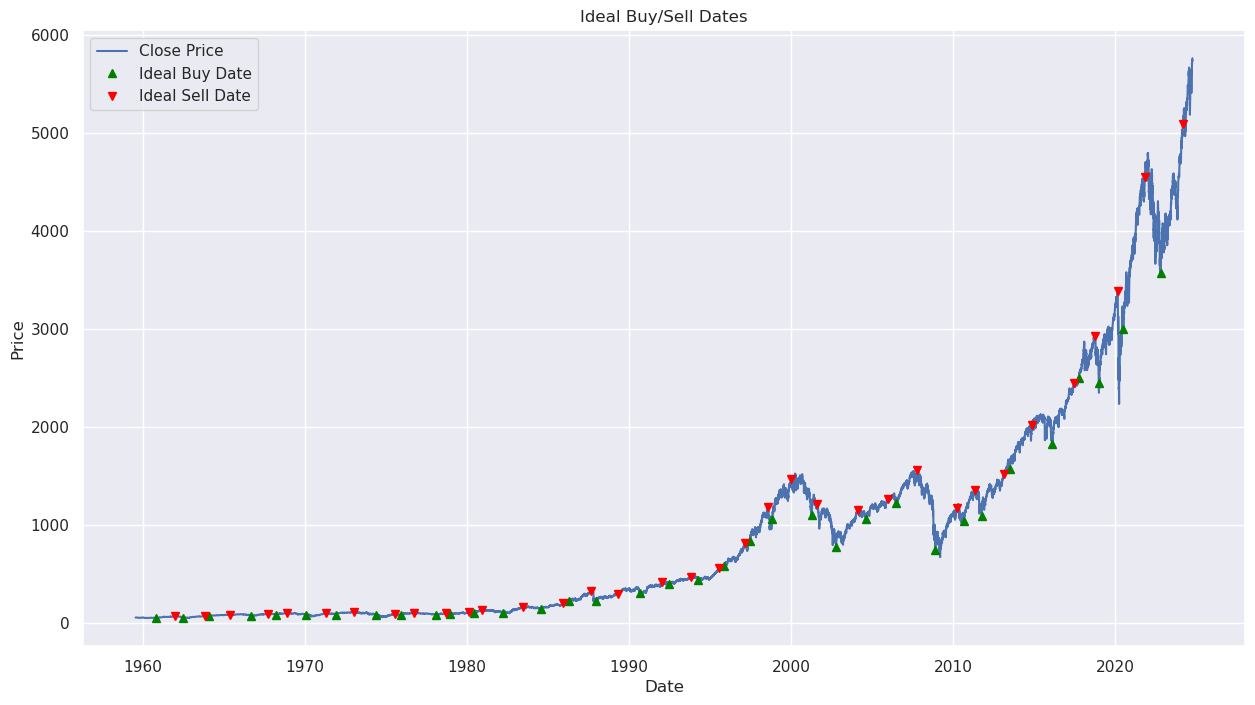

In [225]:
# Style of seaborn
sns.set_theme(style="darkgrid")
# Figure size
plt.figure(figsize=(15, 8))
# Plot the closing price
plt.plot(sp.index, sp['close'], label='Close Price')

# Plot the ideal buy dates
plt.plot(sp[sp['ideal_buy_date'] == 1].index, sp[sp['ideal_buy_date'] == 1]['close'], '^',  color='green', label='Ideal Buy Date')
# Plot the ideal sell dates
plt.plot(sp[sp['ideal_sell_date'] == 1].index, sp[sp['ideal_sell_date'] == 1]['close'], 'v',  color='red', label='Ideal Sell Date')

# Set the title and labels
plt.title('Ideal Buy/Sell Dates')
plt.xlabel('Date')
plt.ylabel('Price')

# Add a legend
plt.legend()
plt.grid(True)

# Show the plot
plt.show()


## Stationarity

I'm going to drop ideal_buy_date and ideal_sell_date to use the expanded columns instead. For graphing and return purposes, I will have to collapse the expanded columns into single points.

In [226]:
sp.drop(columns=['ideal_buy_date', 'ideal_sell_date'],inplace=True)

In [227]:
sp.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23817 entries, 1959-07-19 to 2024-10-01
Freq: D
Data columns (total 50 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   close                       23817 non-null  float64
 1   high_weekly                 23817 non-null  float64
 2   open_weekly                 23817 non-null  float64
 3   volume_weekly               23817 non-null  float64
 4   GDP                         23817 non-null  float64
 5   A191RP1Q027SBEA             23817 non-null  float64
 6   BOGZ1FL135010005Q           23817 non-null  float64
 7   PRS85006091                 23817 non-null  float64
 8   M1V                         23817 non-null  float64
 9   M2V                         23817 non-null  float64
 10  PAYEMS                      23817 non-null  float64
 11  INDPRO                      23817 non-null  float64
 12  CE16OV                      23817 non-null  float64
 13  UNRATE

Stationarity / ADF 

In [228]:
stationary = []
nonstationary = []
print("ADF Test Results")

sp_adf = sp.copy()


for col in sp_adf.columns:
    # drop binary columns
    if sp_adf[col].dtype == 'int64':
        sp_adf.drop(columns=[col], inplace=True)
        continue

    result = adfuller(sp_adf[col])  
    if result[1] < 0.05:
        stationary.append(col)
    else:
        nonstationary.append(col)
    print(f"{col}: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Stationary" if result[1] < 0.05 else "Non-Stationary")
    print(f"\n")



ADF Test Results
close: 4.9601615223297175
p-value: 1.0
Non-Stationary


high_weekly: 5.386045330086687
p-value: 1.0
Non-Stationary


open_weekly: 4.732093295378334
p-value: 1.0
Non-Stationary


volume_weekly: -2.1770042582104794
p-value: 0.21469718311279684
Non-Stationary


GDP: 6.275659527705235
p-value: 1.0
Non-Stationary


A191RP1Q027SBEA: -10.51517980867481
p-value: 1.0006965619066532e-18
Stationary


BOGZ1FL135010005Q: 7.477930085326831
p-value: 1.0
Non-Stationary


PRS85006091: -5.485814699966414
p-value: 2.2313283623782696e-06
Stationary


M1V: -0.11883596584228444
p-value: 0.9475297789133886
Non-Stationary


M2V: -0.18343641459285026
p-value: 0.9404673687047889
Non-Stationary


PAYEMS: -0.6338065997625295
p-value: 0.8631587090171507
Non-Stationary


INDPRO: -1.1862860673325273
p-value: 0.6794671035874555
Non-Stationary


CE16OV: -0.7725549718092494
p-value: 0.8270512213914403
Non-Stationary


UNRATE: -3.6356705004156744
p-value: 0.005114581228582597
Stationary


CPIAUCSL: 4.26

Run the nonstationary columns through .diff() and check again

In [229]:
# ADF test results in first row NA, so need to drop NA
sp_adf_copy = sp_adf.copy()

for col in nonstationary:
    sp_adf_copy[col] = sp_adf_copy[col].diff()
sp_adf_copy.dropna(inplace=True)

for col in sp_adf_copy:
    result = adfuller(sp_adf_copy[col])
    print(f"{col}: {result[0]}")
    print(f"p-value: {result[1]}")
    print("Stationary" if result[1] < 0.05 else "Non-Stationary")
    print(f"\n")



close: -23.968199480127712
p-value: 0.0
Stationary


high_weekly: -22.25275168014433
p-value: 0.0
Stationary


open_weekly: -28.32859691637503
p-value: 0.0
Stationary


volume_weekly: -34.40608075419813
p-value: 0.0
Stationary


GDP: -154.03765402319803
p-value: 0.0
Stationary


A191RP1Q027SBEA: -10.51515388166267
p-value: 1.000843003659031e-18
Stationary


BOGZ1FL135010005Q: -153.3754589905457
p-value: 0.0
Stationary


PRS85006091: -5.485734648764151
p-value: 2.232202280156654e-06
Stationary


M1V: -154.31620160952315
p-value: 0.0
Stationary


M2V: -154.32004067915656
p-value: 0.0
Stationary


PAYEMS: -26.05071420272317
p-value: 0.0
Stationary


INDPRO: -21.964521444140058
p-value: 0.0
Stationary


CE16OV: -26.227378053695748
p-value: 0.0
Stationary


UNRATE: -3.635607356723458
p-value: 0.005115664778903158
Stationary


CPIAUCSL: -14.138444352653263
p-value: 2.2682543729848445e-26
Stationary


SAHMCURRENT: -7.754819494588089
p-value: 9.80119691893778e-12
Stationary


HOUST: -3.0921570

Stationarity should be good now. Let's check it out.

In [230]:
sp_adf_copy

,close,high_weekly,open_weekly,volume_weekly,GDP,A191RP1Q027SBEA,BOGZ1FL135010005Q,PRS85006091,M1V,M2V,...,bb_upper_100,bb_middle_100,bb_lower_100,bb_upper_200,bb_middle_200,bb_lower_200,macd,macd_signal,rsi_28,rsi_56
date,,,,,,,,,,,,,,,,,,,,,
1959-07-20,0.000000,0.079998,-0.500000,-760000.0,0.00,1.8,0.0,3.0,0.0,0.0,...,0.009063,0.029700,0.050337,0.030224,0.019900,0.009576,0.536071,0.459580,57.817425,57.599232
1959-07-21,-0.279999,0.000000,0.000000,0.0,0.00,1.8,0.0,3.0,0.0,0.0,...,-0.002124,0.026900,0.055924,0.023987,0.018500,0.013013,0.506891,0.464560,54.163657,55.775602
1959-07-22,0.500000,0.000000,0.000000,0.0,0.00,1.8,0.0,3.0,0.0,0.0,...,0.012887,0.031900,0.050913,0.035203,0.019850,0.004497,0.500660,0.468360,58.965812,58.182813
1959-07-23,0.200001,0.000000,0.000000,0.0,0.00,1.8,0.0,3.0,0.0,0.0,...,0.025218,0.031800,0.038382,0.039165,0.020850,0.002535,0.502086,0.471910,60.674854,59.089737
1959-07-24,0.059998,0.000000,0.000000,0.0,0.00,1.8,0.0,3.0,0.0,0.0,...,0.032844,0.029600,0.026356,0.039871,0.021150,0.002429,0.504368,0.475327,61.177870,59.358958
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-27,23.110352,0.000000,0.000000,0.0,0.00,5.0,0.0,2.5,0.0,0.0,...,6.574075,2.583403,-1.407269,5.153458,3.108401,1.063343,58.433066,41.298277,62.139609,58.836038
2024-09-28,-7.200195,0.000000,0.000000,0.0,0.00,5.0,0.0,2.5,0.0,0.0,...,6.062772,2.511401,-1.039969,4.827275,3.101150,1.375025,60.308431,43.299346,61.495701,58.537713
2024-09-29,0.000000,0.000000,0.000000,0.0,0.00,5.0,0.0,2.5,0.0,0.0,...,5.916538,2.650000,-0.616538,5.110373,2.814500,0.518626,61.786598,45.245373,61.495701,58.537713


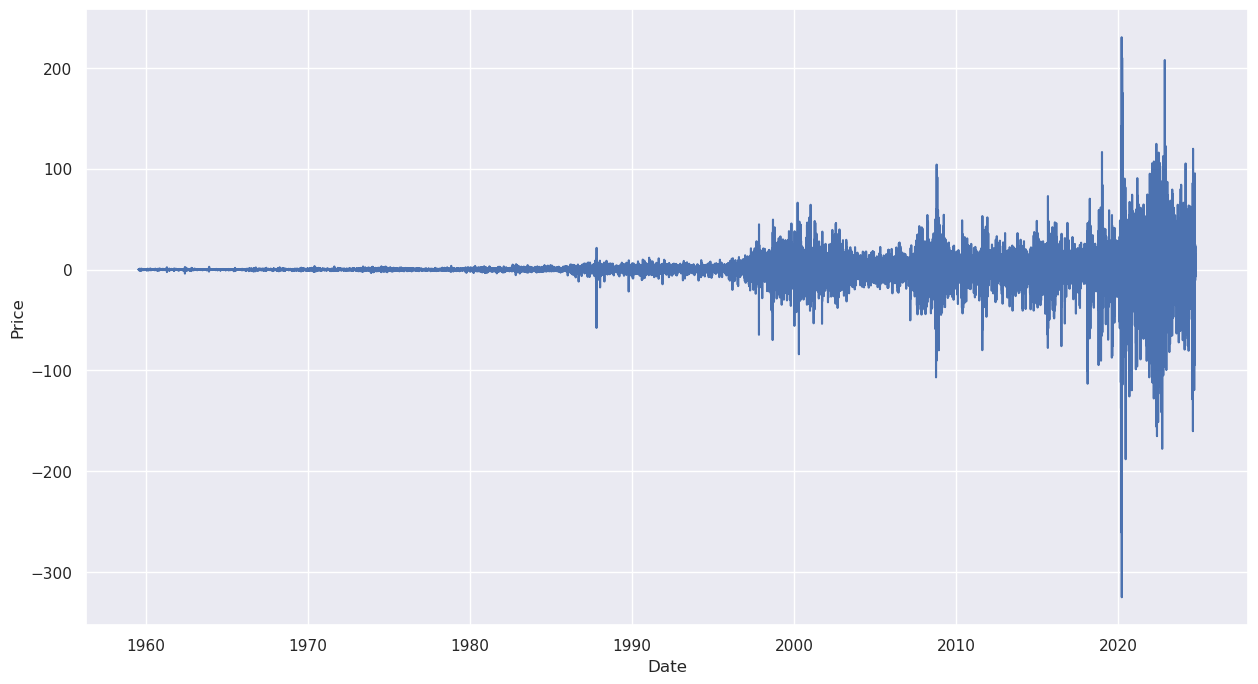

In [231]:
# Style of seaborn
sns.set_theme(style="darkgrid")
# Figure size
plt.figure(figsize=(15, 8))
# Plot the closing price
plt.plot(sp_adf_copy.index, sp_adf_copy['close'], label='Close Price')

# Set the title and labels
plt.xlabel('Date')
plt.ylabel('Price')

# Add a legend
plt.grid(True)

# Show the plot
plt.show()


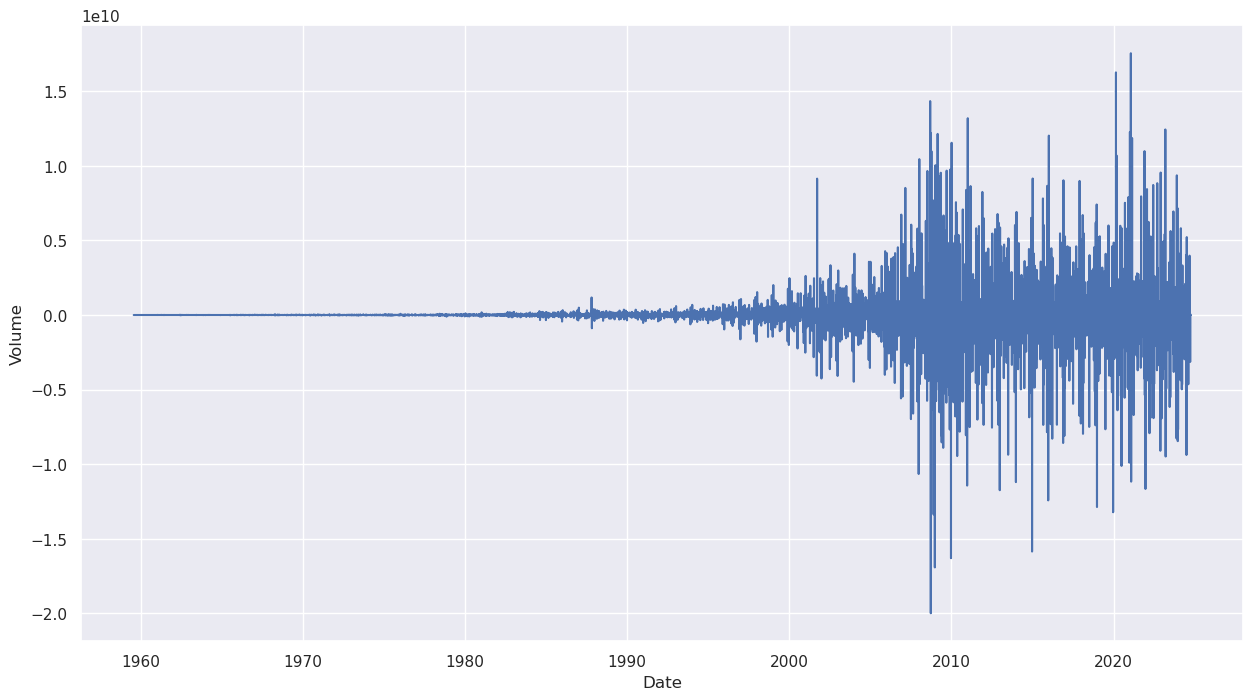

In [232]:
# Style of seaborn
sns.set_theme(style="darkgrid")
# Figure size
plt.figure(figsize=(15, 8))
# Plot the closing price
plt.plot(sp_adf_copy.index, sp_adf_copy['volume_weekly'], label='Weekly Volume')

# Set the title and labels
plt.xlabel('Date')
plt.ylabel('Volume')

# Add a legend
plt.grid(True)

# Show the plot
plt.show()


Normalize the DF

In [233]:
scaler = StandardScaler()
sp_standardized = pd.DataFrame(scaler.fit_transform(sp_adf_copy), columns=sp_adf_copy.columns, index=sp_adf_copy.index)

## Pearson correlation

Reintroduce binary columns 

In [234]:
binary_columns = []
for col in sp.columns:
    # drop binary columns
    if sp[col].dtype == 'int64':
        binary_columns.append(col)
binary_columns

['presidential_elections',
 'presidential_inaugurations',
 'midterm_elections',
 'fomc_meetings',
 'ideal_buy_date_expanded',
 'ideal_sell_date_expanded']

In [235]:
sp_concat = sp.copy()
sp_concat = sp_concat.reindex(sp_adf_copy.index)

sp_concat = pd.concat([sp_adf_copy, sp[binary_columns]], axis=1)

sp_concat.dropna(inplace=True)

print(sp_concat.isna().sum().sum())
print(sp_concat.info())
sp_concat


0
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23816 entries, 1959-07-20 to 2024-10-01
Freq: D
Data columns (total 50 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   close                       23816 non-null  float64
 1   high_weekly                 23816 non-null  float64
 2   open_weekly                 23816 non-null  float64
 3   volume_weekly               23816 non-null  float64
 4   GDP                         23816 non-null  float64
 5   A191RP1Q027SBEA             23816 non-null  float64
 6   BOGZ1FL135010005Q           23816 non-null  float64
 7   PRS85006091                 23816 non-null  float64
 8   M1V                         23816 non-null  float64
 9   M2V                         23816 non-null  float64
 10  PAYEMS                      23816 non-null  float64
 11  INDPRO                      23816 non-null  float64
 12  CE16OV                      23816 non-null  float64
 13  UNRA

,close,high_weekly,open_weekly,volume_weekly,GDP,A191RP1Q027SBEA,BOGZ1FL135010005Q,PRS85006091,M1V,M2V,...,macd,macd_signal,rsi_28,rsi_56,presidential_elections,presidential_inaugurations,midterm_elections,fomc_meetings,ideal_buy_date_expanded,ideal_sell_date_expanded
date,,,,,,,,,,,,,,,,,,,,,
1959-07-20,0.000000,0.079998,-0.500000,-760000.0,0.00,1.8,0.0,3.0,0.0,0.0,...,0.536071,0.459580,57.817425,57.599232,0,0,0,0,0,0
1959-07-21,-0.279999,0.000000,0.000000,0.0,0.00,1.8,0.0,3.0,0.0,0.0,...,0.506891,0.464560,54.163657,55.775602,0,0,0,0,0,0
1959-07-22,0.500000,0.000000,0.000000,0.0,0.00,1.8,0.0,3.0,0.0,0.0,...,0.500660,0.468360,58.965812,58.182813,0,0,0,0,0,0
1959-07-23,0.200001,0.000000,0.000000,0.0,0.00,1.8,0.0,3.0,0.0,0.0,...,0.502086,0.471910,60.674854,59.089737,0,0,0,0,0,0
1959-07-24,0.059998,0.000000,0.000000,0.0,0.00,1.8,0.0,3.0,0.0,0.0,...,0.504368,0.475327,61.177870,59.358958,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-09-27,23.110352,0.000000,0.000000,0.0,0.00,5.0,0.0,2.5,0.0,0.0,...,58.433066,41.298277,62.139609,58.836038,0,0,0,0,0,0
2024-09-28,-7.200195,0.000000,0.000000,0.0,0.00,5.0,0.0,2.5,0.0,0.0,...,60.308431,43.299346,61.495701,58.537713,0,0,0,0,0,0
2024-09-29,0.000000,0.000000,0.000000,0.0,0.00,5.0,0.0,2.5,0.0,0.0,...,61.786598,45.245373,61.495701,58.537713,0,0,0,0,0,0


Pearson correlation matrix heatmap

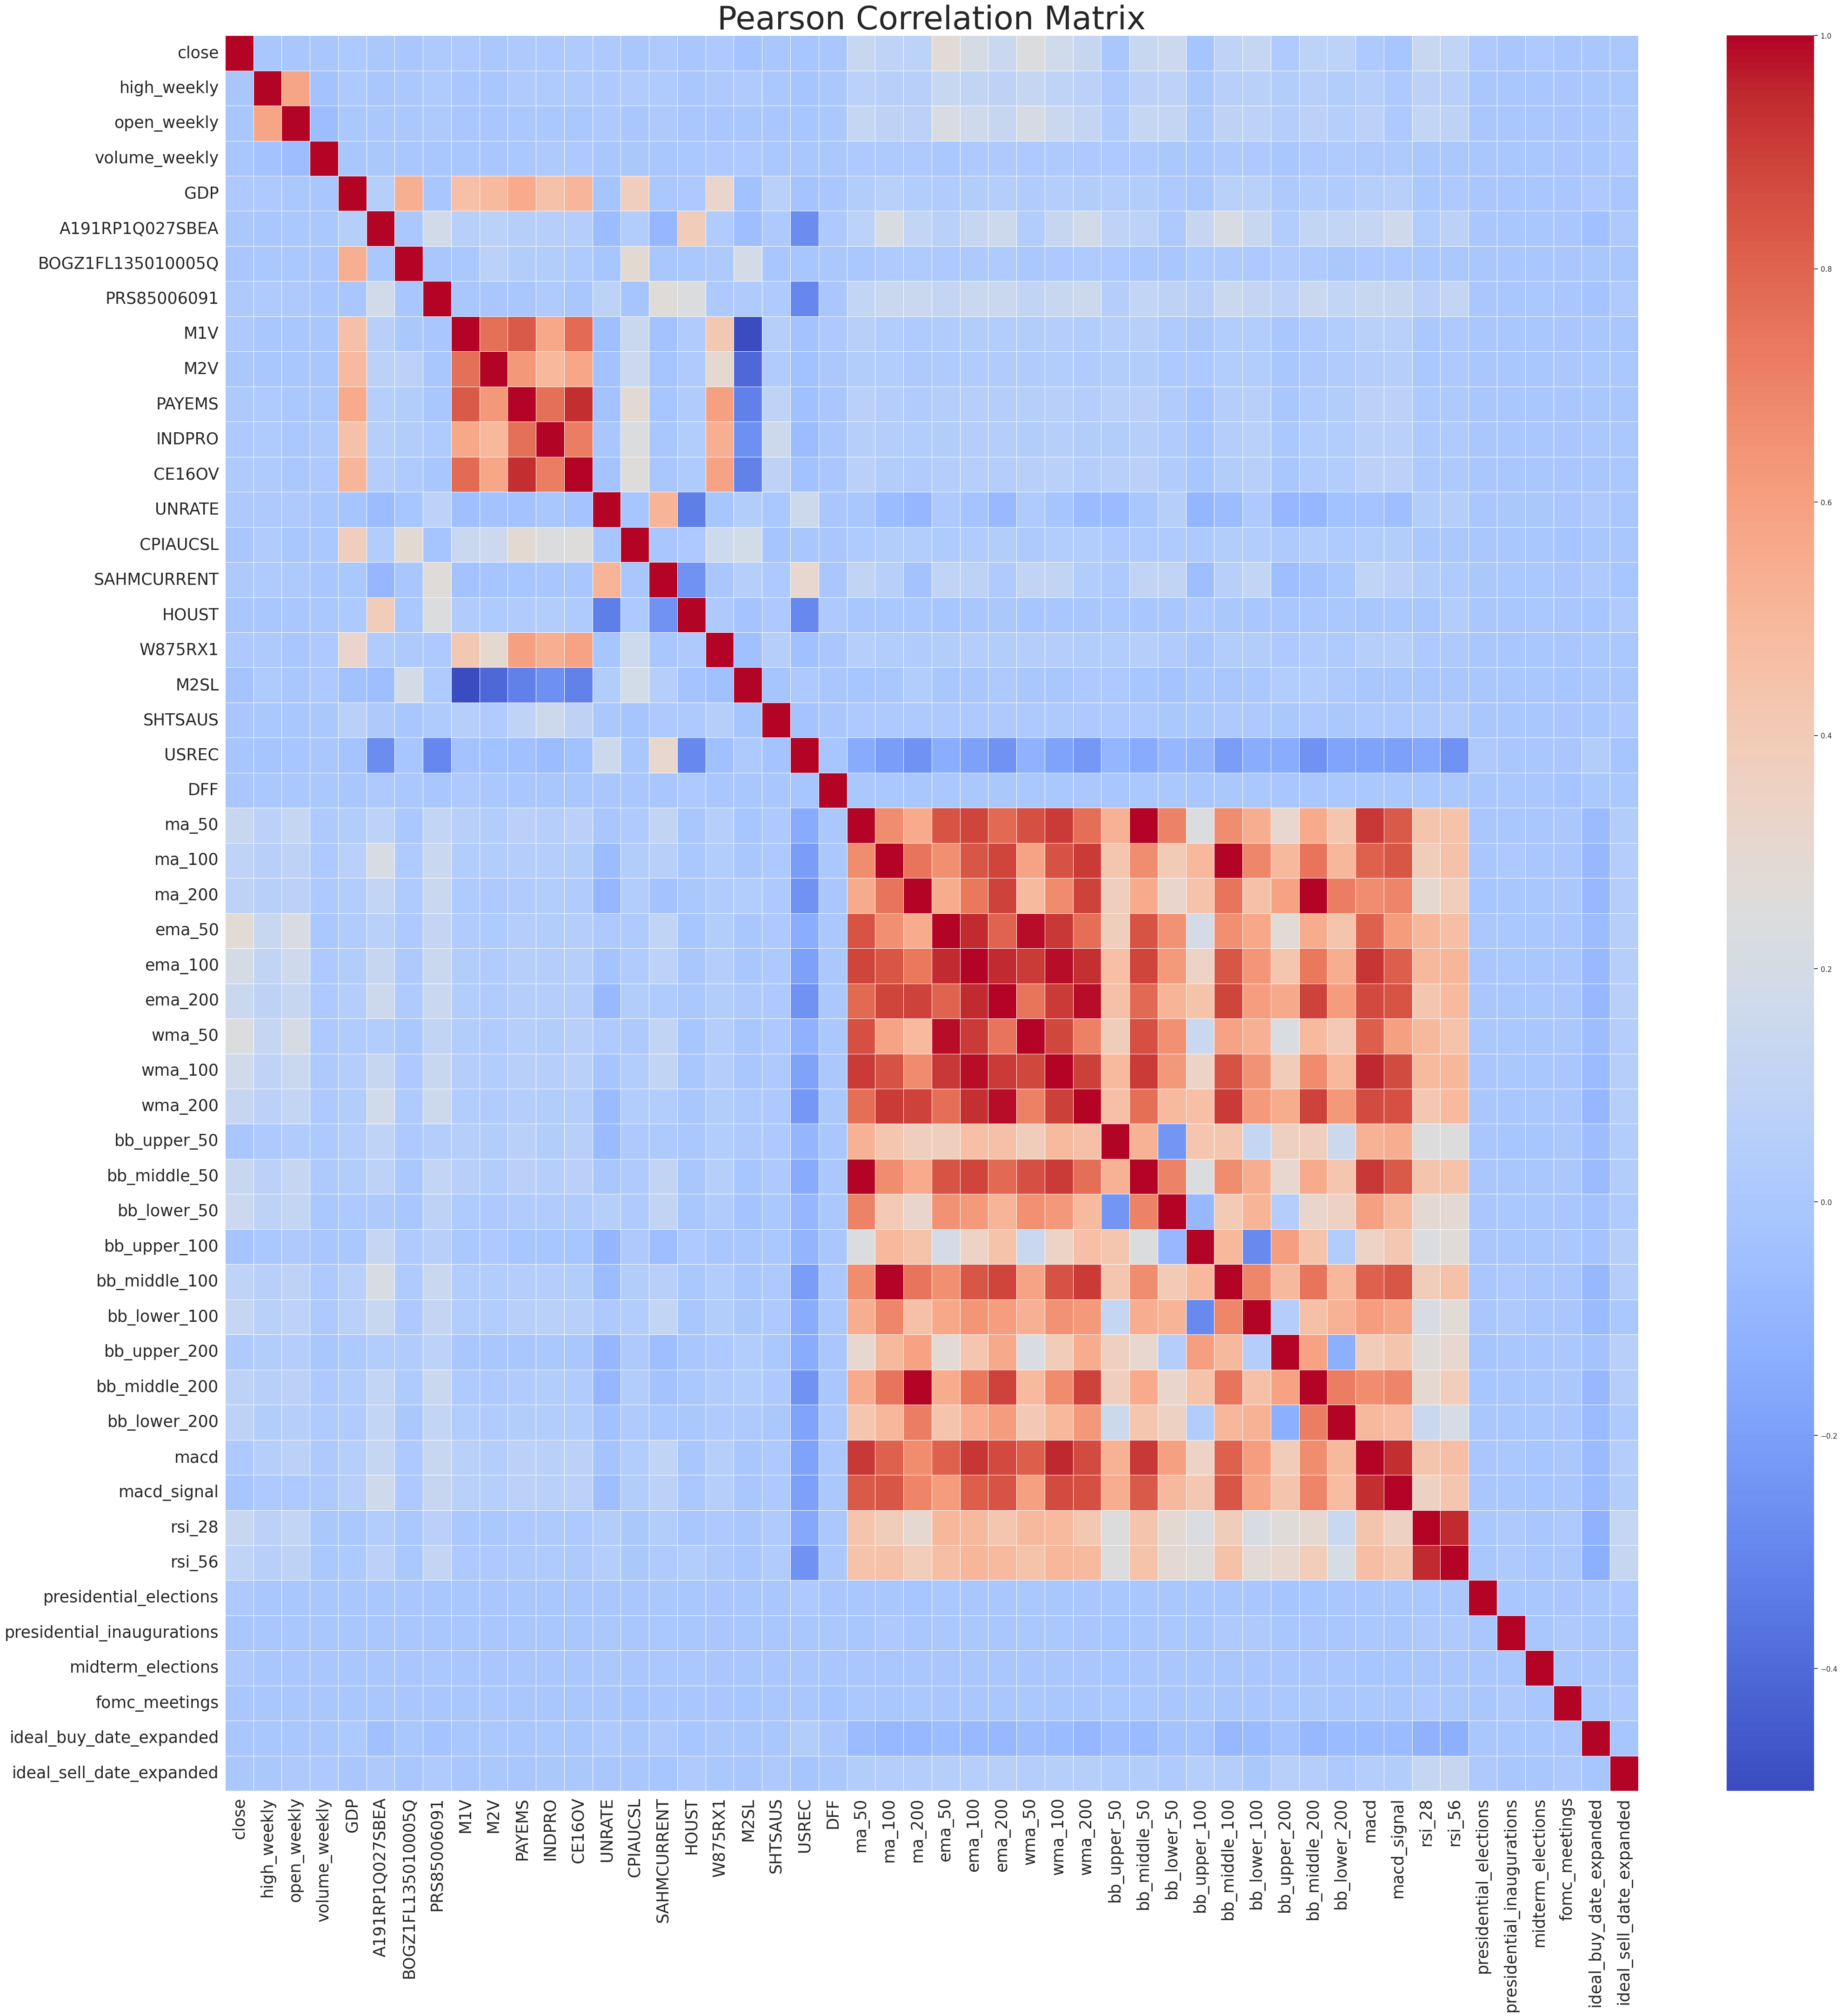

In [236]:
sp_pearson = sp_concat.corr()

# Heatmap
plt.figure(figsize=(49, 49))
sns.heatmap(sp_pearson,  cmap='coolwarm', linewidths=0.5)

plt.title('Pearson Correlation Matrix', fontsize=50)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()


Based on the correlation matrix, there are no clear correlations to the target variables. The main issue I can see is that some of the TA features are highly correlated with each other. I will remove the ones that are most correlated with each other.

In [237]:
sp_concat.drop(columns=['macd_signal', 'rsi_28', 'ema_50', 'CE16OV'], axis=1, inplace=True)

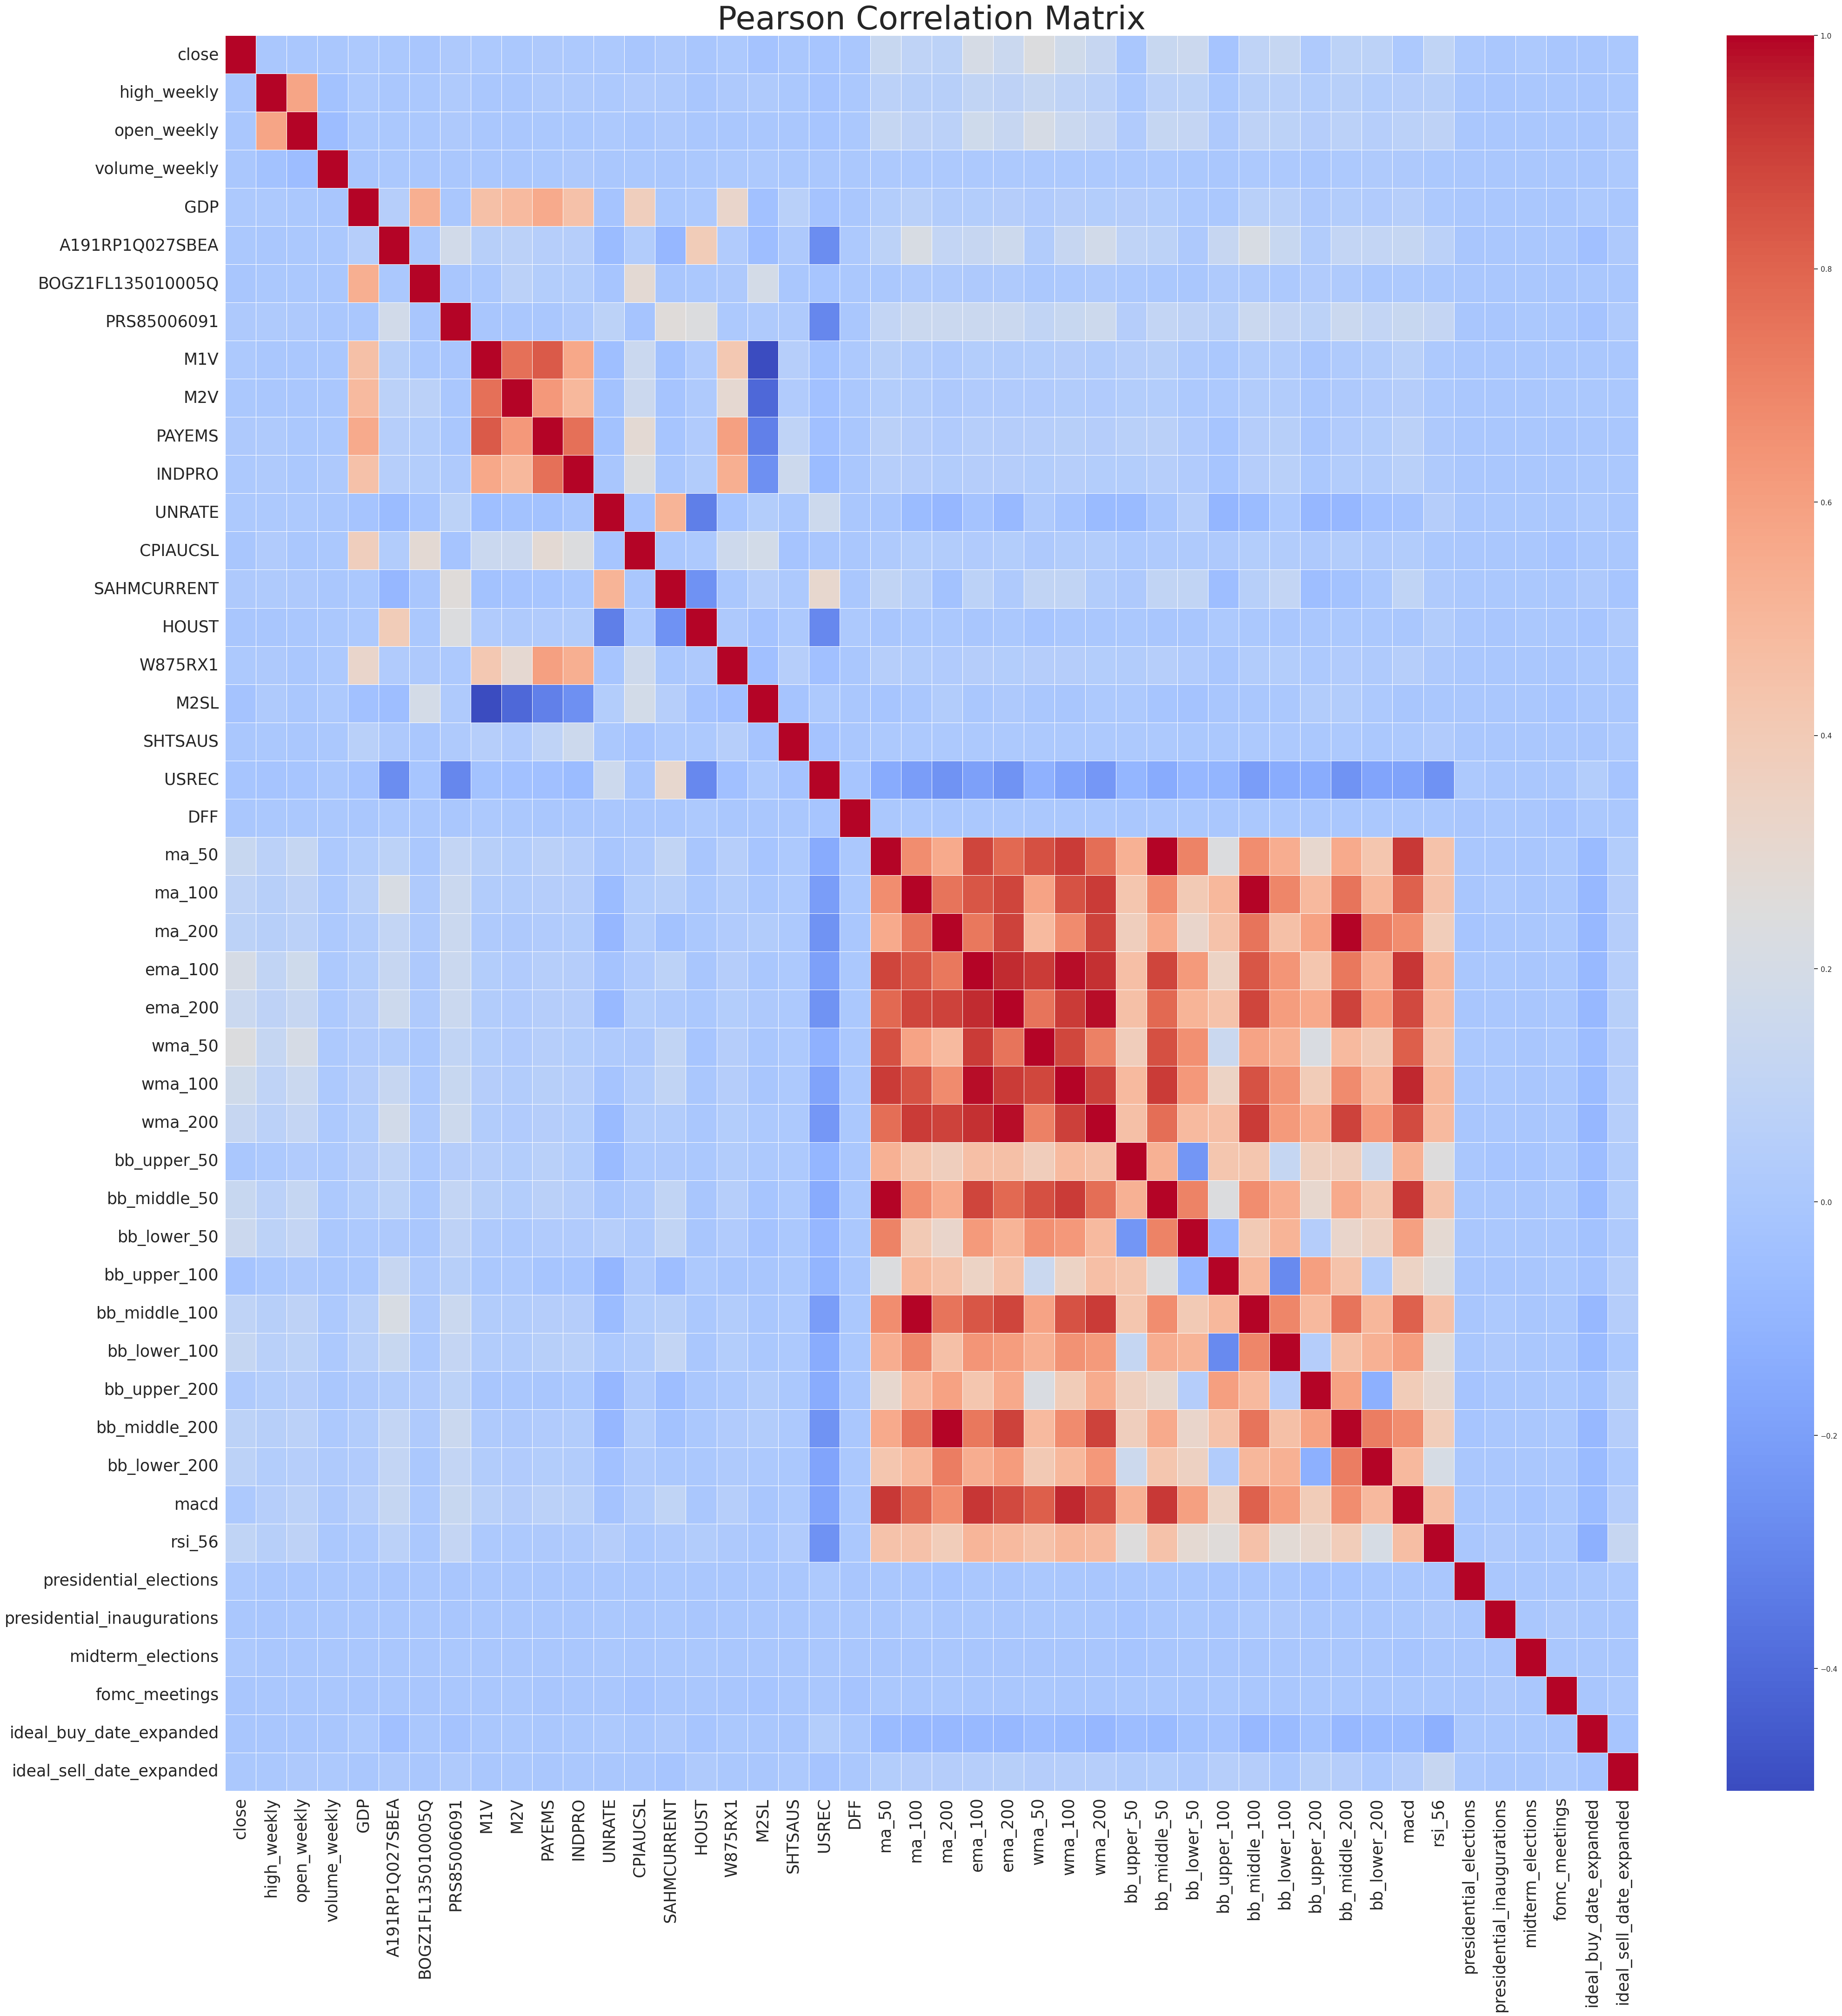

In [238]:
sp_pearson = sp_concat.corr()

# Heatmap
plt.figure(figsize=(49, 49))
sns.heatmap(sp_pearson,  cmap='coolwarm', linewidths=0.5)

plt.title('Pearson Correlation Matrix', fontsize=50)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()


macd, wma, ma, and ema indicators are all highly correlated with each other and bollinger bands. I will remove them. I will also remove M1V and INDPRO.

In [239]:
sp_concat.drop(columns=['macd', 'ma_50', 'ma_100', 'ma_200', 'ema_100', 'ema_200', 'wma_50', 'wma_100', 'wma_200', 'M1V', 'INDPRO'], axis=1, inplace=True)

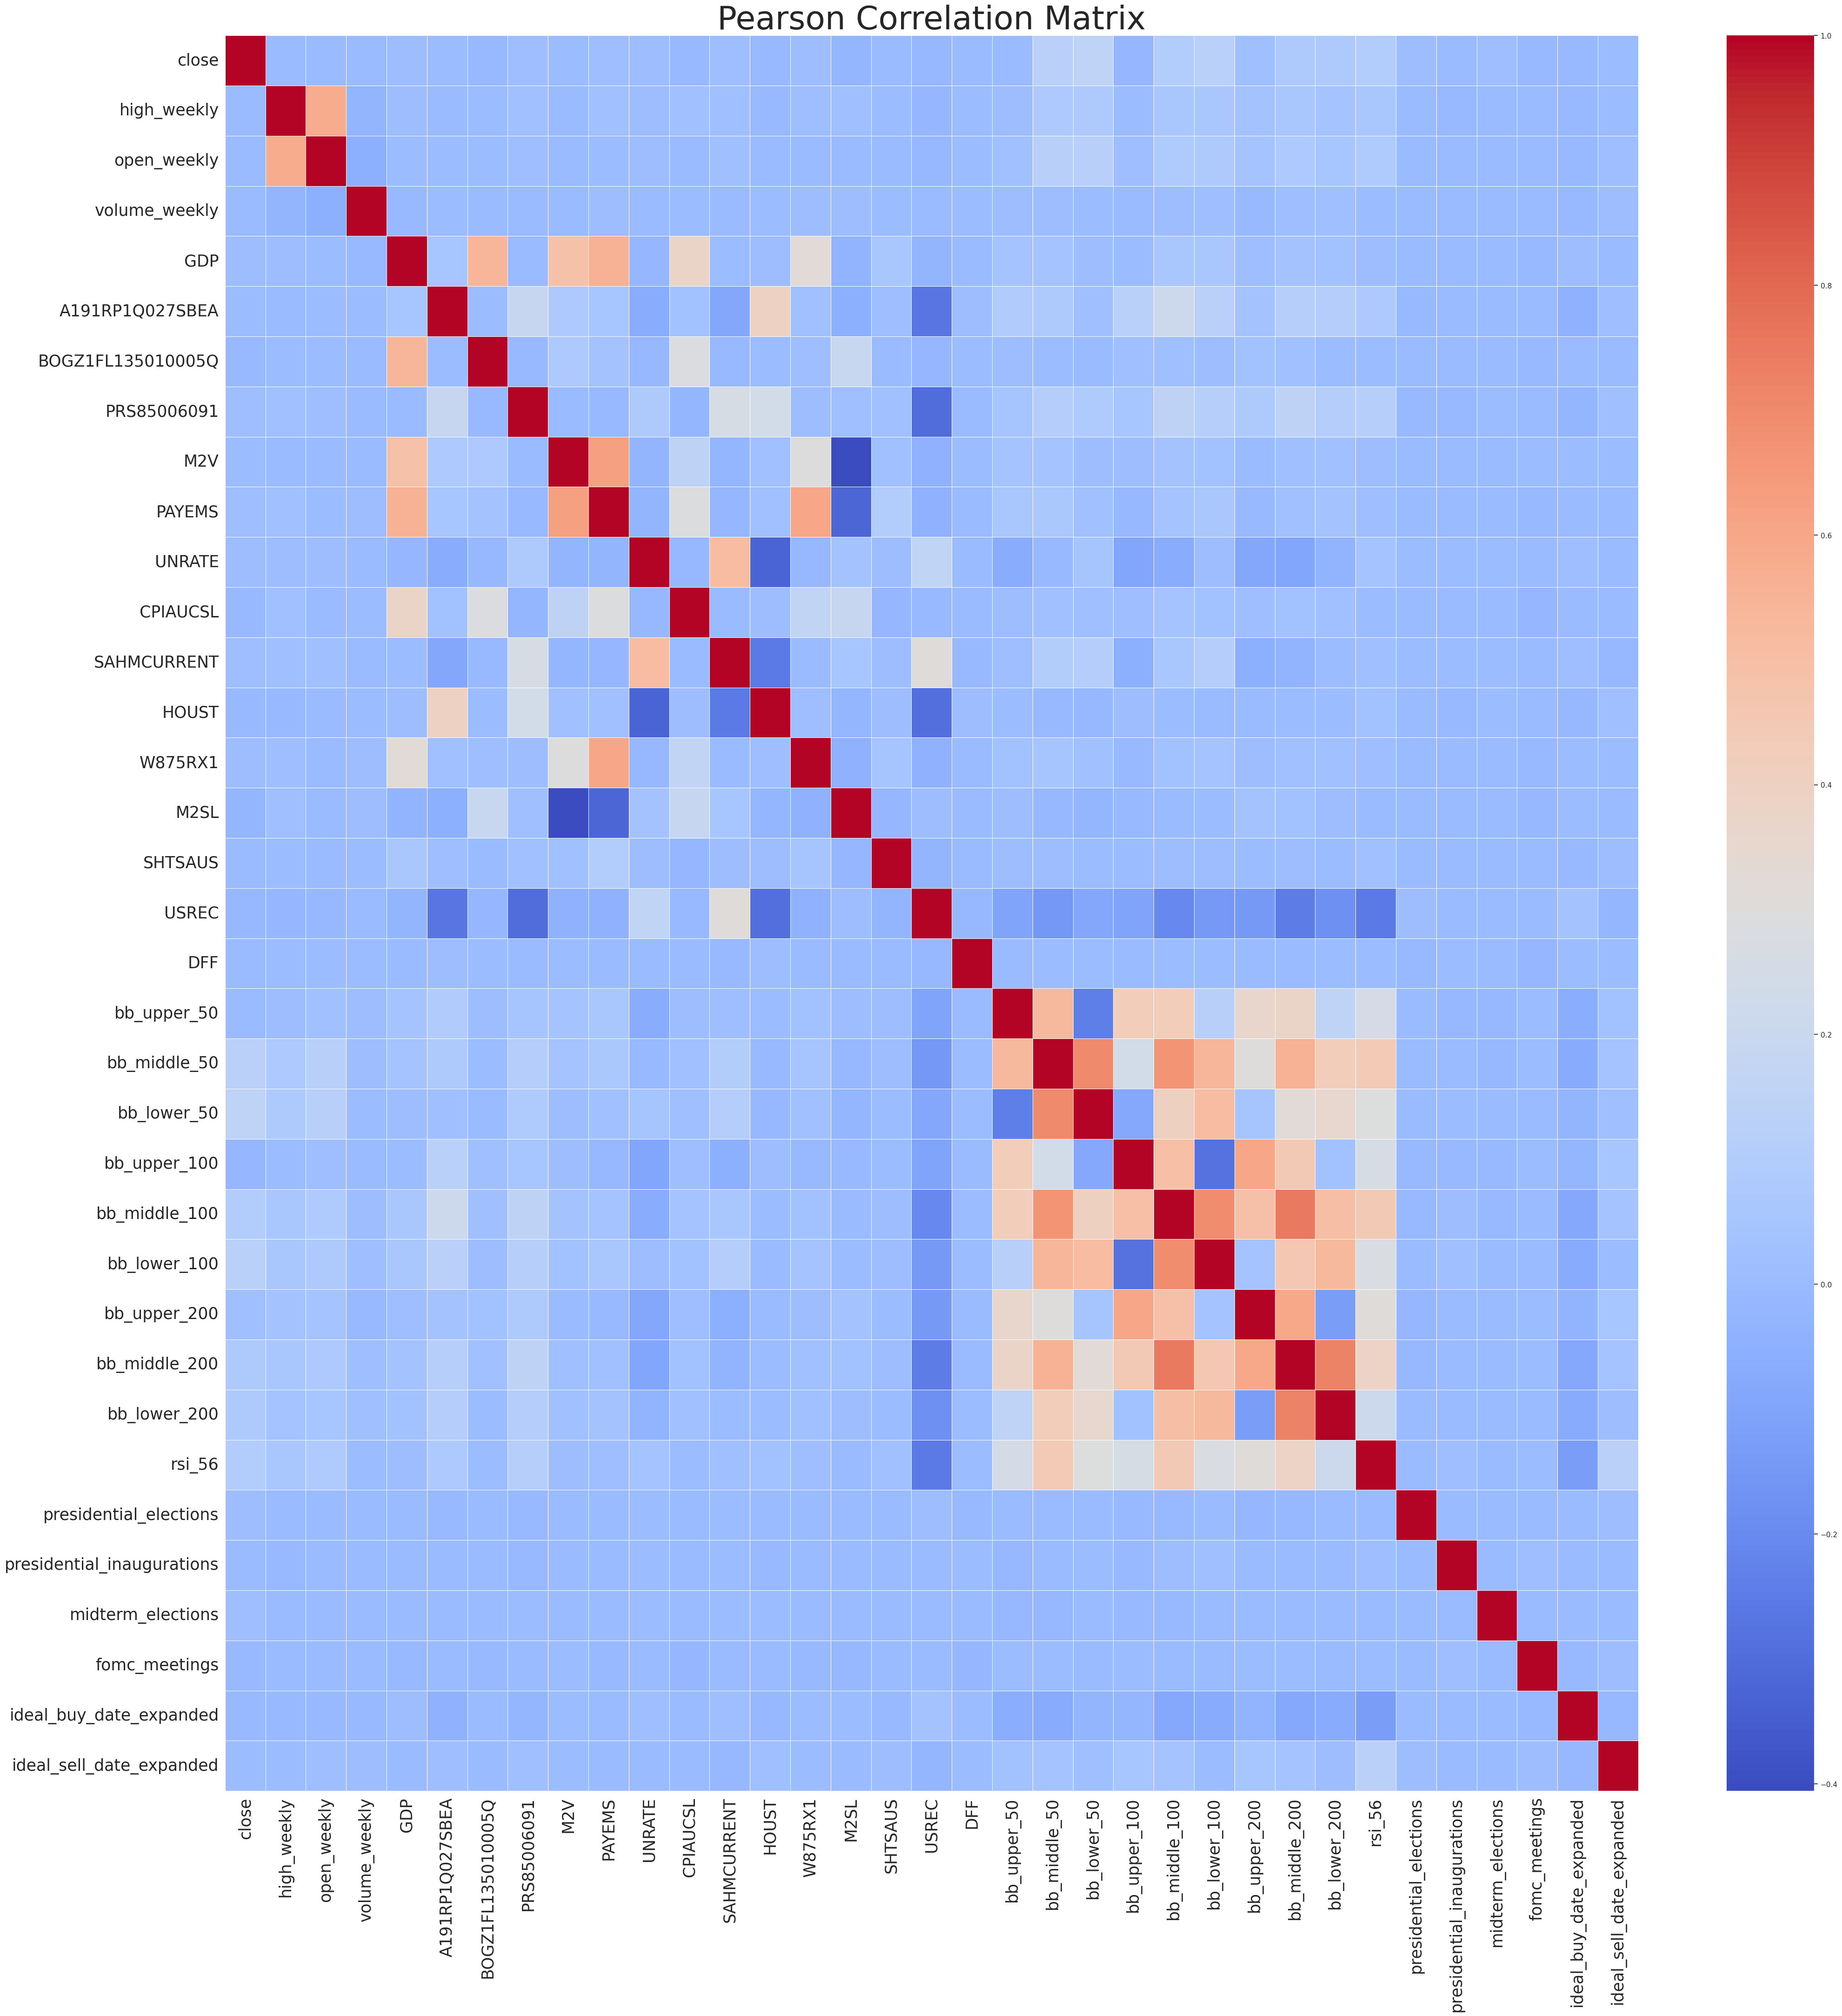

In [240]:
sp_pearson = sp_concat.corr()

# Heatmap
plt.figure(figsize=(49, 49))
sns.heatmap(sp_pearson,  cmap='coolwarm', linewidths=0.5)

plt.title('Pearson Correlation Matrix', fontsize=50)
plt.xticks(fontsize=25)
plt.yticks(fontsize=25)
plt.show()


This looks much better, and should improve modeling. All features are equally uncorrelated to the target variables, so I will work with this DF. 

## Modeling

Force GPU usage using TensorFlow combined with CUDA and cuDNN (This was hard to figure out, but I have a good GPU, so this should speed up the modeling a lot)

In [241]:
print(tf.config.list_physical_devices('GPU'))

print("TensorFlow version:", tf.__version__)
print("GPU Available: ", tf.config.list_physical_devices('GPU'))
print("GPU Device Name: ", tf.test.gpu_device_name())

# This will stop TensorFlow warnings
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  


[]
TensorFlow version: 2.13.0
GPU Available:  []
GPU Device Name:  


In [242]:
sp = sp_concat.copy()

### XGBoost

In [243]:
# Target variable extraction
X = sp.drop(columns=['ideal_buy_date_expanded', 'ideal_sell_date_expanded'])

# Buy model
y_buy = sp['ideal_buy_date_expanded']
X_train_buy, X_test_buy, y_train_buy, y_test_buy = train_test_split(X, y_buy, test_size=0.2, shuffle=False)

buy_model = XGBClassifier(random_state=0)
buy_model.fit(X_train_buy, y_train_buy)
y_pred_buy = buy_model.predict(X_test_buy)

# Sell model
y_sell = sp['ideal_sell_date_expanded']
X_train_sell, X_test_sell, y_train_sell, y_test_sell = train_test_split(X, y_sell, test_size=0.2, shuffle=False)

sell_model = XGBClassifier(random_state=0)
sell_model.fit(X_train_sell, y_train_sell)
y_pred_sell = sell_model.predict(X_test_sell)

print("Accuracy:", accuracy_score(y_test_buy, y_pred_buy))
print("Accuracy:", accuracy_score(y_test_sell, y_pred_sell))

Accuracy: 0.9867758186397985
Accuracy: 0.9829974811083123


### Troubleshooting Accuracy

Accuracy is too high. There is data leakage that I will troubleshoot

Is the data being split right?

In [244]:
print("Training range:", X_train_buy.index.min(), "to", X_train_buy.index.max())
print("Test range:", X_test_buy.index.min(), "to", X_test_buy.index.max())

Training range: 1959-07-20 00:00:00 to 2011-09-16 00:00:00
Test range: 2011-09-17 00:00:00 to 2024-10-01 00:00:00


Is it the weekly data giving future values?

In [245]:
# Target variable extraction
sp.drop(columns=['high_weekly', 'open_weekly'], inplace=True)

# Target variable extraction
X = sp.drop(columns=['ideal_buy_date_expanded', 'ideal_sell_date_expanded'])

# Buy model
y_buy = sp['ideal_buy_date_expanded']
X_train_buy, X_test_buy, y_train_buy, y_test_buy = train_test_split(X, y_buy, test_size=0.2, shuffle=False)

buy_model = XGBClassifier(random_state=0)
buy_model.fit(X_train_buy, y_train_buy)
y_pred_buy = buy_model.predict(X_test_buy)

# Sell model
y_sell = sp['ideal_sell_date_expanded']
X_train_sell, X_test_sell, y_train_sell, y_test_sell = train_test_split(X, y_sell, test_size=0.2, shuffle=False)

sell_model = XGBClassifier(random_state=0)
sell_model.fit(X_train_sell, y_train_sell)
y_pred_sell = sell_model.predict(X_test_sell)

print("Accuracy:", accuracy_score(y_test_buy, y_pred_buy))
print("Accuracy:", accuracy_score(y_test_sell, y_pred_sell))

Accuracy: 0.9869857262804366
Accuracy: 0.9832073887489504


The problem is that the target features are very imbalanced. I am going back to expand the target days to +-5 to correct this. I will still drop the weekly features as they would logically result in leakage.

I will also look at other features than accuracy, since my target variables are still quite imbalanced. I will also troubleshoot adding more expansion to my target features.

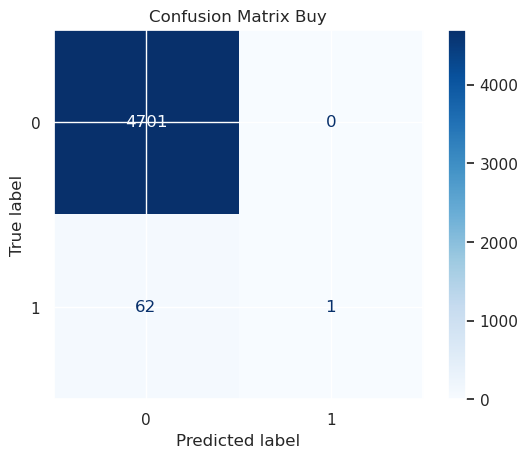

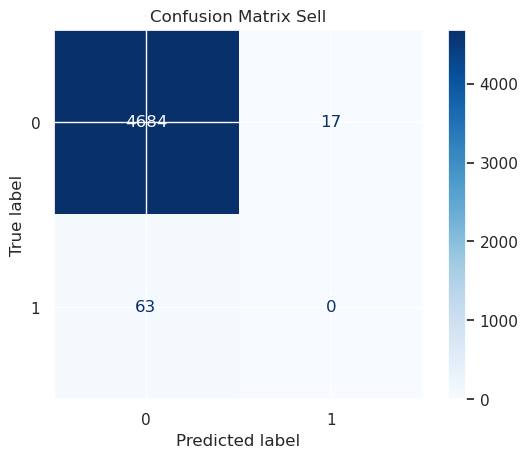

Classification Report Buy:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4701
           1       1.00      0.02      0.03        63

    accuracy                           0.99      4764
   macro avg       0.99      0.51      0.51      4764
weighted avg       0.99      0.99      0.98      4764

Classification Report Sell:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4701
           1       0.00      0.00      0.00        63

    accuracy                           0.98      4764
   macro avg       0.49      0.50      0.50      4764
weighted avg       0.97      0.98      0.98      4764



In [246]:
# Target variable extraction
X = sp.drop(columns=['ideal_buy_date_expanded', 'ideal_sell_date_expanded'])

# Buy model
y_buy = sp['ideal_buy_date_expanded']
X_train_buy, X_test_buy, y_train_buy, y_test_buy = train_test_split(X, y_buy, test_size=0.2, shuffle=False)

buy_model = XGBClassifier(random_state=0)
buy_model.fit(X_train_buy, y_train_buy)
y_pred_buy = buy_model.predict(X_test_buy)

# Sell model
y_sell = sp['ideal_sell_date_expanded']
X_train_sell, X_test_sell, y_train_sell, y_test_sell = train_test_split(X, y_sell, test_size=0.2, shuffle=False)

sell_model = XGBClassifier(random_state=0)
sell_model.fit(X_train_sell, y_train_sell)
y_pred_sell = sell_model.predict(X_test_sell)

# Classification Report
cm_buy = confusion_matrix(y_test_buy, y_pred_buy)
cmd_buy = ConfusionMatrixDisplay(confusion_matrix=cm_buy, display_labels=buy_model.classes_)
cmd_buy.plot(cmap='Blues')
plt.title("Confusion Matrix Buy")
plt.show()

cm_sell = confusion_matrix(y_test_sell, y_pred_sell)
cmd_sell = ConfusionMatrixDisplay(confusion_matrix=cm_sell, display_labels=sell_model.classes_)
cmd_sell.plot(cmap='Blues')
plt.title("Confusion Matrix Sell")
plt.show()

# Confusion Matrix
print("Classification Report Buy:")
print(classification_report(y_test_buy, y_pred_buy))

print("Classification Report Sell:")
print(classification_report(y_test_sell, y_pred_sell))

# ERROR: REDO BELOW NUMBERS

Still showing very high scores around 0 and very low around 1. 

I am going to try different expansion values.

5

Classification Report Buy:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4687
           1       0.17      0.03      0.04        77

    accuracy                           0.98      4764
    macro avg       0.58      0.51      0.52      4764
    weighted avg       0.97      0.98      0.98      4764

Classification Report Sell:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      4687
           1       0.02      0.03      0.02        77

    accuracy                           0.96      4764
    macro avg       0.50      0.50      0.50      4764
    weighted avg       0.97      0.96      0.96      4764

3

Classification Report Buy:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4715
           1       0.00      0.00      0.00        49

    accuracy                           0.99      4764
    macro avg       0.49      0.50      0.50      4764
    weighted avg       0.98      0.99      0.98      4764

Classification Report Sell:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4715
           1       0.11      0.02      0.03        49

    accuracy                           0.99      4764
    macro avg       0.55      0.51      0.51      4764
    weighted avg       0.98      0.99      0.98      4764

4

Classification Report Buy:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4701
           1       0.50      0.02      0.03        63

    accuracy                           0.99      4764
    macro avg       0.74      0.51      0.51      4764
    weighted avg       0.98      0.99      0.98      4764

Classification Report Sell:
              precision    recall  f1-score   support

           0       0.99      1.00      0.99      4701
           1       0.05      0.02      0.02        63

        accuracy                           0.98      4764
    macro avg       0.52      0.51      0.51      4764
    weighted avg       0.97      0.98      0.98      4764

6

Classification Report Buy:
              precision    recall  f1-score   support

           0       0.98      1.00      0.99      4673
           1       0.00      0.00      0.00        91

    accuracy                           0.98      4764
    macro avg       0.49      0.50      0.50      4764
    weighted avg       0.96      0.98      0.97      4764

Classification Report Sell:
              precision    recall  f1-score   support

           0       0.98      0.99      0.98      4673
           1       0.04      0.02      0.03        91

    accuracy                           0.97      4764
    macro avg       0.51      0.51      0.51      4764
    weighted avg       0.96      0.97      0.97      4764



I am going to choose +-4, since that seems to have the best results. Precision is most important to this model.

I will try using decreasing the classification threshold and using the scale_pos_weight

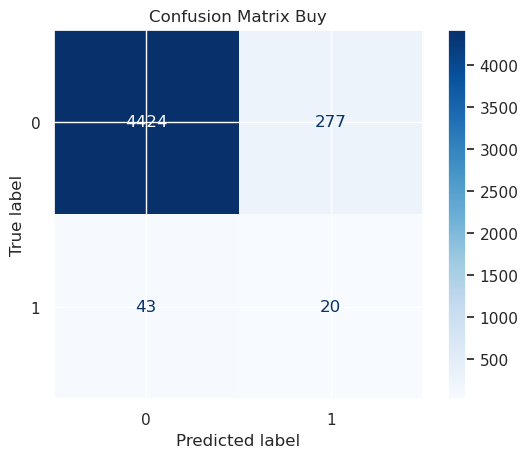

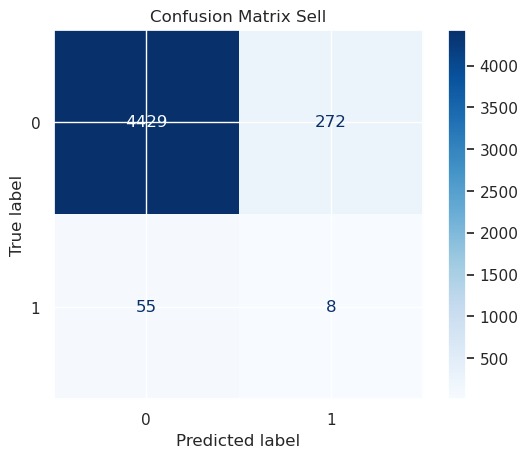

Classification Report Buy:
              precision    recall  f1-score   support

           0       0.99      0.94      0.97      4701
           1       0.07      0.32      0.11        63

    accuracy                           0.93      4764
   macro avg       0.53      0.63      0.54      4764
weighted avg       0.98      0.93      0.95      4764

Classification Report Sell:
              precision    recall  f1-score   support

           0       0.99      0.94      0.96      4701
           1       0.03      0.13      0.05        63

    accuracy                           0.93      4764
   macro avg       0.51      0.53      0.51      4764
weighted avg       0.98      0.93      0.95      4764



In [247]:
# Target variable extraction
X = sp.drop(columns=['ideal_buy_date_expanded', 'ideal_sell_date_expanded'])

# Buy model
y_buy = sp['ideal_buy_date_expanded']
X_train_buy, X_test_buy, y_train_buy, y_test_buy = train_test_split(X, y_buy, test_size=0.2, shuffle=False)

# Calculate scale_pos_weight
n_positive = np.sum(y_train_buy == 1)
n_negative = np.sum(y_train_buy == 0)
scale_weight = n_negative / n_positive

# Train model with scale_pos_weight
buy_model = XGBClassifier(random_state=0, scale_pos_weight=scale_weight)

buy_model.fit(X_train_buy, y_train_buy)
y_proba_buy = buy_model.predict_proba(X_test_buy)[:, 1]
y_pred_buy_threshold = (y_proba_buy > 0.002).astype(int)  

# Sell model
y_sell = sp['ideal_sell_date_expanded']
X_train_sell, X_test_sell, y_train_sell, y_test_sell = train_test_split(X, y_sell, test_size=0.2, shuffle=False)

# Calculate scale_pos_weight
n_positive = np.sum(y_train_sell == 1)
n_negative = np.sum(y_train_sell == 0)
scale_weight = n_negative / n_positive

# Train model with scale_pos_weight
sell_model = XGBClassifier(random_state=0, scale_pos_weight=scale_weight)

sell_model = XGBClassifier(random_state=0)
sell_model.fit(X_train_sell, y_train_sell)
y_proba_sell = sell_model.predict_proba(X_test_sell)[:, 1]
y_pred_sell_threshold = (y_proba_sell > 0.03).astype(int)  


# Classification Report
cm_buy = confusion_matrix(y_test_buy, y_pred_buy_threshold)
cmd_buy = ConfusionMatrixDisplay(confusion_matrix=cm_buy, display_labels=buy_model.classes_)
cmd_buy.plot(cmap='Blues')
plt.title("Confusion Matrix Buy")
plt.show()

cm_sell = confusion_matrix(y_test_sell, y_pred_sell_threshold)
cmd_sell = ConfusionMatrixDisplay(confusion_matrix=cm_sell, display_labels=sell_model.classes_)
cmd_sell.plot(cmap='Blues')
plt.title("Confusion Matrix Sell")
plt.show()

# Confusion Matrix
print("Classification Report Buy:")
print(classification_report(y_test_buy, y_pred_buy_threshold))

print("Classification Report Sell:")
print(classification_report(y_test_sell, y_pred_sell_threshold))



Not great results. I will use a Precision-Recall Threshold Curve to optimize threshold.

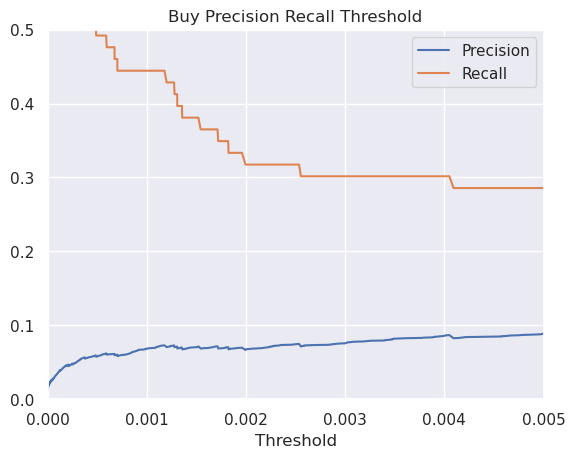

In [248]:
precision, recall, thresholds = precision_recall_curve(y_test_buy, y_proba_buy)
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.title('Buy Precision Recall Threshold')
plt.grid(visible=True)
plt.xlim(0,0.005) 
plt.ylim(0,0.5)
plt.show()

0.002 threshold seems best for Buy

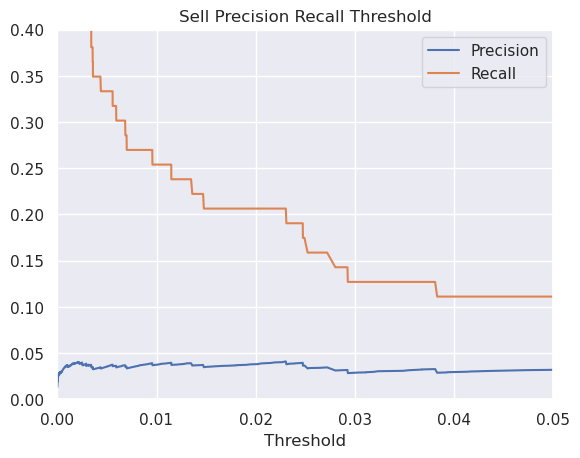

In [249]:
precision, recall, thresholds = precision_recall_curve(y_test_sell, y_proba_sell)
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.legend()
plt.title('Sell Precision Recall Threshold')
plt.grid(visible=True)
plt.xlim(0,0.05) 
plt.ylim(0,0.4)
plt.show()

0.03 seems best for Sell

XGBoost Feature Importance

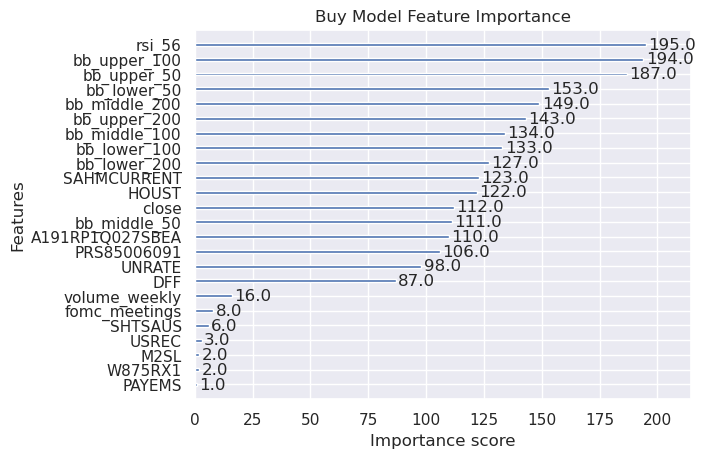

In [250]:
xgb.plot_importance(buy_model, max_num_features=50)
plt.title("Buy Model Feature Importance")
plt.show()

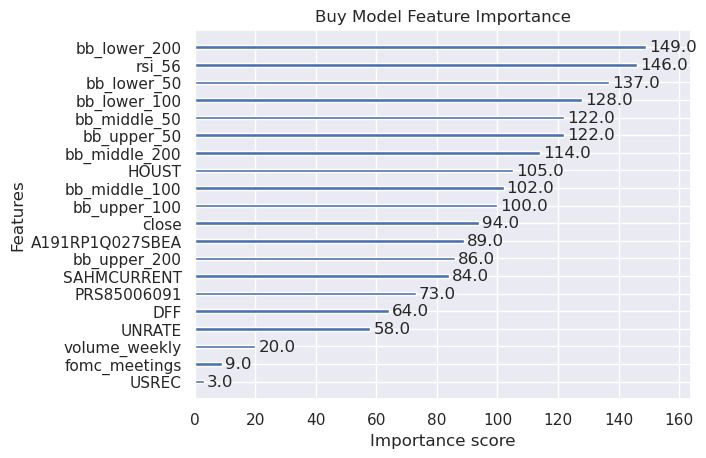

In [251]:
xgb.plot_importance(sell_model, max_num_features=40)
plt.title("Buy Model Feature Importance")
plt.show()

Outlier detection 

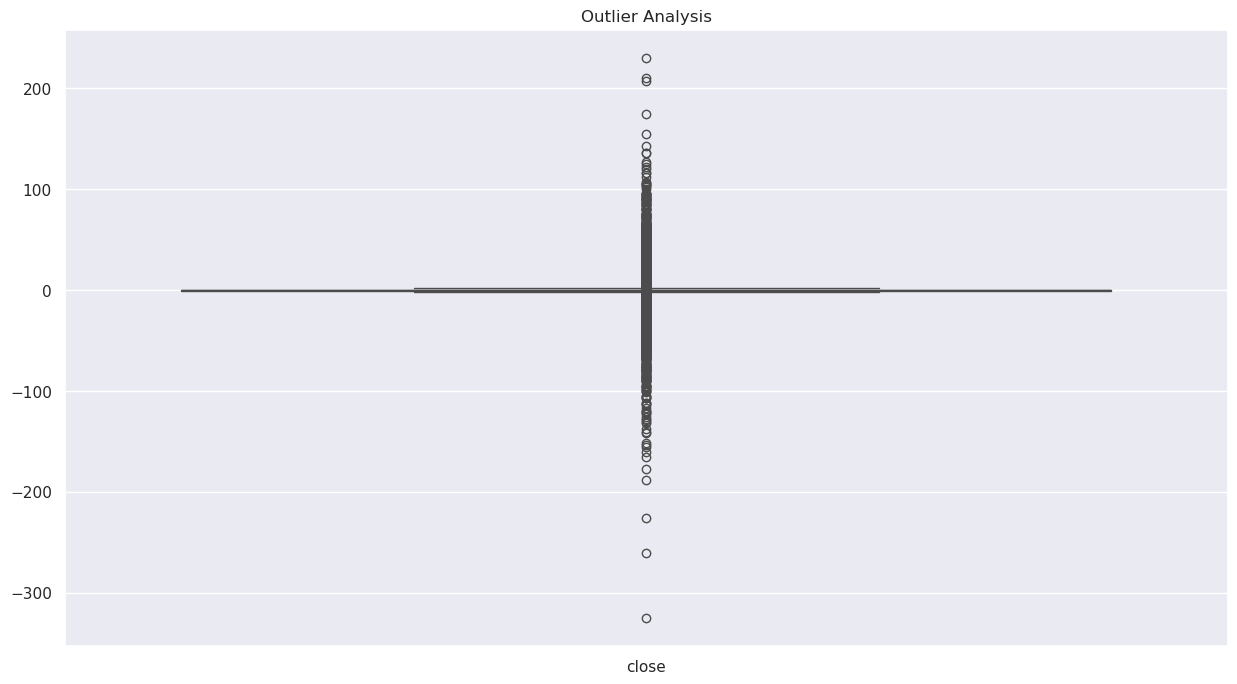

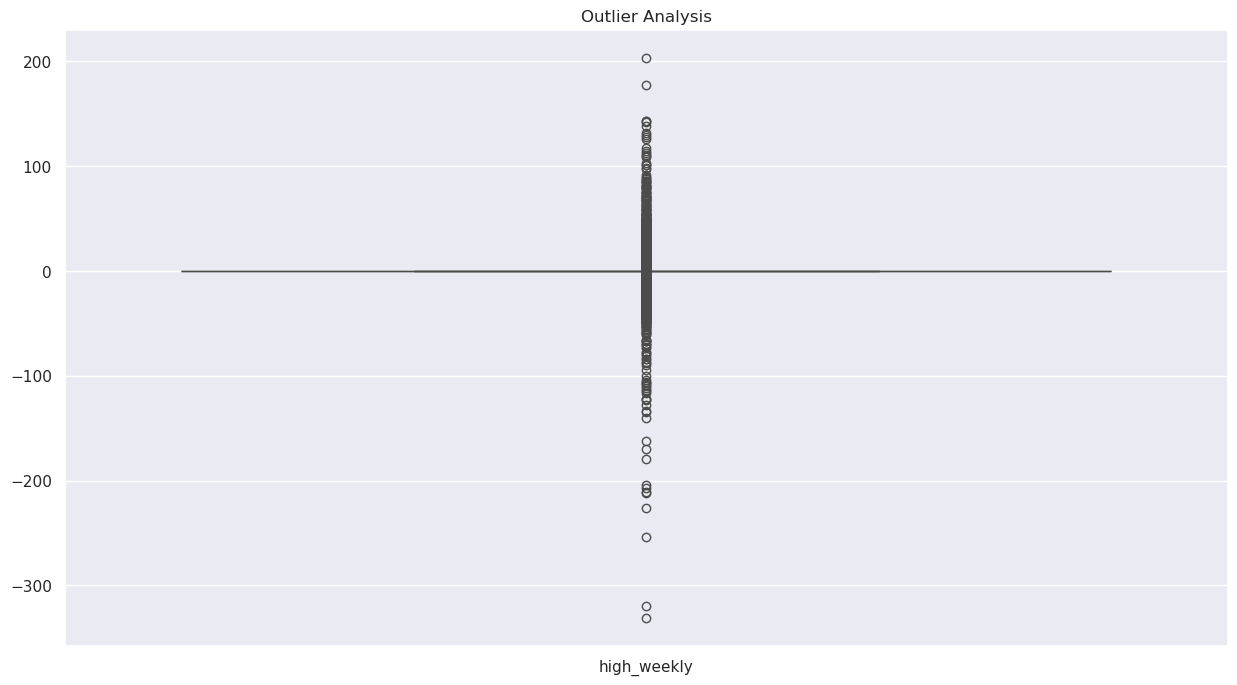

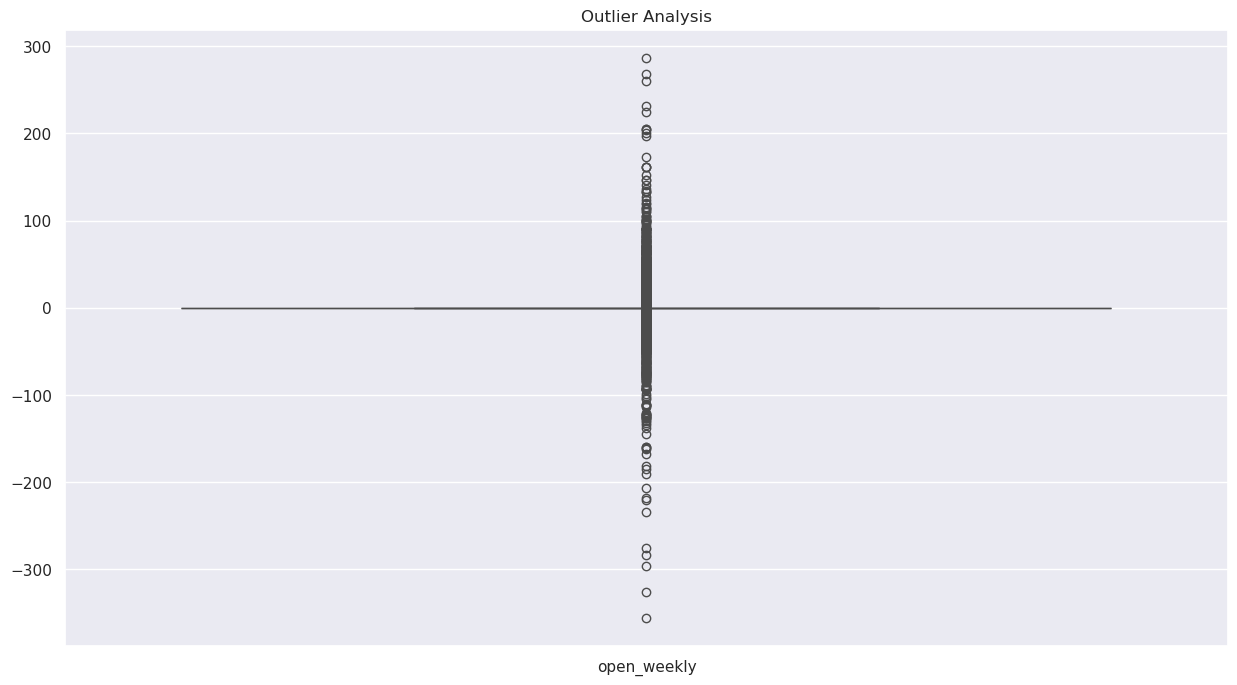

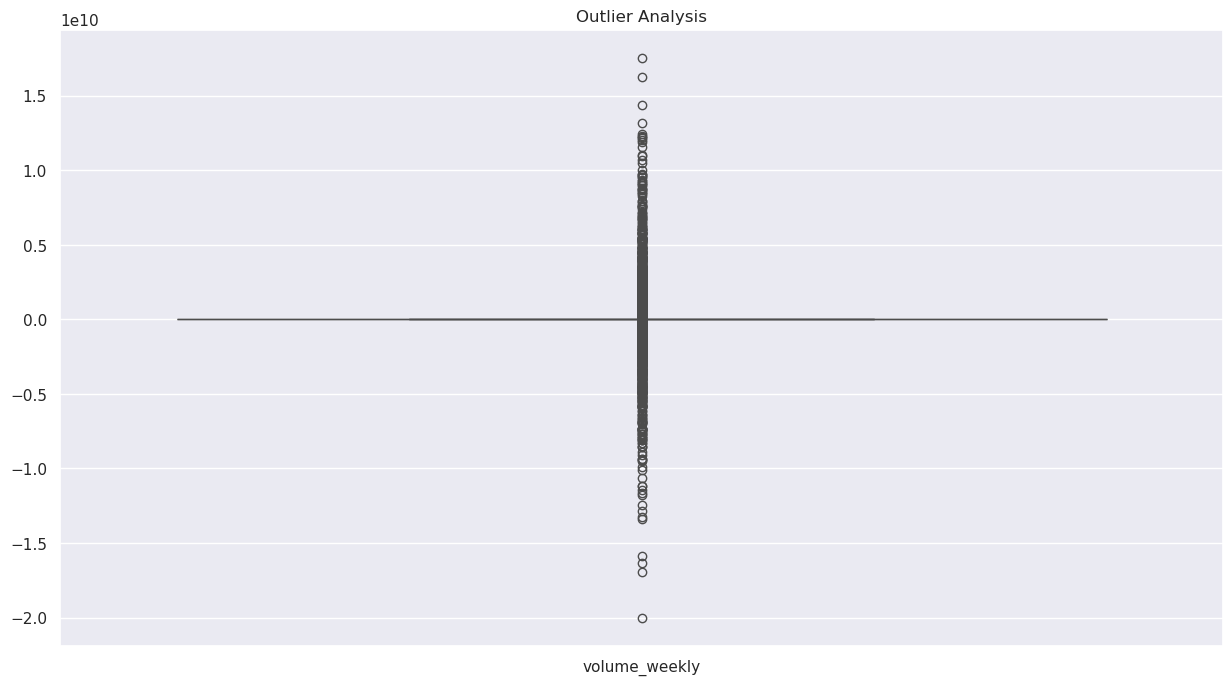

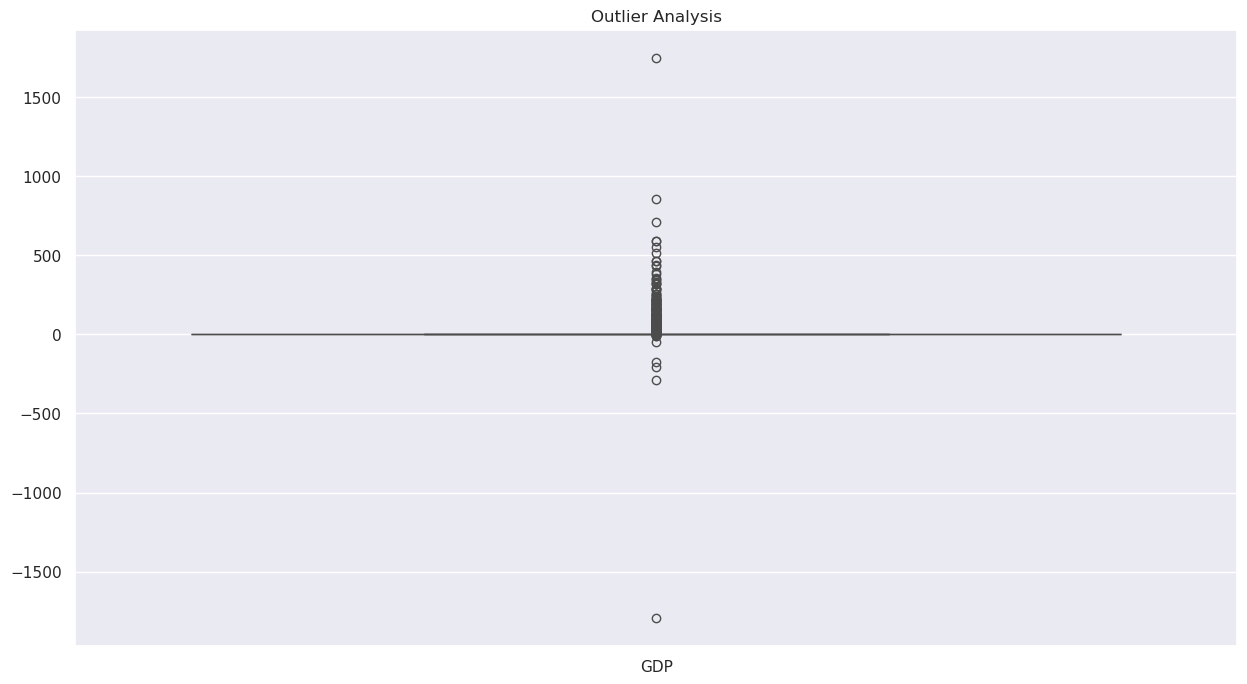

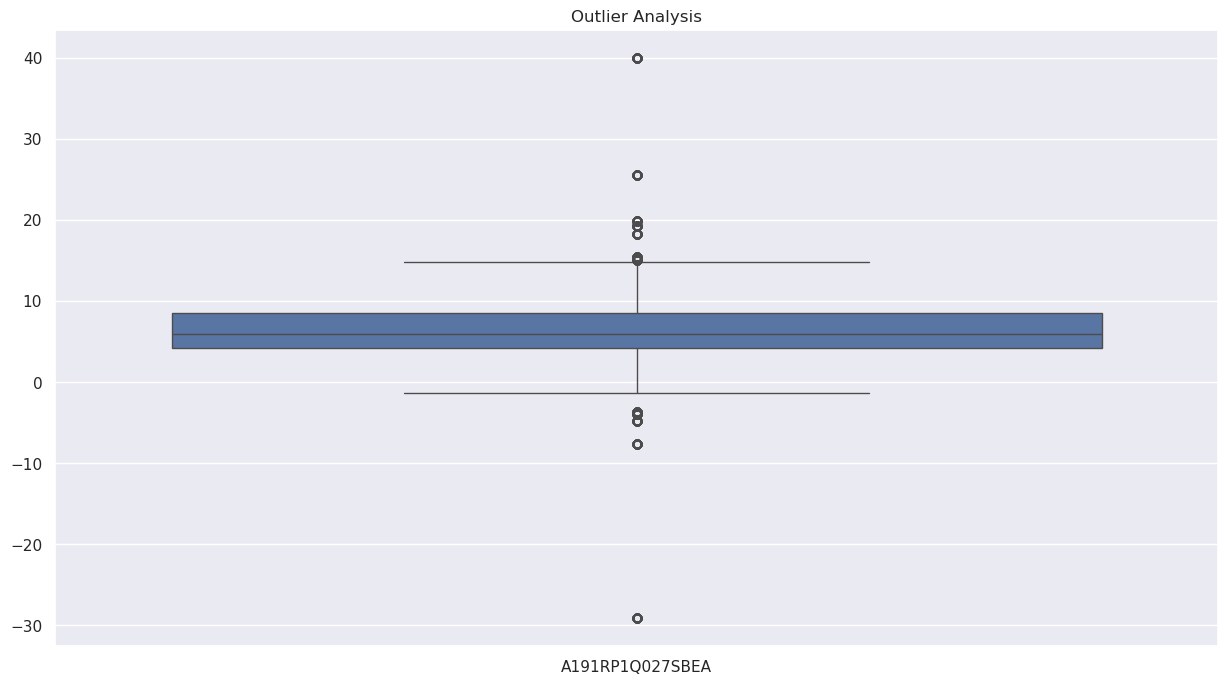

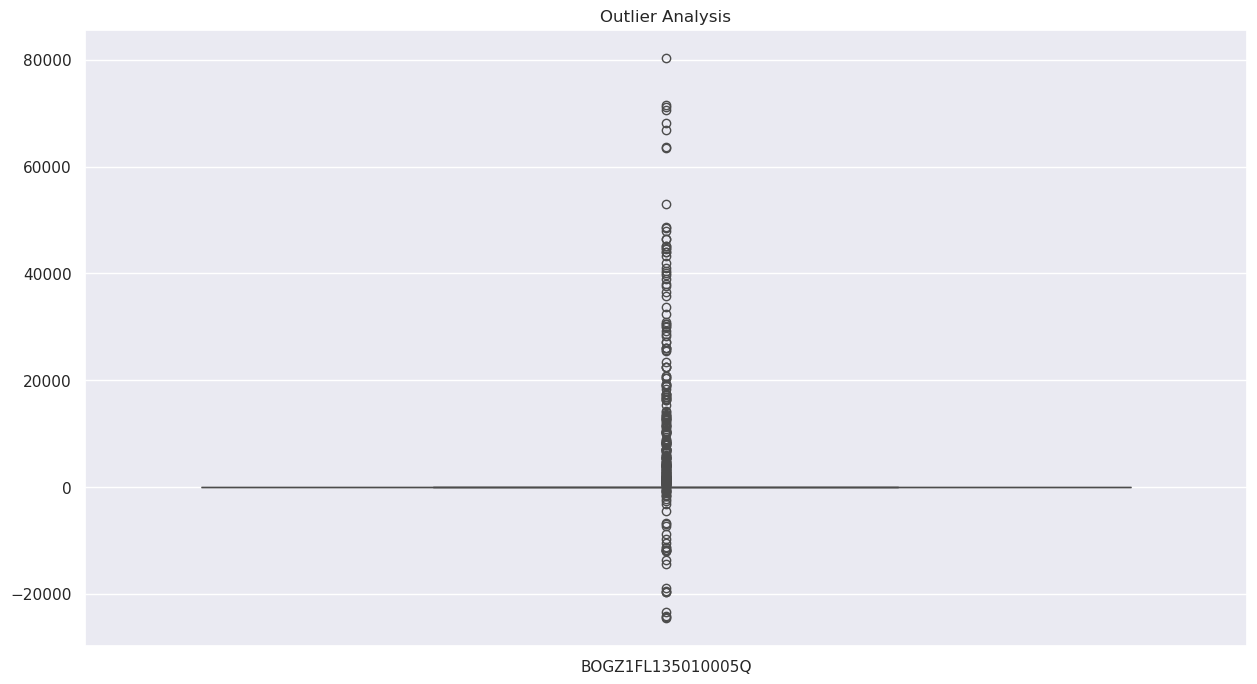

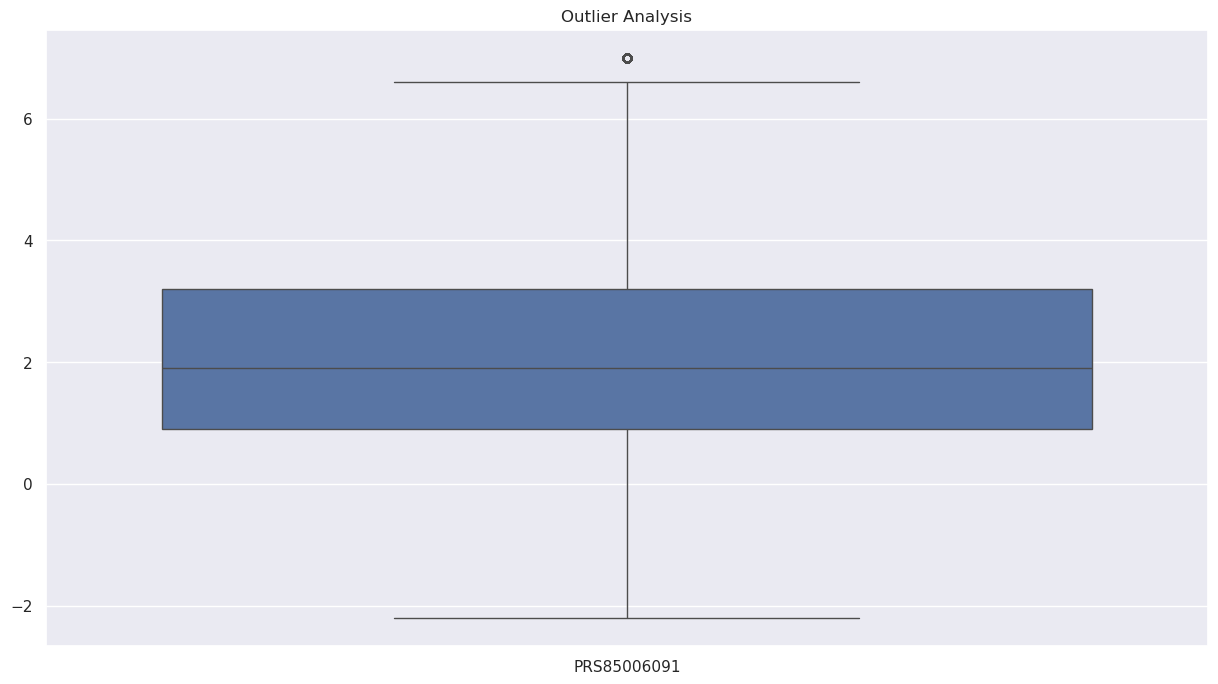

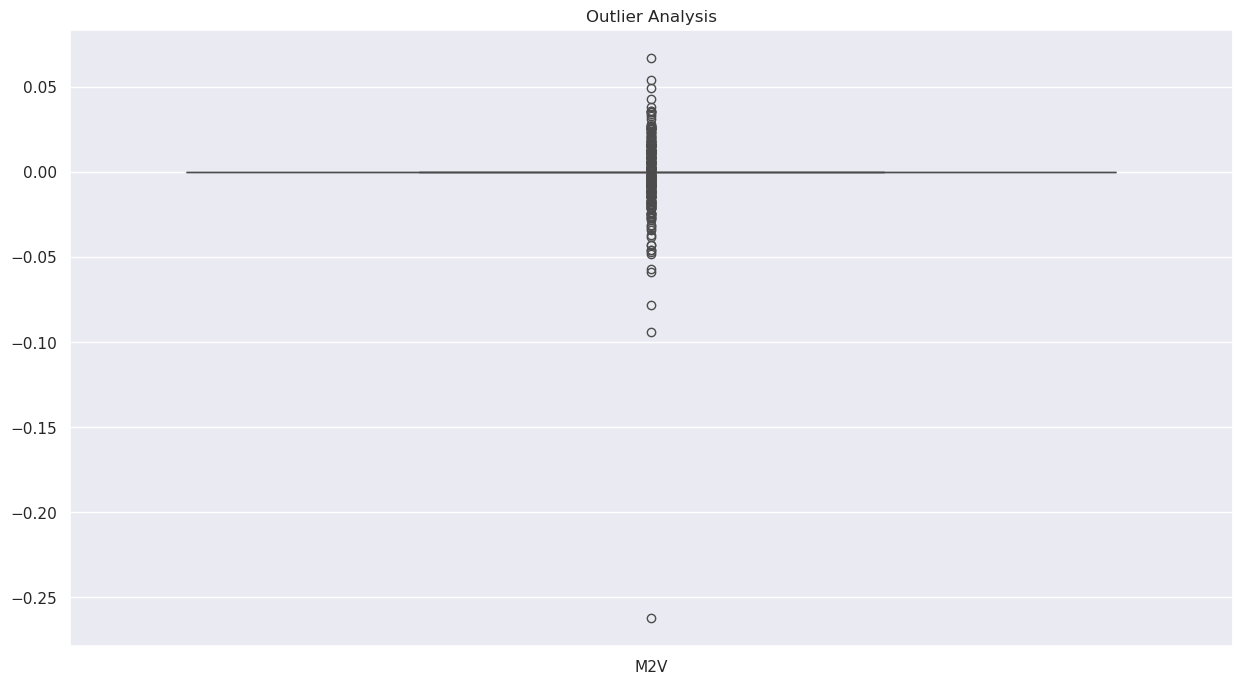

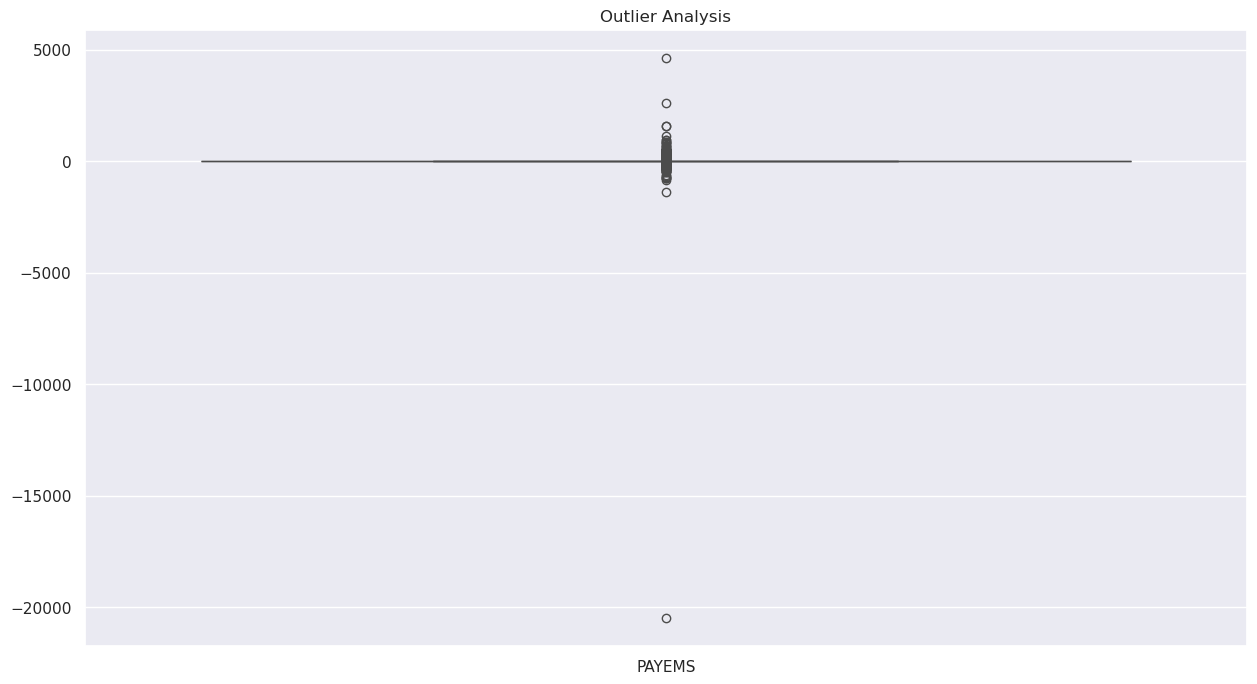

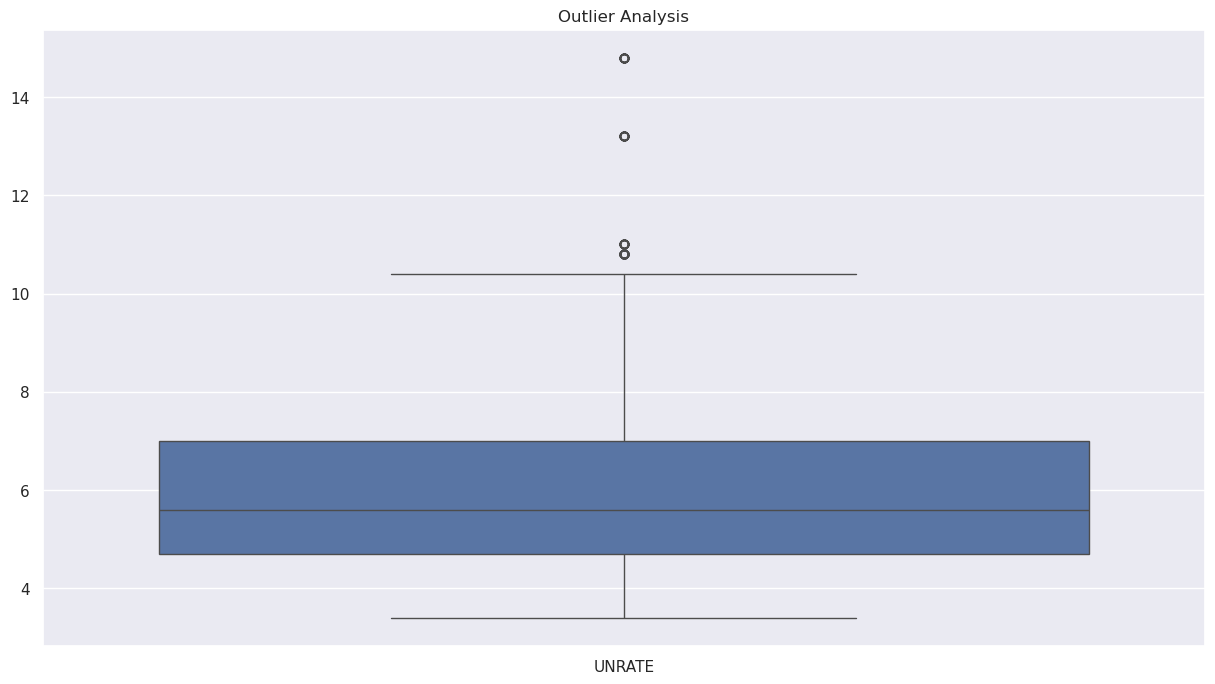

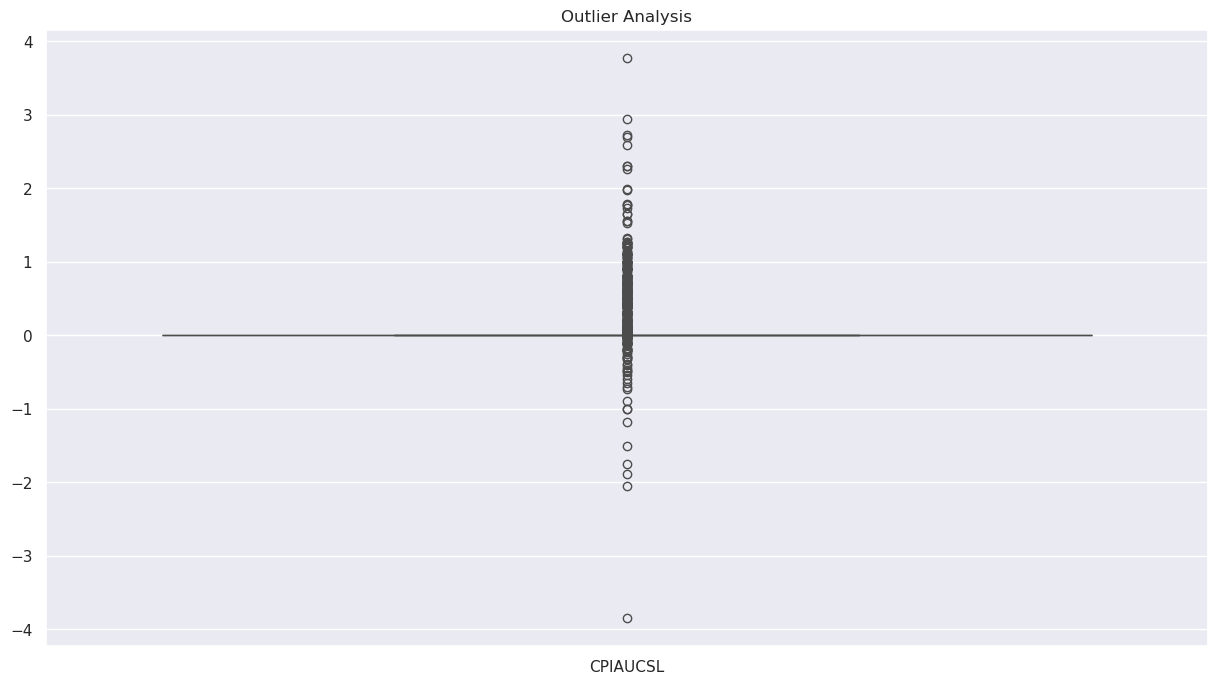

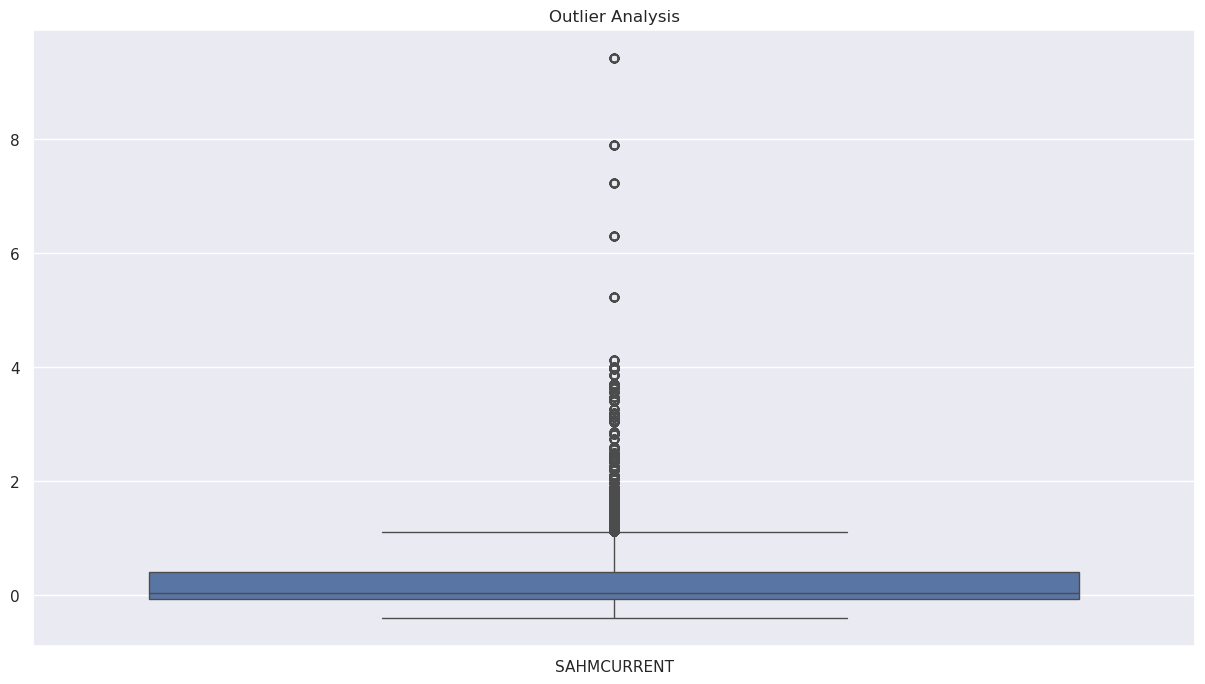

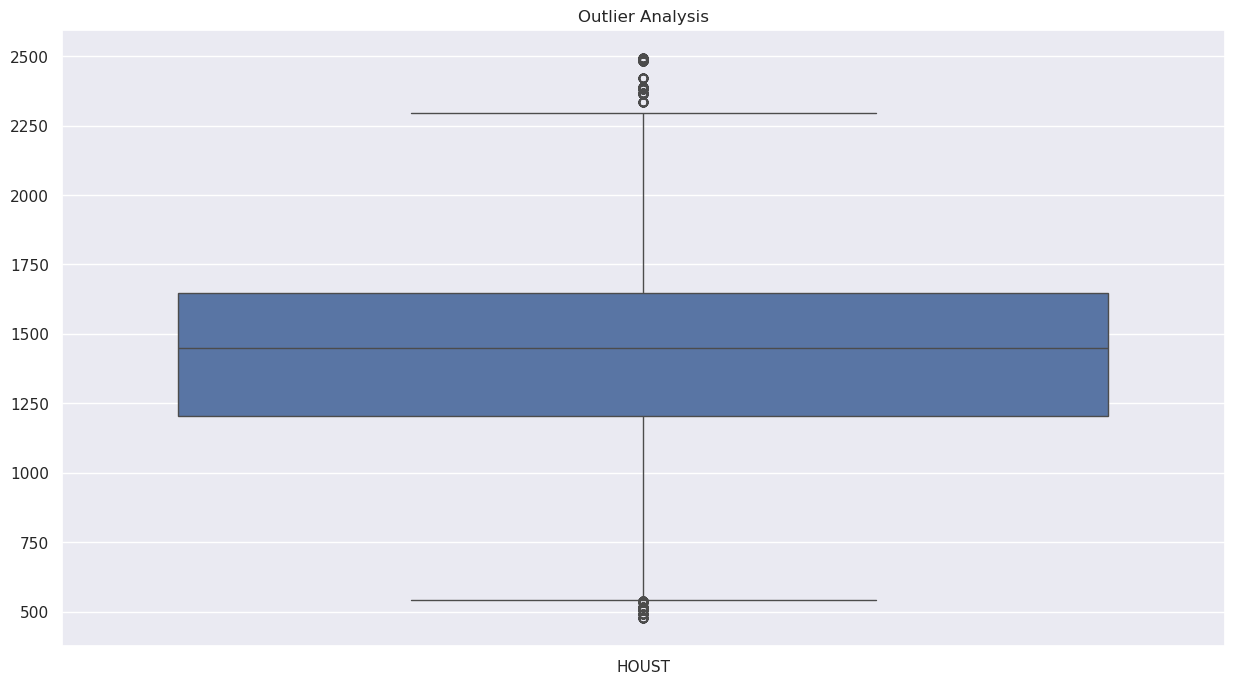

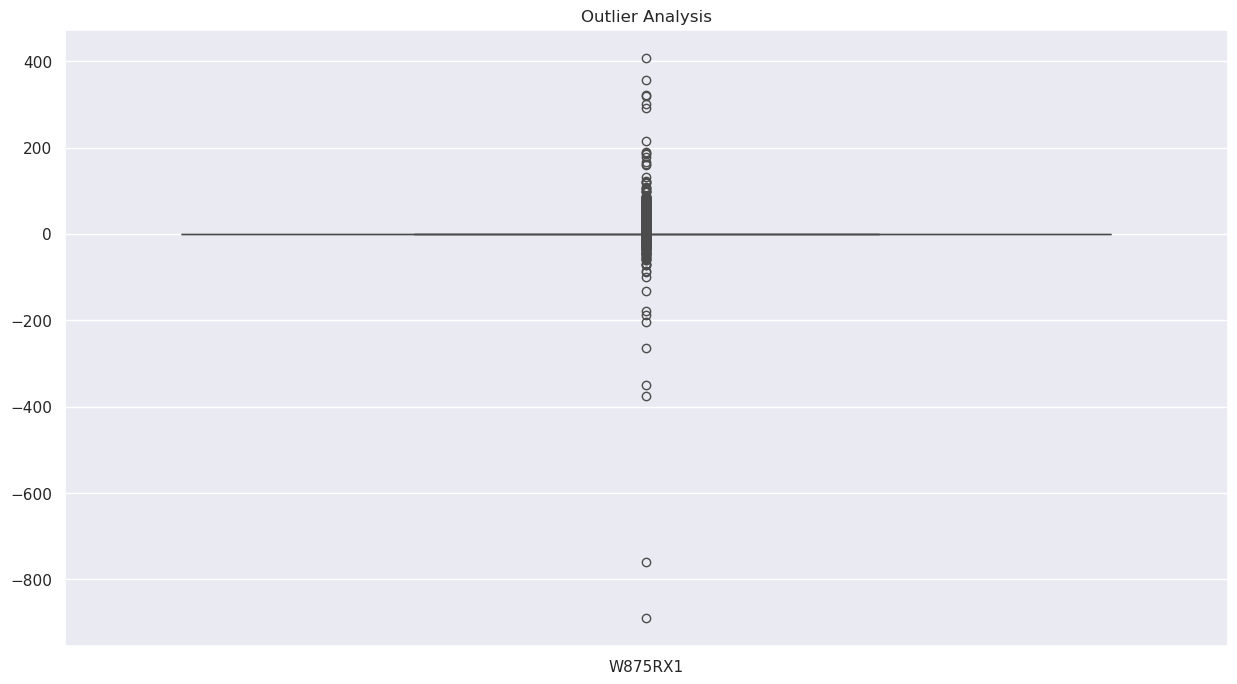

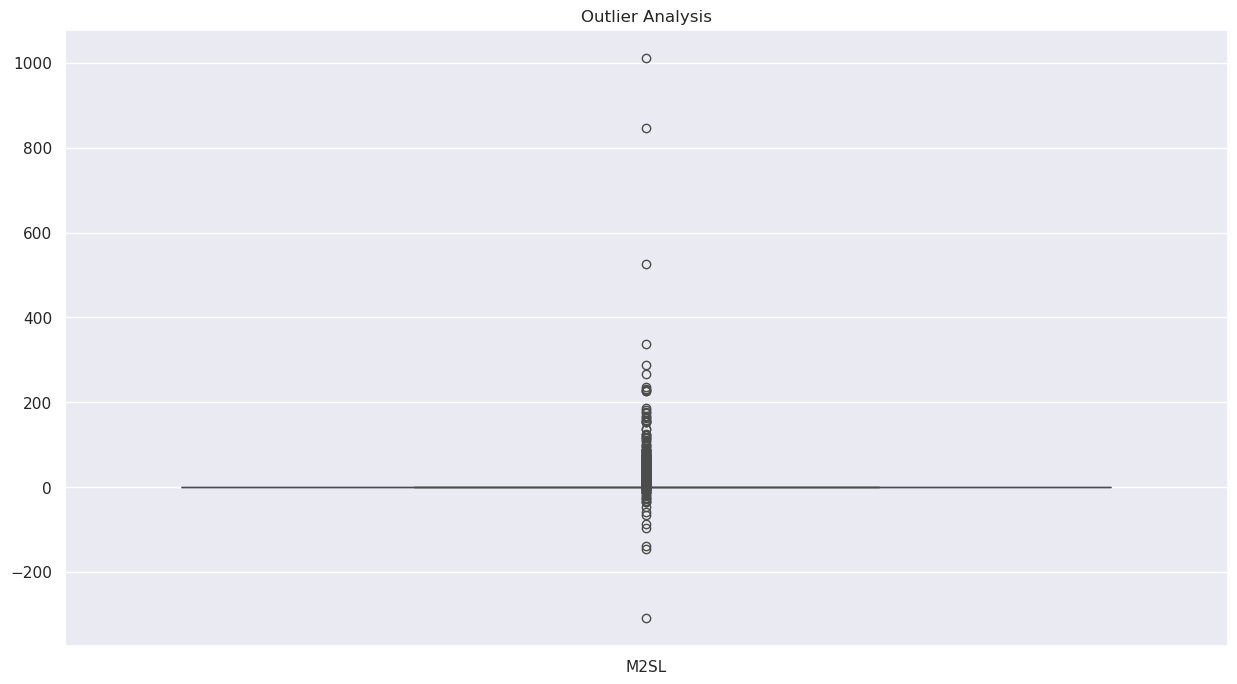

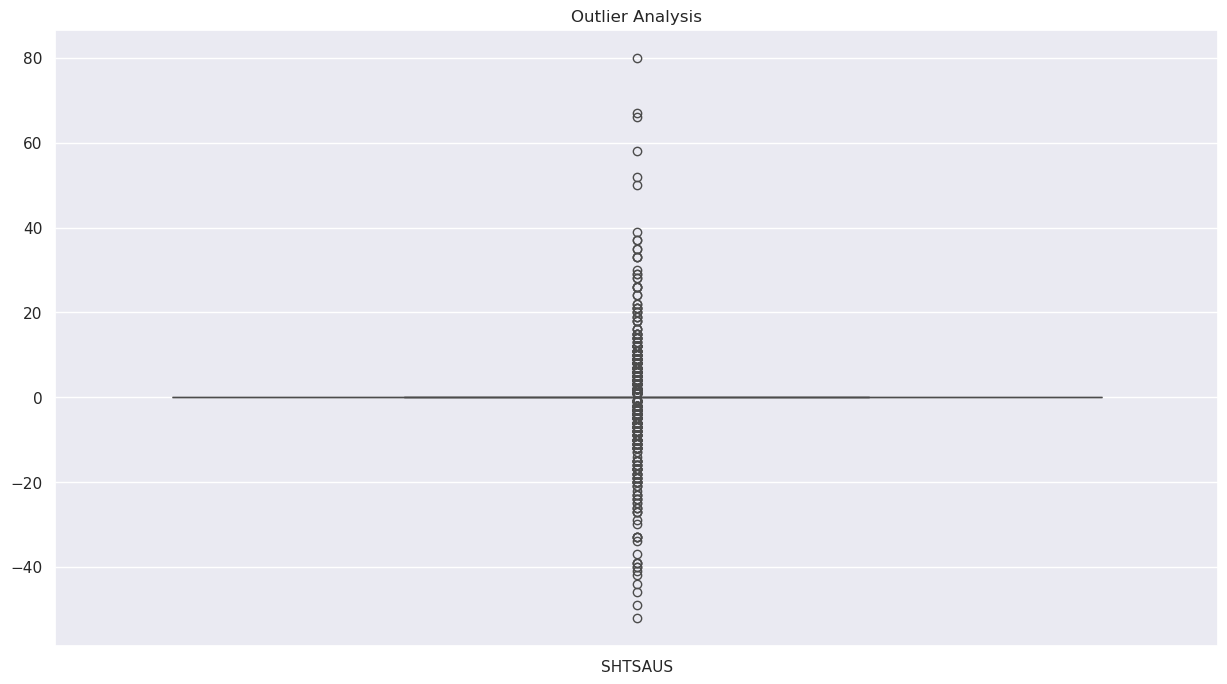

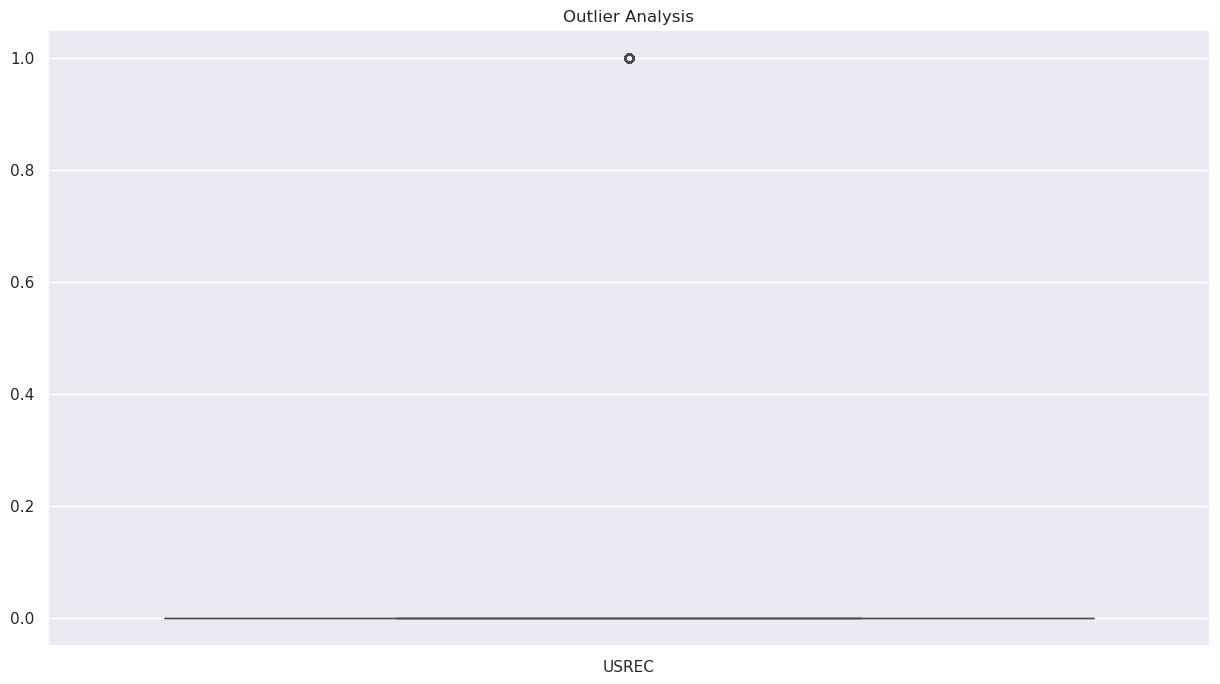

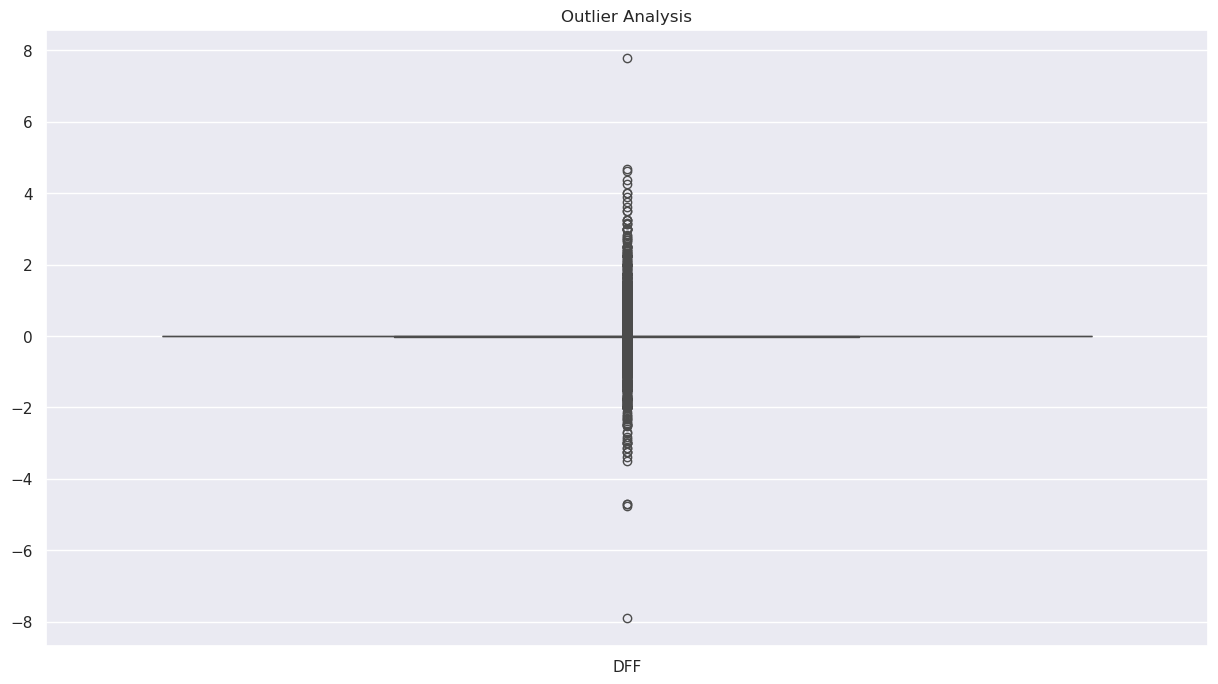

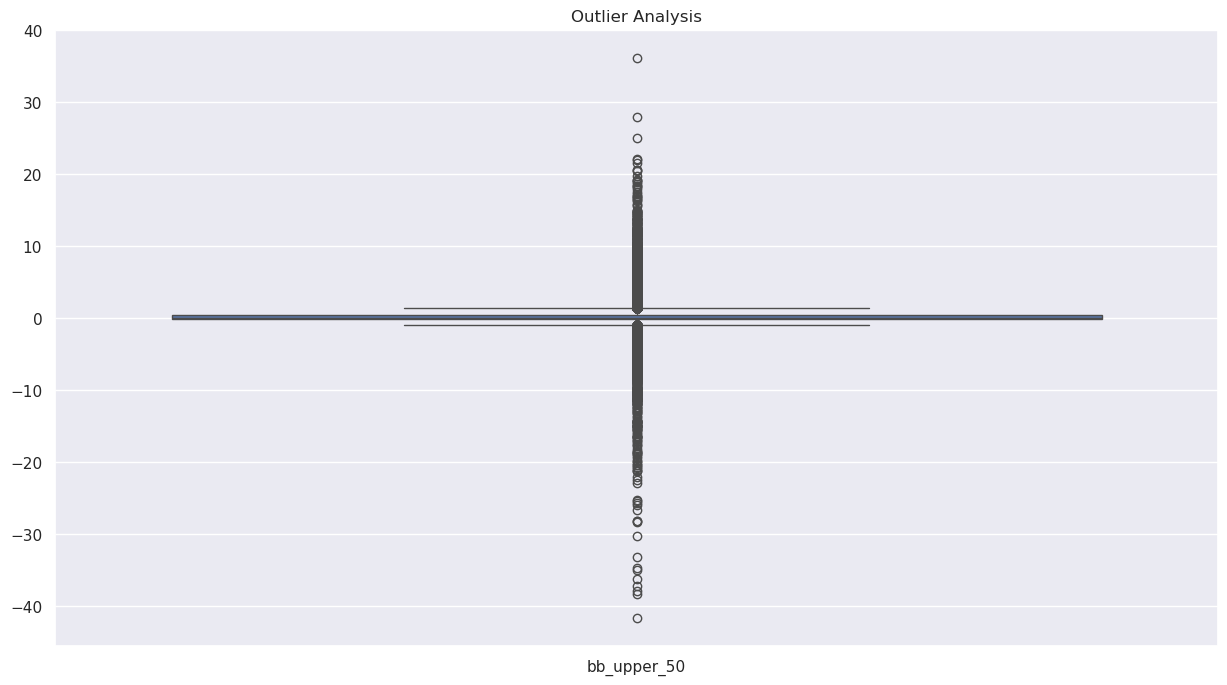

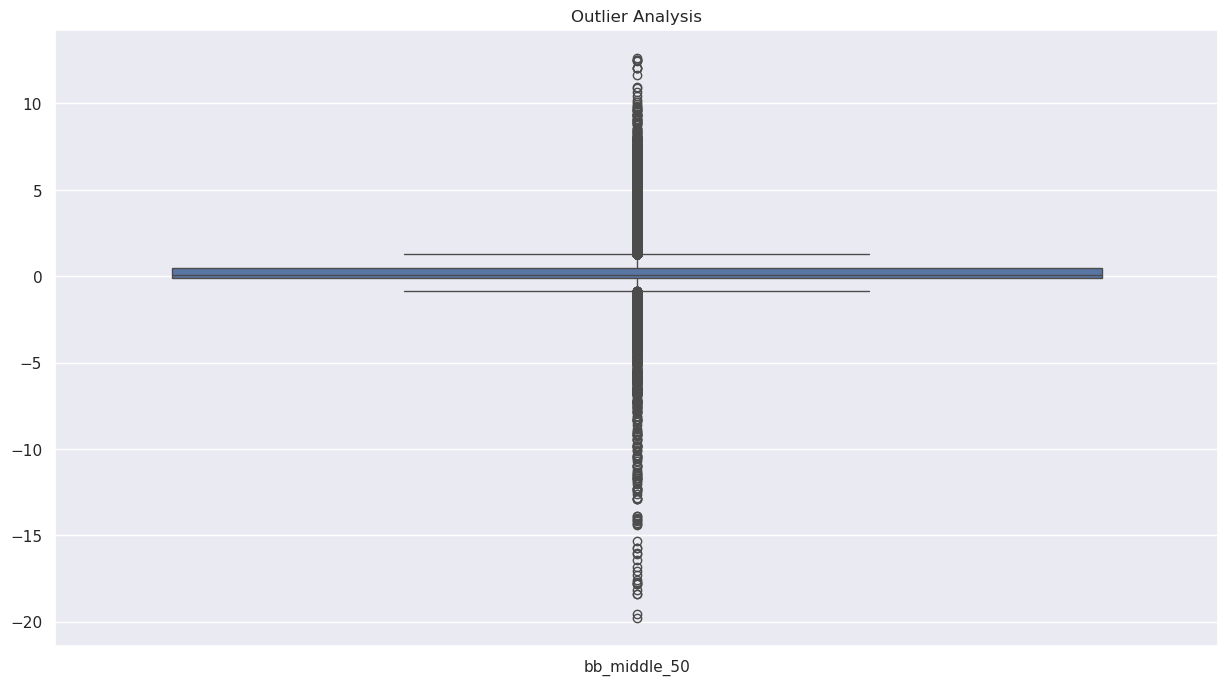

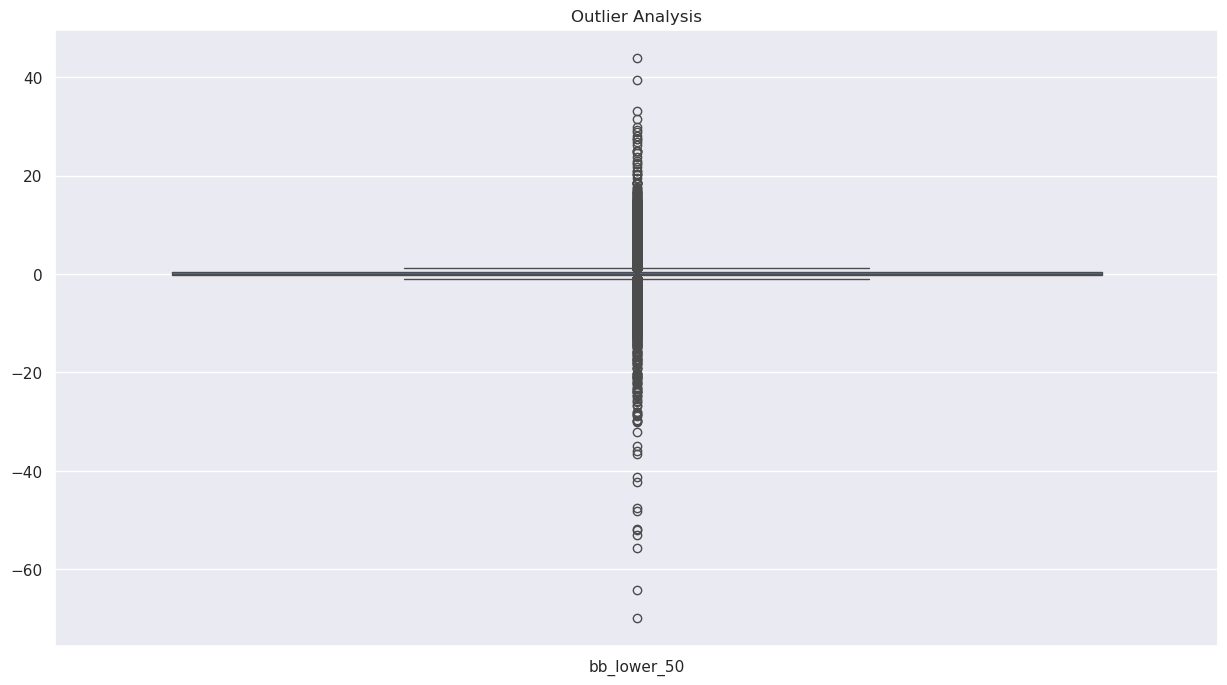

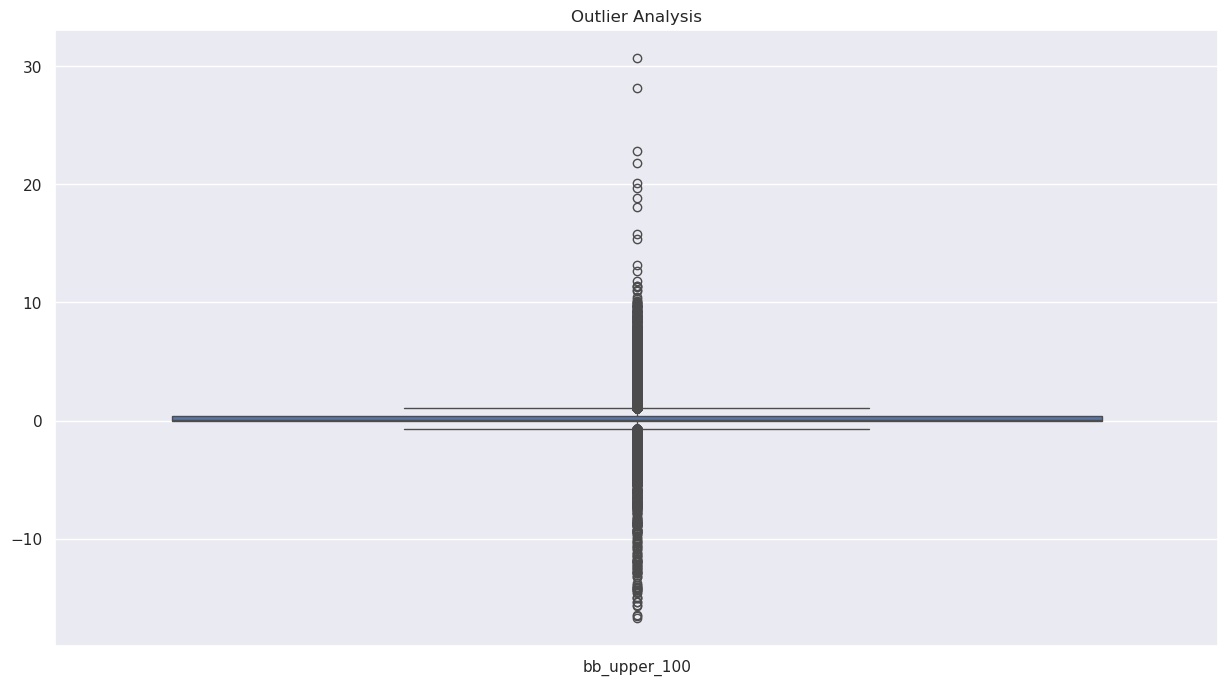

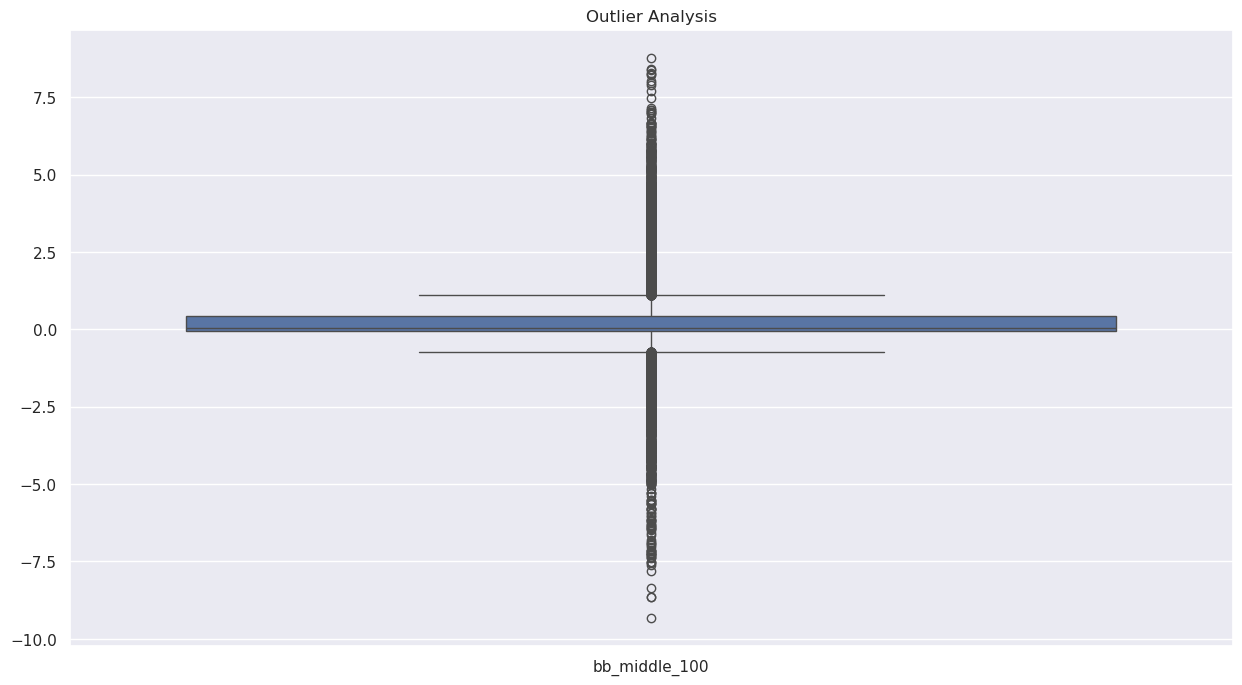

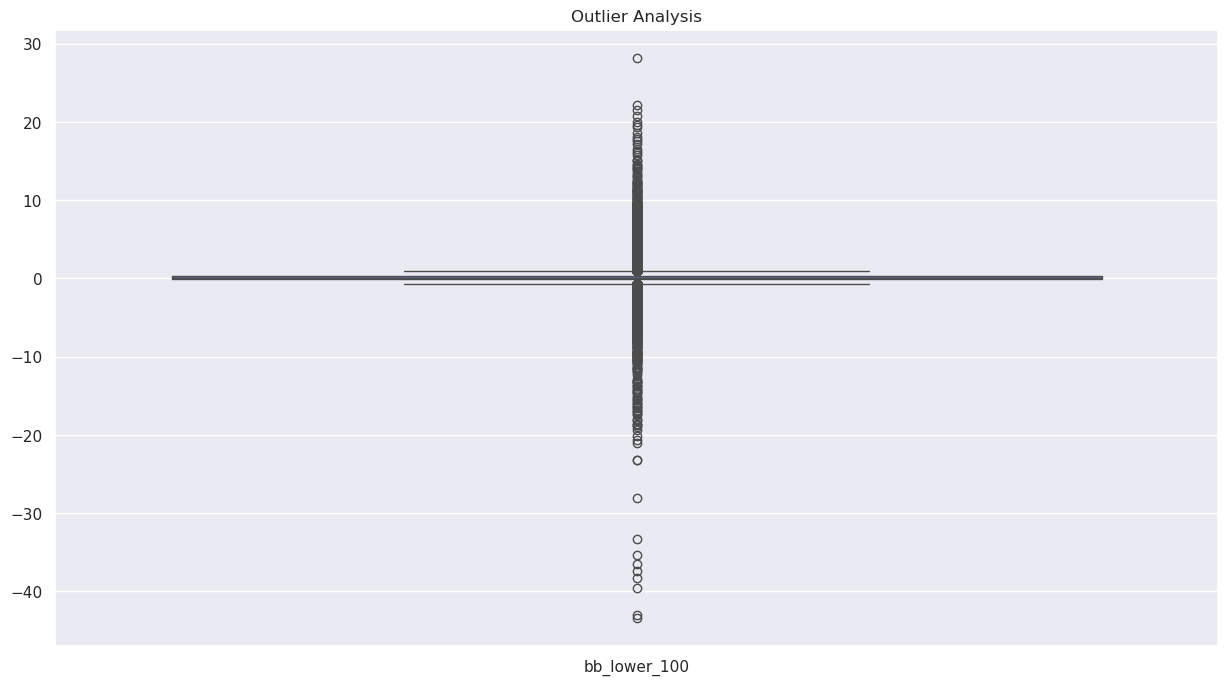

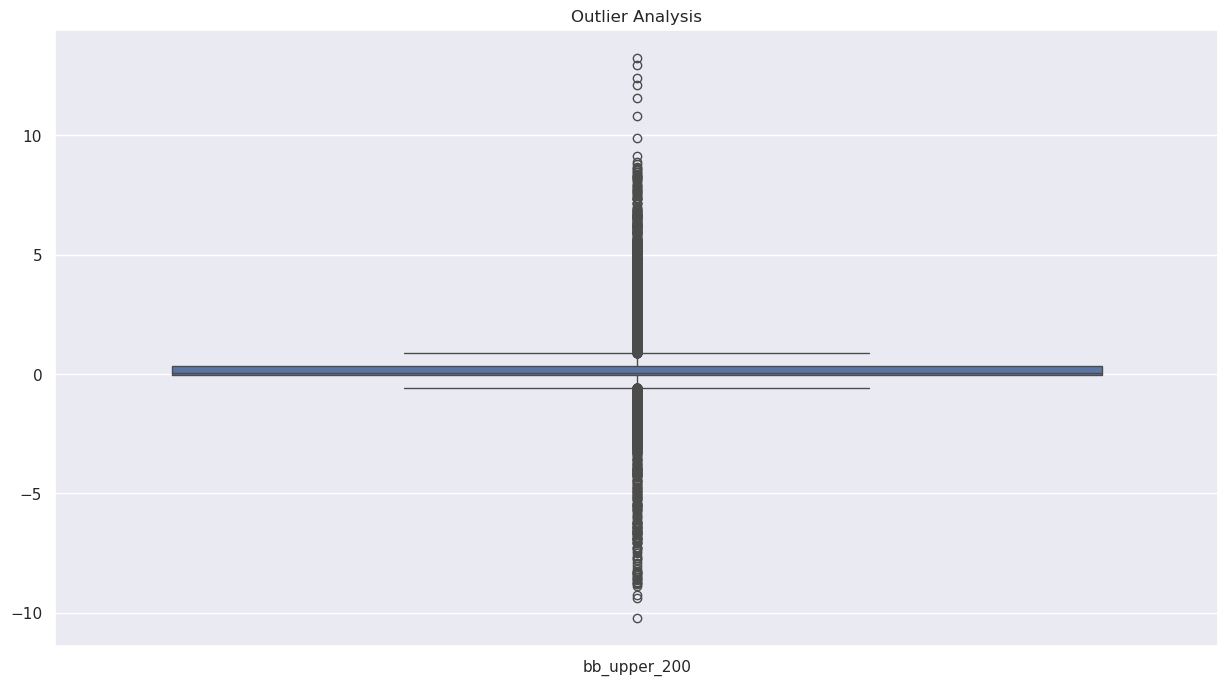

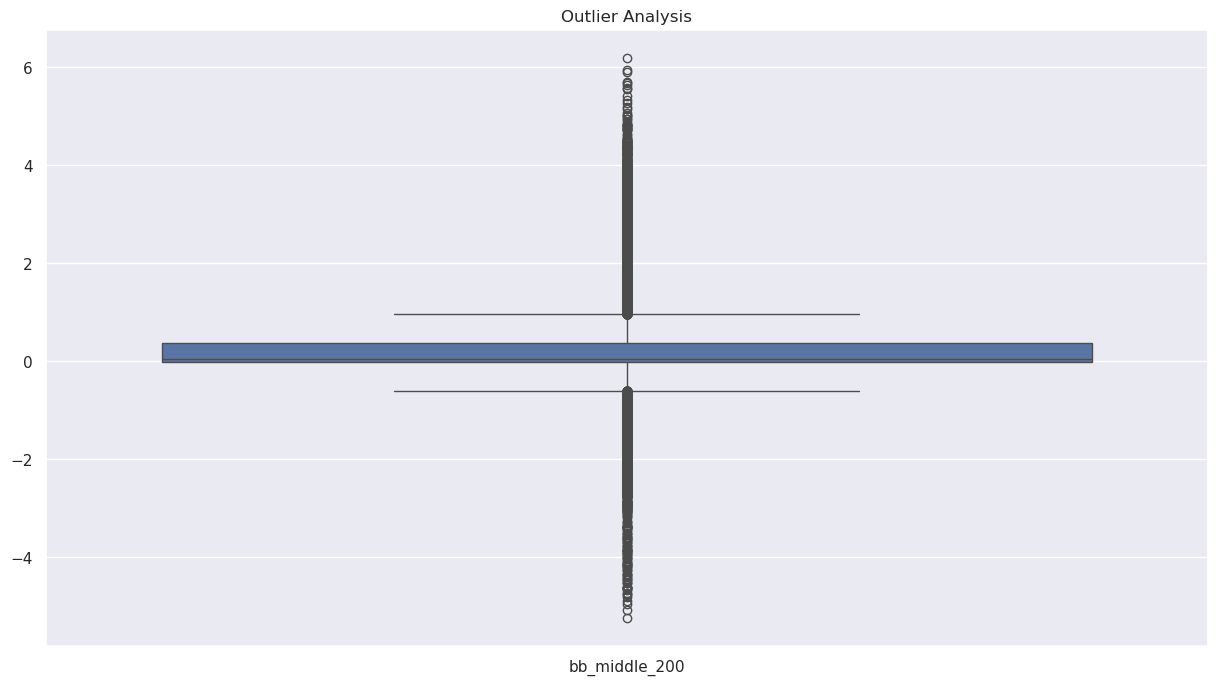

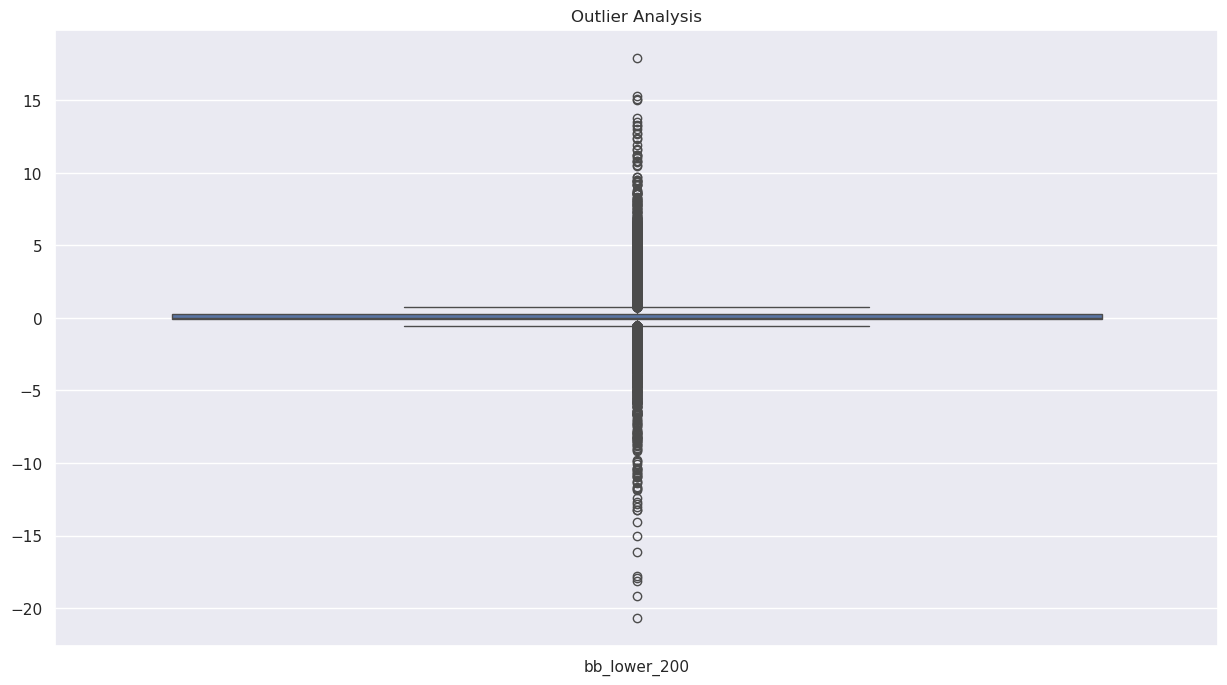

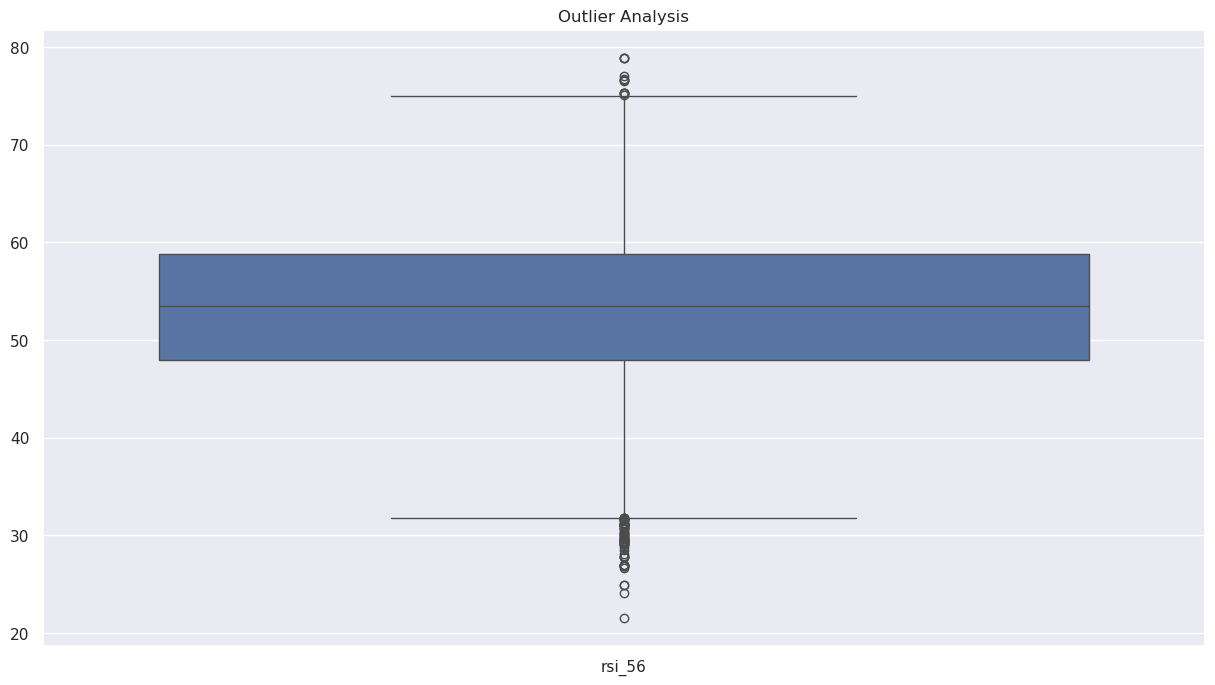

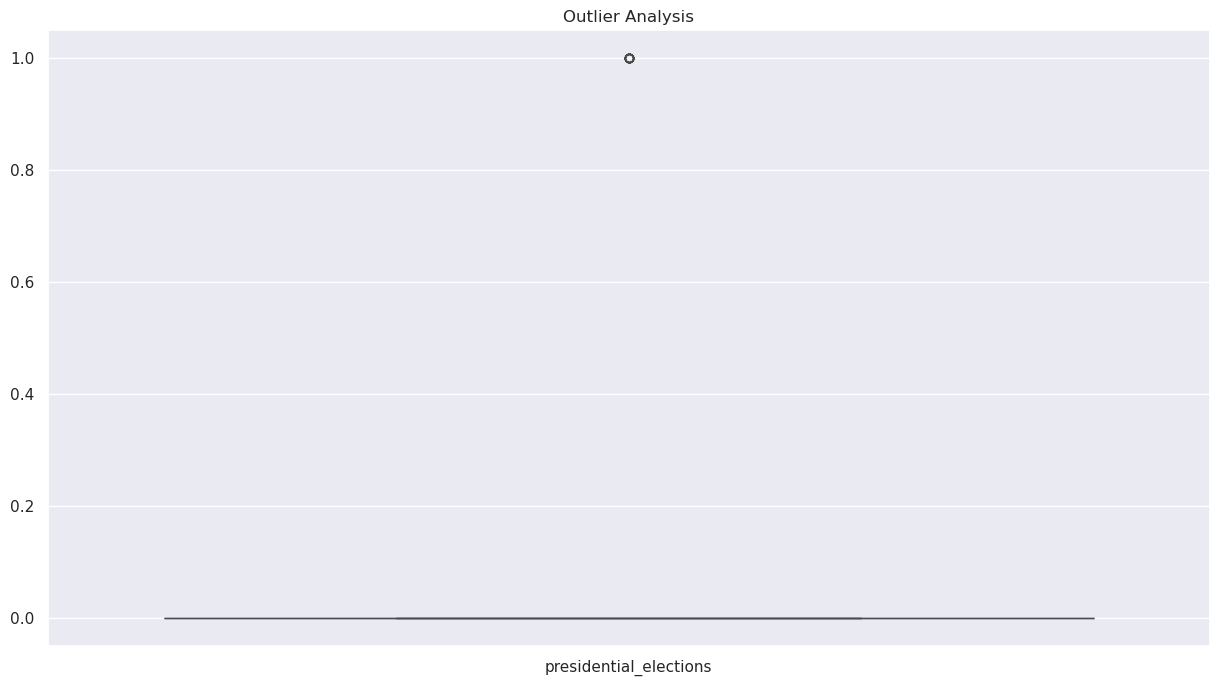

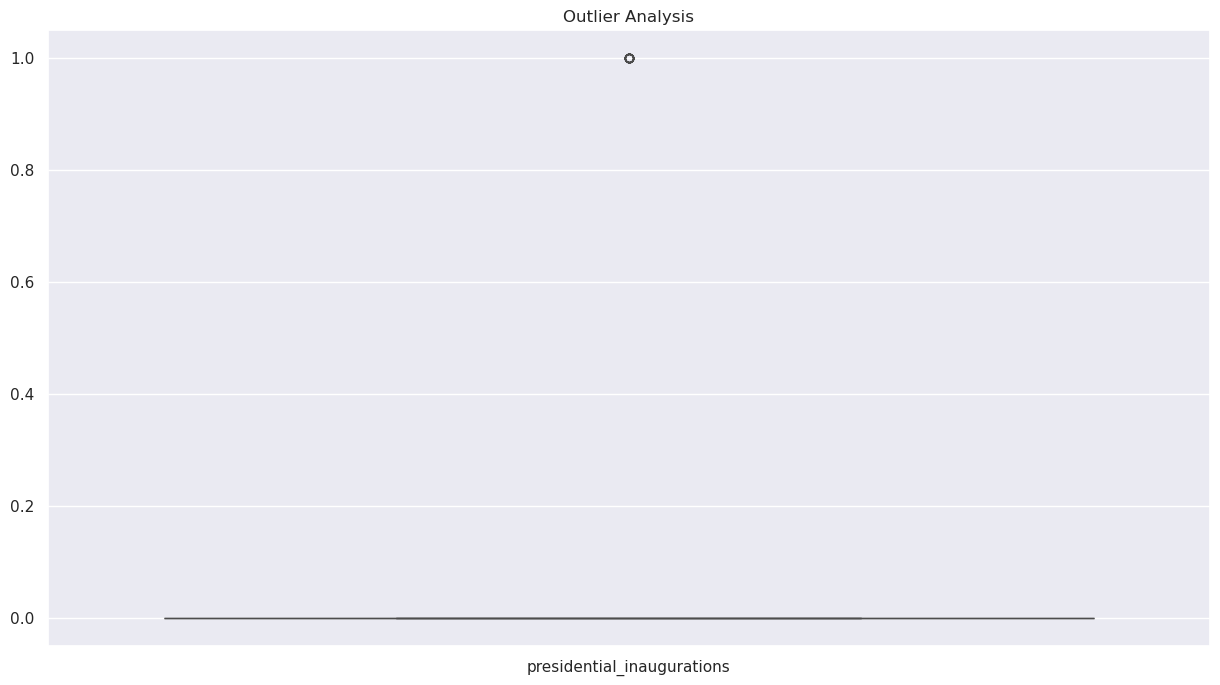

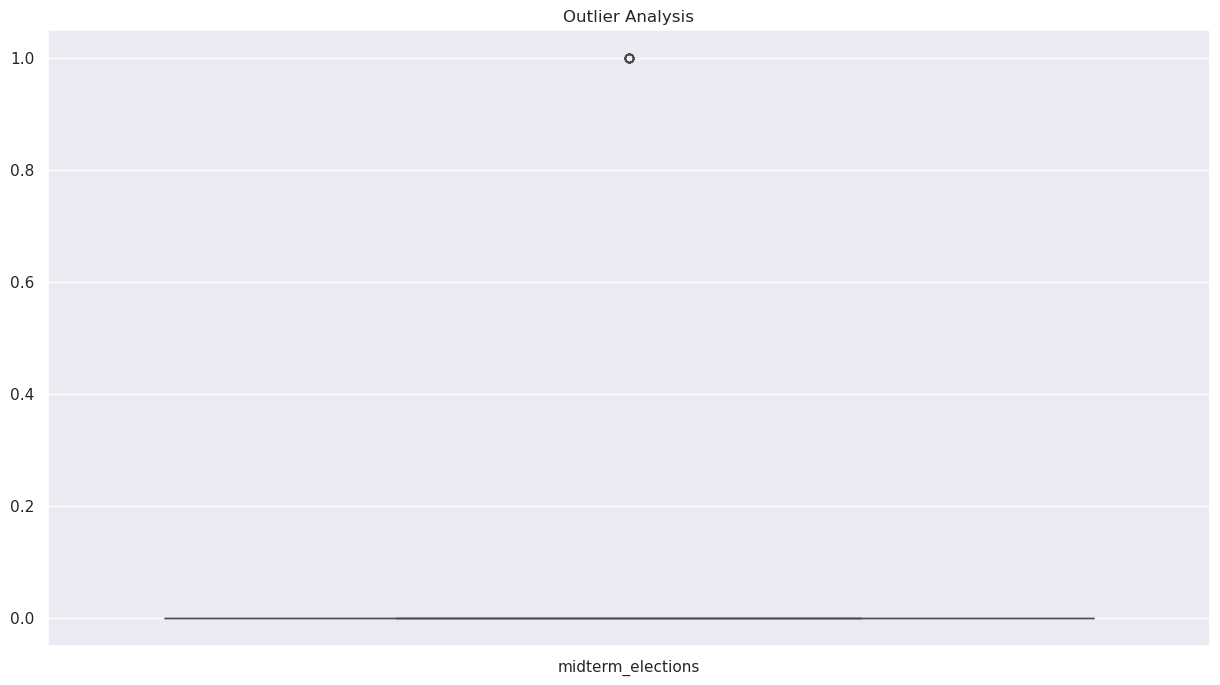

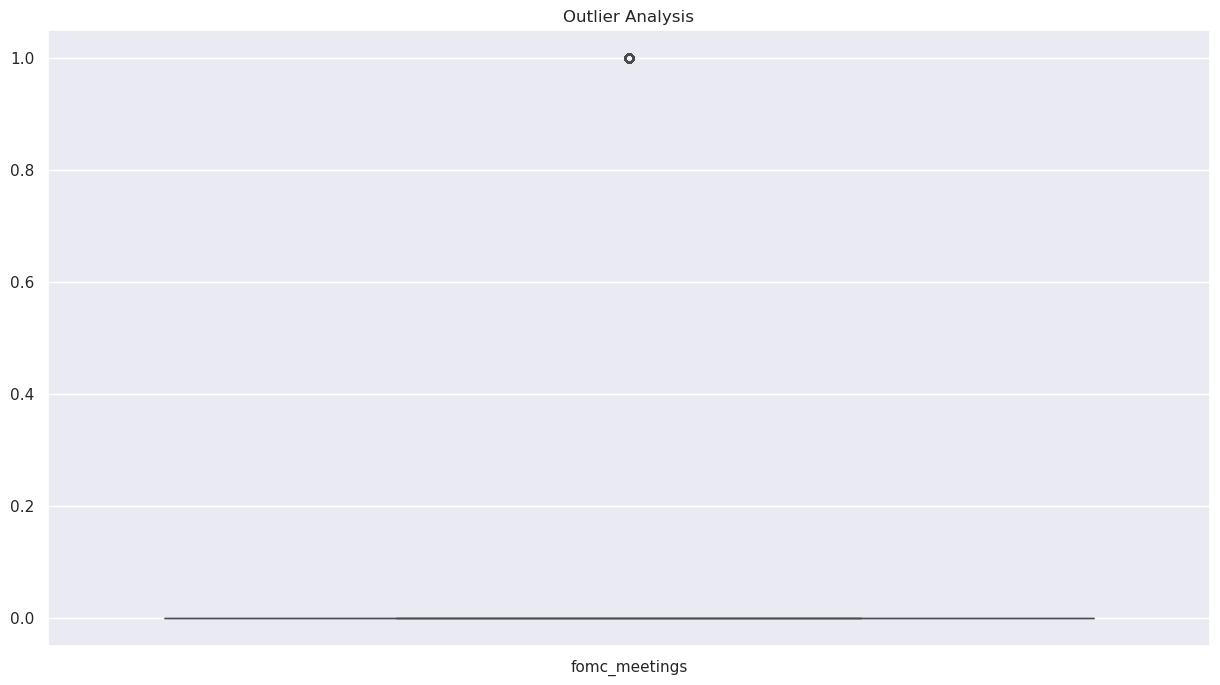

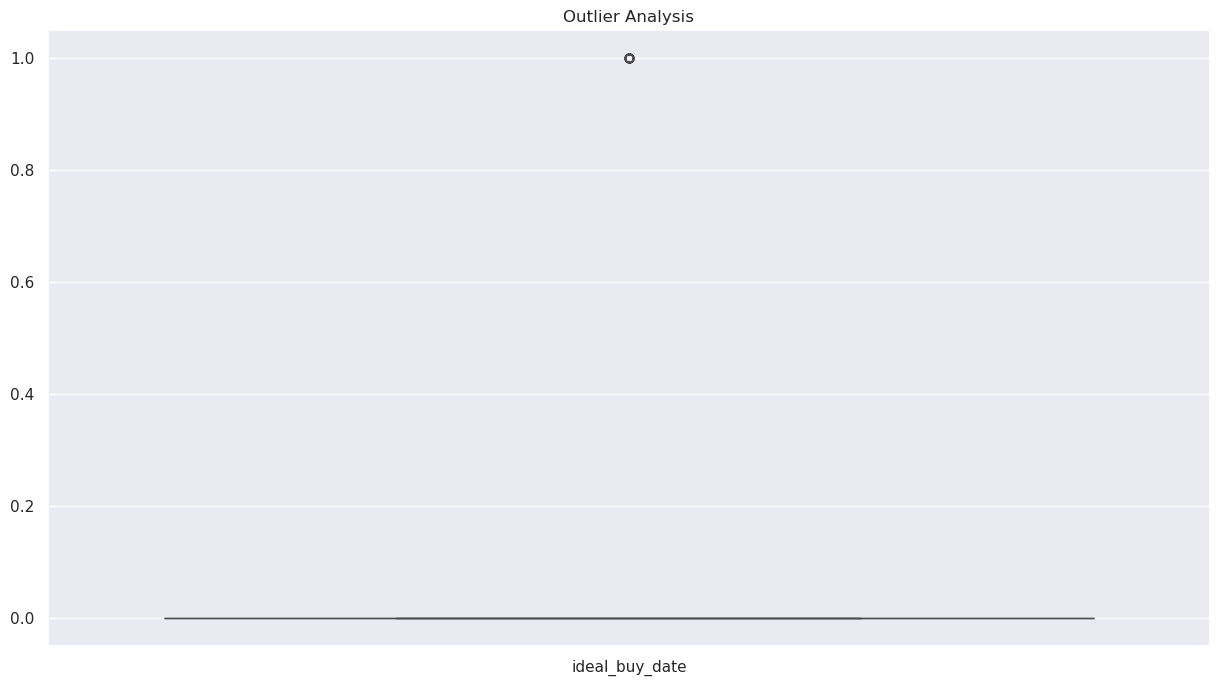

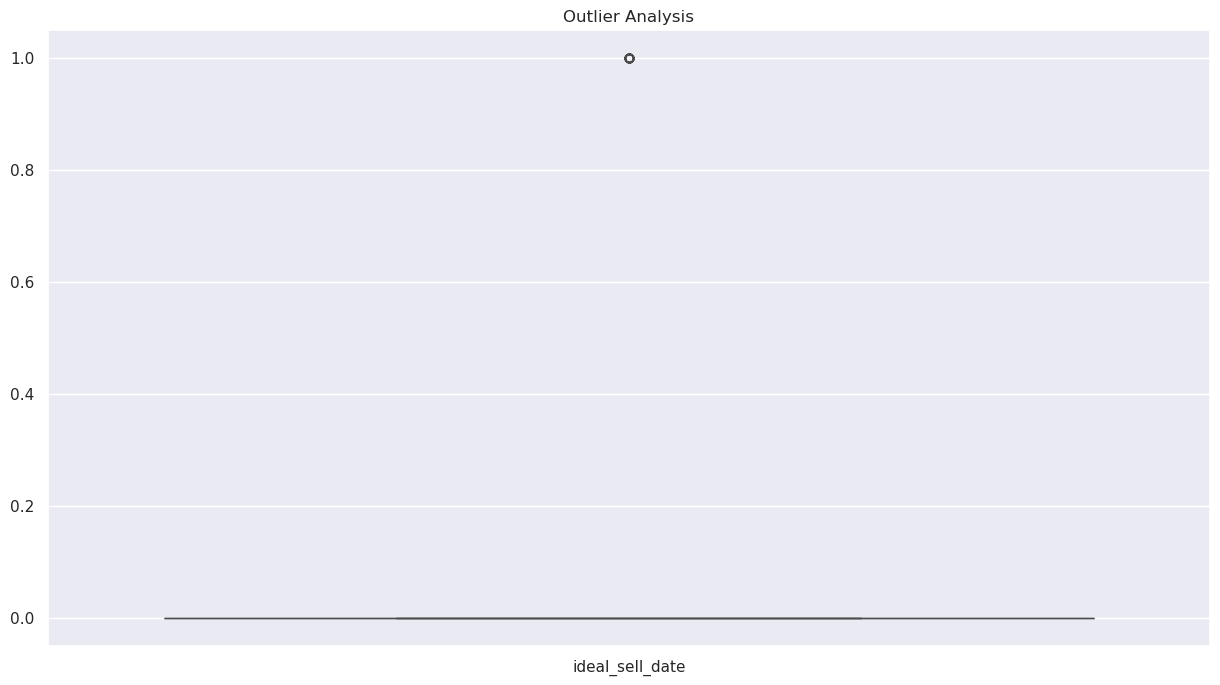

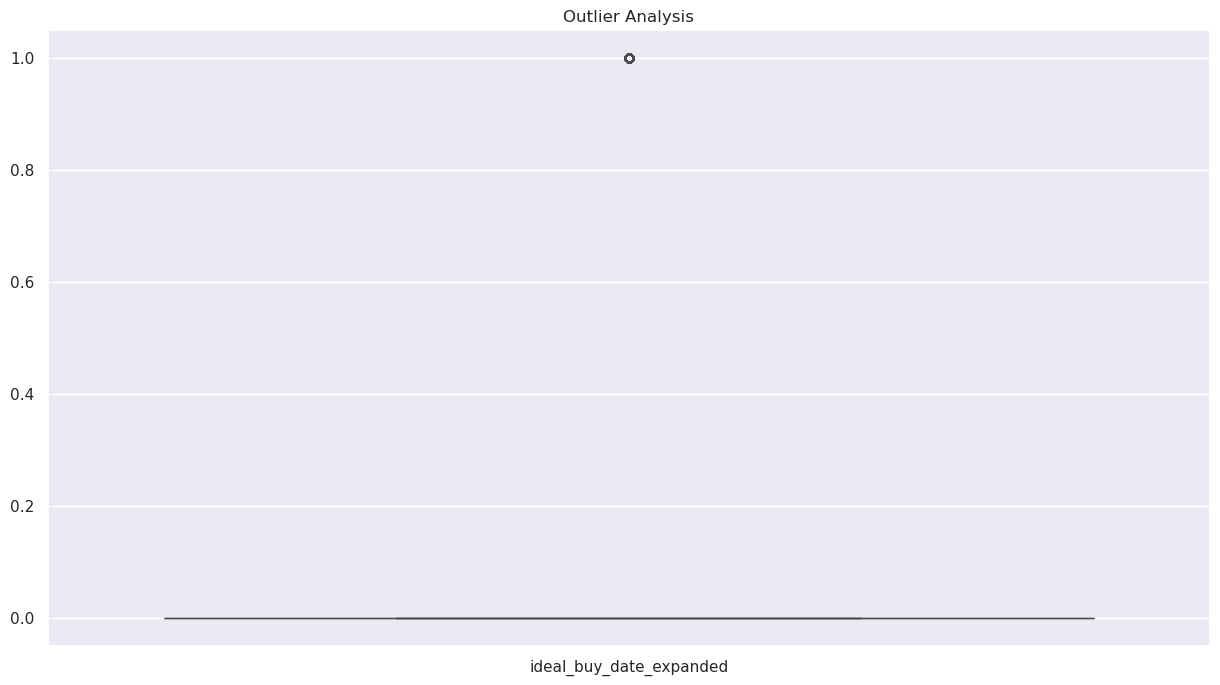

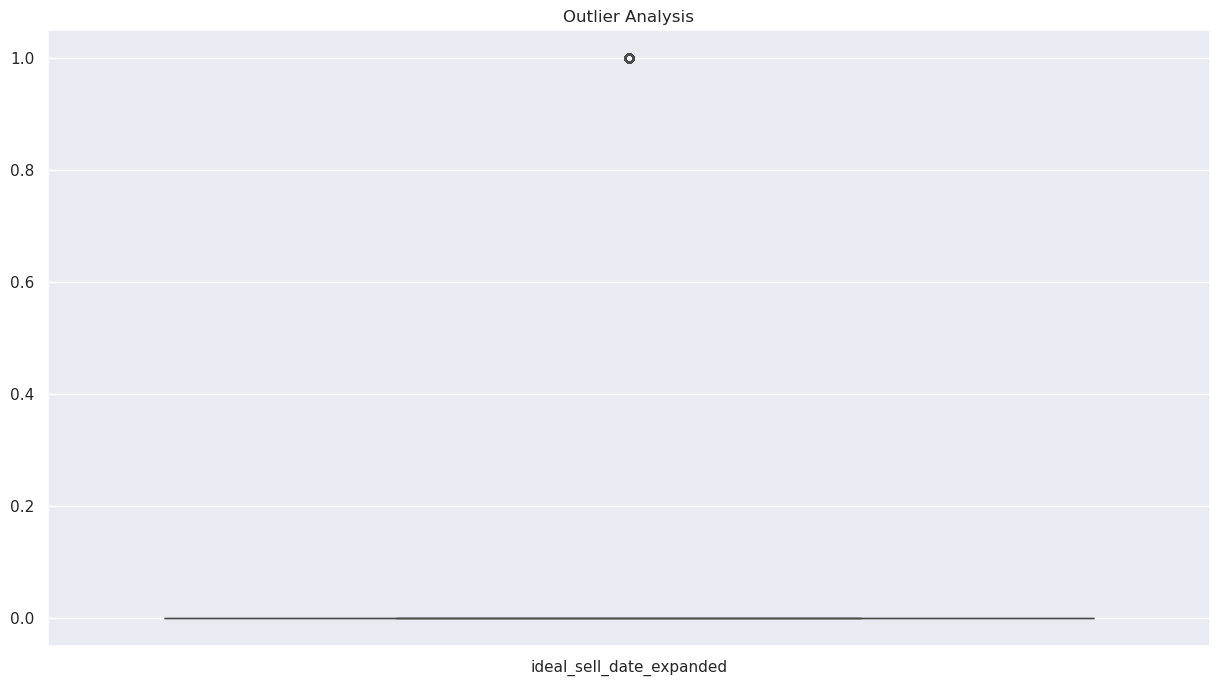

In [ ]:
for col in sp_concat:
    plt.figure(figsize=(15, 8))
    sns.boxplot(data=sp_concat[[col]])
    plt.title('Outlier Analysis')
    plt.show()

Too many features for box plot. I'll filter out the outliers by using the IQR method.

In [ ]:
Q1 = sp_concat.quantile(0.25)
Q3 = sp_concat.quantile(0.75)
IQR = Q3 - Q1
outliers = ((sp_concat < (Q1 - 1.5 * IQR)) | (sp_concat > (Q3 + 1.5 * IQR))).any(axis=1)


print(f"Number of outliers: {outliers.sum()}")


Number of outliers: 20196


Basically every row has an IQR outlier. I will try using zscore instead.

In [ ]:
z_scores = sp_concat.apply(zscore)
outliers = (z_scores.abs() > 3).any(axis=1)  
print(f"Number of outliers: {outliers.sum()}")

Number of outliers: 5550
